In [2]:
# Cell 1: imports & global config
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# paths
ROOT = Path.cwd()               # project root shown in your screenshot
RAW = ROOT / "Data" / "Raw_data"
TRANS = ROOT / "Data" / "Transformed_data"
TRANS.mkdir(parents=True, exist_ok=True)

# display options
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

# debug: show RAW path and files
print("ROOT:", ROOT)
print("RAW:", RAW)
print("RAW exists:", RAW.exists())
if RAW.exists():
    for p in sorted(RAW.glob("*")):
        print(p.name)
else:
    print("Create folder and put your CSVs here:", RAW)


ROOT: c:\Users\tssmi\OneDrive\Desktop\AINutricare\Notebooks
RAW: c:\Users\tssmi\OneDrive\Desktop\AINutricare\Notebooks\Data\Raw_data
RAW exists: True
admissions.csv
chartevents.csv
core_numerical_data.csv
d_icd_diagnoses.csv
d_items.csv
d_labitems.csv
diagnoses_icd.csv
diagnostics_outputs
icustays.csv
inputevents.csv
labevents.csv
omr.csv
outputevents.csv
patients.csv
prescriptions.csv


In [3]:
# Cell 2: list CSV files with sizes
files = sorted([p for p in RAW.glob("*.csv")])
for f in files:
    size_mb = f.stat().st_size / (1024*1024)
    print(f"{f.name:30}  {size_mb:7.2f} MB")


admissions.csv                     0.05 MB
chartevents.csv                   61.70 MB
core_numerical_data.csv            0.05 MB
d_icd_diagnoses.csv                8.44 MB
d_items.csv                        0.35 MB
d_labitems.csv                     0.06 MB
diagnoses_icd.csv                  0.12 MB
icustays.csv                       0.02 MB
inputevents.csv                    5.10 MB
labevents.csv                     11.70 MB
omr.csv                            0.12 MB
outputevents.csv                   0.77 MB
patients.csv                       0.00 MB
prescriptions.csv                  2.98 MB


In [4]:
# Cell 3: helper functions for EDA
%matplotlib inline
import matplotlib.pyplot as plt

def quick_head(path, n=5):
    return pd.read_csv(path, nrows=n)

def get_schema(path):
    df = pd.read_csv(path, nrows=0)
    return list(df.columns), df.dtypes.to_dict()

def basic_stats(df, numeric_only=True):
    return df.describe(include="all") if not numeric_only else df.describe()

def missing_summary(df):
    m = df.isna().sum().sort_values(ascending=False)
    pct = (m / len(df) * 100).round(2)
    return pd.DataFrame({"missing_count": m, "missing_pct": pct})

def show_top_values(df, col, n=10):
    return df[col].value_counts(dropna=False).head(n)

def plot_hist(series, title=None, bins=50):
    plt.figure(figsize=(6,3.5))
    plt.hist(series.dropna().values, bins=bins)
    plt.title(title or series.name)
    plt.xlabel(series.name)
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

def plot_time_counts(df, timecol, freq="D", title="time series counts"):
    s = pd.to_datetime(df[timecol], errors="coerce")
    s = s.dropna()
    counts = s.dt.to_period(freq).value_counts().sort_index()
    counts.index = counts.index.to_timestamp()
    plt.figure(figsize=(8,3))
    plt.plot(counts.index, counts.values)
    plt.title(title)
    plt.xlabel("time")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()


In [5]:
# Cell 4: inspect small "dictionary" or demographics files
small_files = ["patients.csv", "omr.csv", "d_labitems.csv", "d_items.csv", "d_icd_diagnoses.csv"]
for name in small_files:
    path = RAW / name
    if not path.exists():
        print(f"Missing: {name}")
        continue
    print("\n" + "="*60)
    print(f"FILE: {name}")
    cols, dtypes = get_schema(path)
    print("Columns:", cols)
    df = quick_head(path, n=5)
    display(df)
    try:
        df_full = pd.read_csv(path)
        print("-- shape:", df_full.shape)
        display(missing_summary(df_full).head(10))
    except Exception as e:
        print("Could not read full file (maybe large). First 5 rows shown above.")



FILE: patients.csv
Columns: ['subject_id', 'gender', 'anchor_age', 'anchor_year', 'anchor_year_group', 'dod']


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10014729,F,21,2125,2011 - 2013,NaN
1,10003400,F,72,2134,2011 - 2013,2137-09-02
2,10002428,F,80,2155,2011 - 2013,NaN
3,10032725,F,38,2143,2011 - 2013,2143-03-30
4,10027445,F,48,2142,2011 - 2013,2146-02-09


-- shape: (100, 6)


,missing_count,missing_pct
dod,69,69.0
subject_id,0,0.0
gender,0,0.0
anchor_age,0,0.0
anchor_year,0,0.0
anchor_year_group,0,0.0



FILE: omr.csv
Columns: ['subject_id', 'chartdate', 'seq_num', 'result_name', 'result_value']


,subject_id,chartdate,seq_num,result_name,result_value
0,10011398,2146-12-01,1,Height (Inches),63
1,10011398,2147-01-22,1,Weight (Lbs),127
2,10011398,2146-12-01,1,Weight (Lbs),135
3,10011398,2147-07-24,1,Weight (Lbs),136
4,10011398,2147-03-26,1,Weight (Lbs),136


-- shape: (2964, 5)


,missing_count,missing_pct
subject_id,0,0.0
chartdate,0,0.0
seq_num,0,0.0
result_name,0,0.0
result_value,0,0.0



FILE: d_labitems.csv
Columns: ['itemid', 'label', 'fluid', 'category']


,itemid,label,fluid,category
0,50808,Free Calcium,Blood,Blood Gas
1,50826,Tidal Volume,Blood,Blood Gas
2,50813,Lactate,Blood,Blood Gas
3,52029,% Ionized Calcium,Blood,Blood Gas
4,50801,Alveolar-arterial Gradient,Blood,Blood Gas


-- shape: (1622, 4)


,missing_count,missing_pct
label,3,0.18
itemid,0,0.00
fluid,0,0.00
category,0,0.00



FILE: d_items.csv
Columns: ['itemid', 'label', 'abbreviation', 'linksto', 'category', 'unitname', 'param_type', 'lownormalvalue', 'highnormalvalue']


,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,226228,Gender,Gender,chartevents,ADT,NaN,Text,NaN,NaN
1,226545,Race,Race,chartevents,ADT,NaN,Text,NaN,NaN
2,229877,Suction events (CH),Suction events (CH),chartevents,ECMO,NaN,Text,NaN,NaN
3,229875,Oxygenator visible (CH),Oxygenator visible (CH),chartevents,ECMO,NaN,Text,NaN,NaN
4,229266,Cannula sites visually inspected (ECMO),Cannula sites visually inspected (ECMO),chartevents,ECMO,NaN,Text,NaN,NaN


-- shape: (4014, 9)


,missing_count,missing_pct
lownormalvalue,3995,99.53
highnormalvalue,3992,99.45
unitname,2906,72.40
itemid,0,0.00
label,0,0.00
category,0,0.00
linksto,0,0.00
abbreviation,0,0.00
param_type,0,0.00



FILE: d_icd_diagnoses.csv
Columns: ['icd_code', 'icd_version', 'long_title']


,icd_code,icd_version,long_title
0,90,9,"Infectious colitis, enteritis, and gastroenter..."
1,1160,9,"Tuberculous pneumonia [any form], unspecified"
2,1186,9,"Other specified pulmonary tuberculosis, tuberc..."
3,1200,9,"Tuberculous pleurisy, unspecified"
4,1236,9,"Tuberculous laryngitis, tubercle bacilli not f..."


-- shape: (109775, 3)


,missing_count,missing_pct
icd_code,0,0.0
icd_version,0,0.0
long_title,0,0.0


In [5]:
# Cell 5: detailed patients.csv EDA
pfile = RAW/"patients.csv"
pat = pd.read_csv(pfile)
print("shape:", pat.shape)
display(pat.head())
display(pat.gender.value_counts(dropna=False))
display(missing_summary(pat))


shape: (100, 6)


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10014729,F,21,2125,2011 - 2013,NaN
1,10003400,F,72,2134,2011 - 2013,2137-09-02
2,10002428,F,80,2155,2011 - 2013,NaN
3,10032725,F,38,2143,2011 - 2013,2143-03-30
4,10027445,F,48,2142,2011 - 2013,2146-02-09


gender
M    57
F    43
Name: count, dtype: int64

,missing_count,missing_pct
dod,69,69.0
subject_id,0,0.0
gender,0,0.0
anchor_age,0,0.0
anchor_year,0,0.0
anchor_year_group,0,0.0


In [6]:
# Cell 6: admissions.csv EDA
af = RAW/"admissions.csv"
adm = pd.read_csv(af, parse_dates=["admittime","dischtime"], low_memory=False)
print("shape:", adm.shape)
display(adm.head())
print("unique hadm:", adm['hadm_id'].nunique())
display(missing_summary(adm).head(20))

# admissions per year (if year available)
if "admittime" in adm.columns:
    adm["admit_year"] = adm["admittime"].dt.year
    print("admissions per year:")
    display(adm["admit_year"].value_counts().sort_index().head())


shape: (275, 16)


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10004235,24181354,2196-02-24 14:38:00,2196-03-04 14:02:00,NaN,URGENT,P03YMR,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,2196-02-24 12:15:00,2196-02-24 17:07:00,0
1,10009628,25926192,2153-09-17 17:08:00,2153-09-25 13:20:00,NaN,URGENT,P41R5N,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Medicaid,?,MARRIED,HISPANIC/LATINO - PUERTO RICAN,NaN,NaN,0
2,10018081,23983182,2134-08-18 02:02:00,2134-08-23 19:35:00,NaN,URGENT,P233F6,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Medicare,ENGLISH,MARRIED,WHITE,2134-08-17 16:24:00,2134-08-18 03:15:00,0
3,10006053,22942076,2111-11-13 23:39:00,2111-11-15 17:20:00,2111-11-15 17:20:00,URGENT,P38TI6,TRANSFER FROM HOSPITAL,DIED,Medicaid,ENGLISH,NaN,UNKNOWN,NaN,NaN,1
4,10031404,21606243,2113-08-04 18:46:00,2113-08-06 20:57:00,NaN,URGENT,P07HDB,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,NaN,NaN,0


unique hadm: 275


,missing_count,missing_pct
deathtime,260,94.55
edouttime,93,33.82
edregtime,93,33.82
discharge_location,42,15.27
marital_status,12,4.36
subject_id,0,0.00
admittime,0,0.00
hadm_id,0,0.00
admission_location,0,0.00
admit_provider_id,0,0.00


admissions per year:


admit_year
2110    2
2111    2
2112    4
2113    6
2114    2
Name: count, dtype: int64

In [7]:
# Cell 7: diagnoses
diag = pd.read_csv(RAW/"diagnoses_icd.csv", dtype=str)
print("shape:", diag.shape)
display(diag.head())
print("unique icd codes:", diag['icd_code'].nunique())
# Top diagnoses
display(diag['icd_code'].value_counts().head(15))

# Map to long titles if dictionary exists
d_icd = pd.read_csv(RAW/"d_icd_diagnoses.csv", dtype=str)
print("d_icd columns:", d_icd.columns.tolist())
display(d_icd.head())
# join example 
sample = diag['icd_code'].value_counts().head(10).reset_index()
sample.columns = ['icd_code', 'count']  # Explicitly set column names
print("sample columns:", sample.columns.tolist())  # Debug print
sample = sample.merge(d_icd, on='icd_code', how='left')
display(sample)

shape: (4506, 5)


,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10035185,22580999,3,4139,9
1,10035185,22580999,10,V707,9
2,10035185,22580999,1,41401,9
3,10035185,22580999,9,3899,9
4,10035185,22580999,11,V8532,9


unique icd codes: 1472


icd_code
4019      68
E785      57
2724      55
E039      47
Z794      37
Z87891    35
42731     34
25000     33
I2510     33
F329      32
I10       32
V1582     31
N179      31
311       30
41401     28
Name: count, dtype: int64

d_icd columns: ['icd_code', 'icd_version', 'long_title']


,icd_code,icd_version,long_title
0,0090,9,"Infectious colitis, enteritis, and gastroenter..."
1,01160,9,"Tuberculous pneumonia [any form], unspecified"
2,01186,9,"Other specified pulmonary tuberculosis, tuberc..."
3,01200,9,"Tuberculous pleurisy, unspecified"
4,01236,9,"Tuberculous laryngitis, tubercle bacilli not f..."


sample columns: ['icd_code', 'count']


,icd_code,count,icd_version,long_title
0,4019,68,9,Unspecified essential hypertension
1,E785,57,10,"Hyperlipidemia, unspecified"
2,2724,55,9,Other and unspecified hyperlipidemia
3,E039,47,10,"Hypothyroidism, unspecified"
4,Z794,37,10,Long term (current) use of insulin
5,Z87891,35,10,Personal history of nicotine dependence
6,42731,34,9,Atrial fibrillation
7,25000,33,9,Diabetes mellitus without mention of complicat...
8,I2510,33,10,Atherosclerotic heart disease of native corona...
9,F329,32,10,"Major depressive disorder, single episode, uns..."


In [8]:
# Cell 8: lab dictionary
dl = pd.read_csv(RAW/"d_labitems.csv", dtype=str)
print("total lab items:", len(dl))
display(dl.head(10))
# find expected labels we will use
candidates = ["Glucose","Hemoglobin A1c","Creatinine","LDL","HDL","Triglycerides","AST","ALT","TSH","T3","T4"]
found = dl[dl['label'].str.contains("Glucose|A1c|Creatinine|LDL|HDL|Triglycerides|AST|ALT|TSH|T3|T4", case=False, na=False)]
display(found.head(30))
print("Found candidate lab itemids:", found['itemid'].unique()[:20])


total lab items: 1622


,itemid,label,fluid,category
0,50808,Free Calcium,Blood,Blood Gas
1,50826,Tidal Volume,Blood,Blood Gas
2,50813,Lactate,Blood,Blood Gas
3,52029,% Ionized Calcium,Blood,Blood Gas
4,50801,Alveolar-arterial Gradient,Blood,Blood Gas
5,50810,"Hematocrit, Calculated",Blood,Blood Gas
6,52025,Delete,Blood,Blood Gas
7,52031,Osmolality,Blood,Blood Gas
8,52022,"Albumin, Blood",Blood,Blood Gas
9,50806,"Chloride, Whole Blood",Blood,Blood Gas


,itemid,label,fluid,category
17,52024,"Creatinine, Whole Blood",Blood,Blood Gas
26,52027,"Glucose, Whole Blood",Blood,Blood Gas
33,50809,Glucose,Blood,Blood Gas
84,50854,Absolute A1c,Blood,Chemistry
154,50905,"Cholesterol, LDL, Calculated",Blood,Chemistry
155,50928,Gastrin,Blood,Chemistry
192,50852,% Hemoglobin A1c,Blood,Chemistry
224,50861,Alanine Aminotransferase (ALT),Blood,Chemistry
233,50896,Calculated Thyroxine (T4) Index,Blood,Chemistry
264,50994,Thyroxine (T4),Blood,Chemistry


Found candidate lab itemids: ['52024' '52027' '50809' '50854' '50905' '50928' '50852' '50861' '50896'
 '50994' '50931' '51722' '52569' '50904' '51000' '50995' '51721' '50878'
 '50912' '52546']


In [9]:
# Cell 9: chunked reading example - count rows and top itemids
def chunked_value_counts(path, col='itemid', chunksize=200000):
    counts = {}
    for chunk in pd.read_csv(path, usecols=[col], chunksize=chunksize, dtype=str):
        vc = chunk[col].value_counts()
        for k,v in vc.items():
            counts[k] = counts.get(k,0) + int(v)
    # return top 20
    import heapq
    top = heapq.nlargest(20, counts.items(), key=lambda x: x[1])
    return top

print("Top itemids in labevents (sample):")
print(chunked_value_counts(RAW/'labevents.csv', col='itemid', chunksize=500000)[:20])


Top itemids in labevents (sample):
[('50971', 3022), ('50983', 3007), ('50912', 3003), ('50902', 2981), ('51006', 2974), ('51221', 2913), ('50882', 2863), ('50868', 2860), ('51265', 2827), ('51222', 2787), ('51301', 2760), ('51277', 2760), ('51249', 2760), ('51250', 2760), ('51279', 2760), ('51248', 2760), ('50931', 2711), ('50960', 2470), ('50893', 2377), ('50970', 2337)]


In [11]:

!pip install fastparquet
# Cell 10: extract specific labs (e.g., glucose, creatinine) into a small file
labdict = pd.read_csv(RAW/"d_labitems.csv", dtype=str)
# choose labels with these keywords (adjust as needed)
keywords = ["Glucose","Hemoglobin A1c","A1c","Creatinine","Cholesterol","LDL","HDL","Triglyceride","AST","ALT","TSH"]
lab_candidates = labdict[labdict['label'].str.contains("|".join(keywords), case=False, na=False)]
print("Selected lab labels count:", len(lab_candidates))
display(lab_candidates[['itemid','label']].head(50))

wanted_itemids = set(lab_candidates['itemid'].astype(int).tolist())

# chunk through labevents and collect rows of interest
cols = ['subject_id','hadm_id','itemid','charttime','valuenum','valueuom','value']
out_rows = []
chunksize = 500_000
for chunk in pd.read_csv(RAW/'labevents.csv', usecols=cols, chunksize=chunksize, parse_dates=['charttime'], low_memory=False):
    mask = chunk['itemid'].isin(wanted_itemids)
    sel = chunk.loc[mask, cols]
    out_rows.append(sel)
lab_sel = pd.concat(out_rows, ignore_index=True)
print("selected lab rows:", lab_sel.shape)
lab_sel.to_parquet(
    TRANS/"labevents_selected.parquet",
    engine="fastparquet",
    index=False
)

display(lab_sel.head())


   ---------------------------------------- 0.0/669.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/669.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/669.7 kB ? eta -:--:--
   --------------- ------------------------ 262.1/669.7 kB ? eta -:--:--
   --------------- ------------------------ 262.1/669.7 kB ? eta -:--:--
   ---------------------------------------- 669.7/669.7 kB 815.1 kB/s  0:00:01
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.7 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.7 MB ? eta -:--:--
   ------------ --------------------------- 0.5/1.7 MB 762.0 kB/s eta 0:00:02
 

,itemid,label
17,52024,"Creatinine, Whole Blood"
26,52027,"Glucose, Whole Blood"
33,50809,Glucose
84,50854,Absolute A1c
154,50905,"Cholesterol, LDL, Calculated"
155,50928,Gastrin
192,50852,% Hemoglobin A1c
224,50861,Alanine Aminotransferase (ALT)
263,50907,"Cholesterol, Total"
273,50931,Glucose


selected lab rows: (9764, 7)


,subject_id,hadm_id,itemid,charttime,valuenum,valueuom,value
0,10014354,29600294.0,50861,2148-08-16,14.0,IU/L,14
1,10014354,29600294.0,50912,2148-08-16,1.8,mg/dL,1.8
2,10014354,29600294.0,50931,2148-08-16,193.0,mg/dL,___
3,10014354,29600294.0,50878,2148-08-16,13.0,IU/L,13
4,10014354,26486158.0,50931,2148-08-24,210.0,mg/dL,___


In [12]:
# Cell 11: identify chart itemids for weight/height/BP/HR
ditems = pd.read_csv(RAW/"d_items.csv", dtype=str)
cands = ditems[ditems['label'].str.contains("Weight|Height|Heart Rate|Heart rate|BP|Blood Pressure|Systolic|Diastolic|Temperature", case=False, na=False)]
display(cands.head(40))
print("Total candidates:", len(cands))

# Extract selected chartevents rows (chunked)
wanted_chart_itemids = set(cands['itemid'].astype(int).unique().tolist())
chart_cols = ['subject_id','hadm_id','stay_id','itemid','charttime','valuenum','value']
buffer = []
for chunk in pd.read_csv(RAW/'chartevents.csv', usecols=chart_cols, chunksize=500_000, parse_dates=['charttime'], low_memory=False):
    chunk = chunk[chunk['itemid'].isin(wanted_chart_itemids)]
    if not chunk.empty:
        buffer.append(chunk)
if buffer:
    charts_sel = pd.concat(buffer, ignore_index=True)
    print("selected chart rows:", charts_sel.shape)
    charts_sel.to_parquet(TRANS/"chartevents_selected.parquet", engine="fastparquet", index=False)

    display(charts_sel.head())
else:
    print("No selected chartevents found with current candidate itemids.")


,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
96,227539,ART Blood Pressure Alarm Source,ART BP Alarm Source,chartevents,Alarms,NaN,Text,NaN,NaN
99,227239,ABP Alarm Source,ABP Alarm Source,chartevents,Alarms,NaN,Text,NaN,NaN
100,227240,NBP Alarm Source,NBP Alarm Source,chartevents,Alarms,NaN,Text,NaN,NaN
175,227854,Weight Bearing Status,Weight Bearing Status,chartevents,OT Notes,NaN,Text,NaN,NaN
415,224674,Changes in Temperature,Changes in Temperature,chartevents,Toxicology,NaN,Text,NaN,NaN
1177,224027,Skin Temperature,Skin Temp,chartevents,Skin - Assessment,NaN,Text,NaN,NaN
1493,226742,APACHE II Diagnosistic weight factors - Surgical,Diagnosistic weight categories - Surgical,chartevents,Scores - APACHE II,NaN,Text,NaN,NaN
1496,226740,APACHE II Diagnosistic weight factors - Medical,Diagnostic weight category - Medical,chartevents,Scores - APACHE II,NaN,Text,NaN,NaN
1499,226741,APACHE II Diagnosistic weight factors - Surgic...,Diagnosistic weight categories - Surgical emer...,chartevents,Scores - APACHE II,NaN,Text,NaN,NaN
1564,224642,Temperature Site,Temp Site,chartevents,Routine Vital Signs,NaN,Text,NaN,NaN


Total candidates: 102
selected chart rows: (75598, 7)


,subject_id,hadm_id,stay_id,charttime,itemid,value,valuenum
0,10005817,20626031,32604416,2132-12-16,220047,55,55.0
1,10005817,20626031,32604416,2132-12-16,220060,12,12.0
2,10005817,20626031,32604416,2132-12-16,220046,120,120.0
3,10005817,20626031,32604416,2132-12-16,220051,37,37.0
4,10005817,20626031,32604416,2132-12-16,220059,37,37.0


In [13]:
# Cell 12: join integrity checks
# load small index tables
patients = pd.read_csv(RAW/"patients.csv", usecols=['subject_id'])
admissions = pd.read_csv(RAW/"admissions.csv", usecols=['subject_id','hadm_id'])
print("unique patients:", patients['subject_id'].nunique())
print("unique admissions:", admissions['hadm_id'].nunique())

# check how many patients have labs (from labevents_selected)
lab_sel.to_parquet(
    TRANS/"labevents_selected.parquet",
    engine="fastparquet",
    index=False
)
print("labs unique patients:", lab_sel['subject_id'].nunique())
print("labs unique admissions:", lab_sel['hadm_id'].nunique())

# admissions without labs
adm_with_no_lab = admissions[~admissions['hadm_id'].isin(lab_sel['hadm_id'].dropna().astype(int).unique())]
print("admissions with no selected labs (sample 5):")
display(adm_with_no_lab.head())


unique patients: 100
unique admissions: 275
labs unique patients: 100
labs unique admissions: 251
admissions with no selected labs (sample 5):


,subject_id,hadm_id
32,10002930,28301173
33,10002930,22733922
135,10038999,29026789
170,10023239,28984460
171,10024043,25561728


In [ ]:
# Cell 15: save summary statistics for each file into TRANS folder
def save_summary(path):
    name = Path(path).stem
    try:
        df = pd.read_csv(path, nrows=200000)  # sample first 200k for huge files
    except Exception:
        df = pd.read_csv(path, nrows=2000)
    summary = {
        "filename": name,
        "shape_sample": df.shape,
        "columns": list(df.columns),
        "missing": df.isna().sum().to_dict(),
        "dtypes": df.dtypes.apply(lambda x: str(x)).to_dict()
    }
    out = TRANS / f"{name}_summary.json"
    import json
    with open(out, "w") as fh:
        json.dump(summary, fh, indent=2)
    return out

for f in files:
    print("Saving summary for", f.name)
    save_summary(f)
print("Summaries saved to", TRANS)


Saving summary for admissions.csv
Saving summary for chartevents.csv
Saving summary for d_icd_diagnoses.csv
Saving summary for d_items.csv
Saving summary for d_labitems.csv
Saving summary for diagnoses_icd.csv
Saving summary for icustays.csv
Saving summary for inputevents.csv
Saving summary for labevents.csv
Saving summary for omr.csv
Saving summary for outputevents.csv
Saving summary for patients.csv
Saving summary for prescriptions.csv
Summaries saved to c:\Users\tssmi\OneDrive\Desktop\AINutricare\Notebooks\Data\Transformed_data


In [14]:
# Formatted EDA summary: load directly from Raw_data and display summaries
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import os
from pathlib import Path

RAW = Path.cwd() / 'Data' / 'Raw_data'

def eda_summary(path, max_rows=100000):
    name = path.stem
    try:
        df = pd.read_csv(path, nrows=max_rows, low_memory=False)
    except Exception as e:
        display(HTML(f'<b style="color:red">Could not load {name}: {e}</b>'))
        return
    display(HTML(f'<h2 style="color:#2a4d69">{name}.csv</h2>'))
    display(HTML(f'<b>Shape:</b> {df.shape}'))
    display(HTML('<b>Sample rows:</b>'))
    display(df.head(5))
    # Missing values
    missing = df.isna().sum()
    missing_pct = (missing / len(df) * 100).round(2)
    missing_df = pd.DataFrame({'missing_count': missing, 'missing_pct': missing_pct})
    display(HTML('<b>Missing values (top 10):</b>'))
    display(missing_df.sort_values('missing_count', ascending=False).head(10))
    # Categorical columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(cat_cols) > 0:
        display(HTML(f'<b>Categorical columns ({len(cat_cols)}):</b> {list(cat_cols)}'))
        for col in cat_cols:
            vc = df[col].value_counts(dropna=False).head(10)
            display(HTML(f'<i>Top values for <b>{col}</b>:</i>'))
            display(vc)
    # Numeric columns
    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) > 0:
        display(HTML(f'<b>Numeric columns ({len(num_cols)}):</b> {list(num_cols)}'))
        desc = df[num_cols].describe().T.round(3)
        display(desc)
    display(HTML('<hr style="margin:20px 0;">'))

# List all CSVs in Raw_data
csvs = sorted(RAW.glob('*.csv'))
for path in csvs:
    eda_summary(path)


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10004235,24181354,2196-02-24 14:38:00,2196-03-04 14:02:00,NaN,URGENT,P03YMR,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,2196-02-24 12:15:00,2196-02-24 17:07:00,0
1,10009628,25926192,2153-09-17 17:08:00,2153-09-25 13:20:00,NaN,URGENT,P41R5N,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Medicaid,?,MARRIED,HISPANIC/LATINO - PUERTO RICAN,NaN,NaN,0
2,10018081,23983182,2134-08-18 02:02:00,2134-08-23 19:35:00,NaN,URGENT,P233F6,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Medicare,ENGLISH,MARRIED,WHITE,2134-08-17 16:24:00,2134-08-18 03:15:00,0
3,10006053,22942076,2111-11-13 23:39:00,2111-11-15 17:20:00,2111-11-15 17:20:00,URGENT,P38TI6,TRANSFER FROM HOSPITAL,DIED,Medicaid,ENGLISH,NaN,UNKNOWN,NaN,NaN,1
4,10031404,21606243,2113-08-04 18:46:00,2113-08-06 20:57:00,NaN,URGENT,P07HDB,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,NaN,NaN,0


,missing_count,missing_pct
deathtime,260,94.55
edouttime,93,33.82
edregtime,93,33.82
discharge_location,42,15.27
marital_status,12,4.36
subject_id,0,0.00
admittime,0,0.00
hadm_id,0,0.00
admission_location,0,0.00
admit_provider_id,0,0.00


admittime
2147-12-19 00:00:00    1
2196-02-24 14:38:00    1
2153-09-17 17:08:00    1
2134-08-18 02:02:00    1
2111-11-13 23:39:00    1
2113-08-04 18:46:00    1
2132-12-12 01:43:00    1
2180-02-15 20:28:00    1
2141-05-22 20:17:00    1
2115-09-27 20:40:00    1
Name: count, dtype: int64

dischtime
2147-12-21 16:10:00    1
2196-03-04 14:02:00    1
2153-09-25 13:20:00    1
2134-08-23 19:35:00    1
2111-11-15 17:20:00    1
2113-08-06 20:57:00    1
2132-12-20 15:04:00    1
2180-02-25 13:45:00    1
2141-05-29 17:41:00    1
2115-10-12 00:00:00    1
Name: count, dtype: int64

deathtime
NaN                    260
2111-11-15 17:20:00      1
2115-10-12 22:20:00      1
2177-03-29 14:15:00      1
2137-09-02 17:05:00      1
2185-01-22 14:25:00      1
2201-07-13 23:27:00      1
2117-03-24 23:08:00      1
2155-12-07 15:30:00      1
2116-07-05 08:05:00      1
Name: count, dtype: int64

admission_type
EW EMER.                       104
OBSERVATION ADMIT               45
URGENT                          38
EU OBSERVATION                  30
SURGICAL SAME DAY ADMISSION     18
DIRECT EMER.                    15
ELECTIVE                        13
DIRECT OBSERVATION               7
AMBULATORY OBSERVATION           5
Name: count, dtype: int64

admit_provider_id
P41R5N    9
P3529J    7
P233F6    5
P45GUA    5
P44WVR    5
P031HZ    5
P898NM    5
P47E1G    4
P96Y5O    4
P7554I    4
Name: count, dtype: int64

admission_location
EMERGENCY ROOM                            134
PHYSICIAN REFERRAL                         63
TRANSFER FROM HOSPITAL                     43
CLINIC REFERRAL                            10
WALK-IN/SELF REFERRAL                       7
PROCEDURE SITE                              7
TRANSFER FROM SKILLED NURSING FACILITY      4
PACU                                        4
INTERNAL TRANSFER TO OR FROM PSYCH          2
INFORMATION NOT AVAILABLE                   1
Name: count, dtype: int64

discharge_location
HOME HEALTH CARE                76
HOME                            72
NaN                             42
SKILLED NURSING FACILITY        36
DIED                            15
REHAB                           13
CHRONIC/LONG TERM ACUTE CARE     9
HOSPICE                          5
AGAINST ADVICE                   4
PSYCH FACILITY                   2
Name: count, dtype: int64

insurance
Other       149
Medicare    104
Medicaid     22
Name: count, dtype: int64

language
ENGLISH    255
?           20
Name: count, dtype: int64

marital_status
SINGLE      110
MARRIED      72
WIDOWED      54
DIVORCED     27
NaN          12
Name: count, dtype: int64

race
WHITE                           170
BLACK/AFRICAN AMERICAN           48
UNKNOWN                          17
HISPANIC/LATINO - CUBAN           9
PORTUGUESE                        7
OTHER                             4
UNABLE TO OBTAIN                  4
BLACK/CAPE VERDEAN                3
WHITE - BRAZILIAN                 3
HISPANIC/LATINO - SALVADORAN      3
Name: count, dtype: int64

edregtime
NaN                    93
2193-08-05 05:04:00     2
2134-08-17 16:24:00     1
2119-10-26 06:00:00     1
2192-09-23 22:43:00     1
2196-02-24 12:15:00     1
2142-03-25 22:22:00     1
2180-05-06 19:17:00     1
2174-06-07 16:24:00     1
2125-03-19 12:36:00     1
Name: count, dtype: int64

edouttime
NaN                    93
2193-08-05 12:00:00     2
2134-08-18 03:15:00     1
2119-10-26 06:37:00     1
2192-09-24 09:38:00     1
2196-02-24 17:07:00     1
2142-03-26 08:08:00     1
2180-05-06 23:30:00     1
2174-06-08 01:02:00     1
2125-03-19 18:45:00     1
Name: count, dtype: int64

,count,mean,std,min,25%,50%,75%,max
subject_id,275.0,1.001890e+07,12127.769,10000032.0,10007873.0,10018081.0,10026255.0,10040025.0
hadm_id,275.0,2.513055e+07,2907533.428,20044587.0,22583130.0,25172300.0,27671548.0,29974575.0
hospital_expire_flag,275.0,5.500000e-02,0.228,0.0,0.0,0.0,0.0,1.0


,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
0,10005817,20626031,32604416,6770.0,2132-12-16 00:00:00,2132-12-15 23:45:00,225054,On,NaN,NaN,0.0
1,10005817,20626031,32604416,6770.0,2132-12-16 00:00:00,2132-12-15 23:43:00,223769,100,100.0,%,0.0
2,10005817,20626031,32604416,6770.0,2132-12-16 00:00:00,2132-12-15 23:47:00,223956,Atrial demand,NaN,NaN,0.0
3,10005817,20626031,32604416,6770.0,2132-12-16 00:00:00,2132-12-15 23:47:00,224866,Yes,NaN,NaN,0.0
4,10005817,20626031,32604416,6770.0,2132-12-16 00:00:00,2132-12-15 23:45:00,227341,No,0.0,NaN,0.0


,missing_count,missing_pct
valueuom,73289,73.29
valuenum,57886,57.89
caregiver_id,4614,4.61
value,3230,3.23
storetime,150,0.15
warning,150,0.15
subject_id,0,0.00
stay_id,0,0.00
hadm_id,0,0.00
itemid,0,0.00


charttime
2156-04-21 20:00:00    251
2153-09-19 16:00:00    238
2113-08-26 00:00:00    225
2153-09-19 14:00:00    223
2156-04-22 00:00:00    222
2132-12-17 08:00:00    217
2130-10-27 20:00:00    216
2153-09-19 20:00:00    210
2156-04-22 04:00:00    203
2132-12-17 12:00:00    199
Name: count, dtype: int64

storetime
2156-04-21 06:25:00    209
NaN                    150
2123-03-04 22:04:00    135
2156-04-22 03:36:00    130
2123-03-04 03:34:00    126
2123-03-03 08:58:00    123
2123-03-04 09:51:00    118
2111-11-15 02:58:00    107
2111-11-15 17:19:00    102
2177-03-28 08:42:00     93
Name: count, dtype: int64

value
1                    3490
NaN                  3230
0                    2188
No                   2012
Yes                  1709
Normal               1260
Warm                 1202
Clear                1132
SR (Sinus Rhythm)    1098
Done                 1007
Name: count, dtype: int64

valueuom
NaN         73289
mmHg         8720
insp/min     3515
%            3280
bpm          2796
cmH2O        1271
mEq/L        1218
mg/dL        1077
L/min         993
mL            709
Name: count, dtype: int64

,count,mean,std,min,25%,50%,75%,max
subject_id,100000.0,1.002002e+07,12021.408,10001217.0,10009628.0,10016810.0,10029291.0,10039708.0
hadm_id,100000.0,2.488009e+07,3171395.485,20044587.0,22130791.0,25239799.0,27882036.0,29600294.0
stay_id,100000.0,3.618346e+07,2578315.262,30864406.0,34629895.0,36059427.0,38587181.0,39864867.0
caregiver_id,95386.0,5.112364e+04,29549.184,1195.0,24777.0,52424.0,79145.0,99791.0
itemid,100000.0,2.247583e+05,2887.424,220001.0,223806.0,224308.0,227946.0,229858.0
valuenum,42114.0,5.806300e+01,213.794,-17.0,2.0,20.0,85.0,16200.0
warning,99850.0,2.600000e-02,0.160,0.0,0.0,0.0,0.0,1.0


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10014729,F,21,2125,2011 - 2013,NaN,28889419,2125-02-27 07:15:00,2125-03-06 14:25:00,NaN,SURGICAL SAME DAY ADMISSION,P17BJ5,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,ENGLISH,SINGLE,WHITE - OTHER EUROPEAN,NaN,NaN,0,33558396,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2125-02-27 10:03:08,2125-03-01 21:21:37,2.471169
1,10003400,F,72,2134,2011 - 2013,2137-09-02,23559586,2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,URGENT,P99U21,TRANSFER FROM HOSPITAL,DIED,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,NaN,NaN,1,38383343,Coronary Care Unit (CCU),Medical Intensive Care Unit (MICU),2137-08-17 17:36:37,2137-09-02 19:17:11,16.069838
2,10003400,F,72,2134,2011 - 2013,2137-09-02,23559586,2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,URGENT,P99U21,TRANSFER FROM HOSPITAL,DIED,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,NaN,NaN,1,34577403,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2137-08-10 19:54:51,2137-08-13 17:54:54,2.916701
3,10003400,F,72,2134,2011 - 2013,2137-09-02,20214994,2137-02-24 10:00:00,2137-03-19 15:45:00,NaN,URGENT,P60ZCO,TRANSFER FROM SKILLED NURSING FACILITY,CHRONIC/LONG TERM ACUTE CARE,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,NaN,NaN,0,32128372,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2137-02-25 23:37:19,2137-03-10 21:29:36,12.911308
4,10002428,F,80,2155,2011 - 2013,NaN,28662225,2156-04-12 14:16:00,2156-04-29 16:26:00,NaN,EW EMER.,P64TOH,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,ENGLISH,WIDOWED,WHITE,2156-04-12 09:56:00,2156-04-12 17:11:00,0,38875437,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2156-04-19 18:11:19,2156-04-26 18:58:41,7.032894


,missing_count,missing_pct
deathtime,120,85.71
dod,91,65.00
edregtime,59,42.14
edouttime,59,42.14
marital_status,11,7.86
anchor_age,0,0.00
anchor_year,0,0.00
hadm_id,0,0.00
gender,0,0.00
anchor_year_group,0,0.00


gender
M    77
F    63
Name: count, dtype: int64

anchor_year_group
2014 - 2016    77
2011 - 2013    63
Name: count, dtype: int64

dod
NaN           91
2137-09-02     3
2155-12-03     3
2116-07-05     3
2175-07-20     3
2177-03-29     3
2201-12-24     2
2146-02-09     2
2201-07-13     2
2135-01-19     2
Name: count, dtype: int64

admittime
2150-03-11 15:34:00    4
2116-06-26 18:25:00    3
2137-08-04 00:07:00    2
2156-04-12 14:16:00    2
2201-07-07 18:15:00    2
2148-06-30 01:09:00    2
2137-10-12 22:43:00    2
2123-02-20 01:59:00    2
2111-11-13 23:39:00    2
2142-07-31 00:32:00    1
Name: count, dtype: int64

dischtime
2150-04-25 13:50:00    4
2116-07-05 08:05:00    3
2137-09-02 17:05:00    2
2156-04-29 16:26:00    2
2201-07-13 23:27:00    2
2148-07-13 19:35:00    2
2137-10-24 17:30:00    2
2123-03-10 15:30:00    2
2111-11-15 17:20:00    2
2142-08-09 17:30:00    1
Name: count, dtype: int64

deathtime
NaN                    120
2116-07-05 08:05:00      3
2201-07-13 23:27:00      2
2137-09-02 17:05:00      2
2111-11-15 17:20:00      2
2115-10-12 22:20:00      1
2137-10-09 15:30:00      1
2155-12-07 15:30:00      1
2116-03-12 07:45:00      1
2175-07-20 22:50:00      1
Name: count, dtype: int64

admission_type
EW EMER.                       67
URGENT                         31
OBSERVATION ADMIT              17
SURGICAL SAME DAY ADMISSION    15
DIRECT EMER.                    5
ELECTIVE                        5
Name: count, dtype: int64

admit_provider_id
P41R5N    8
P7554I    7
P3529J    7
P44WVR    6
P898NM    5
P3417E    5
P031HZ    5
P47E1G    4
P48KFD    4
P99698    4
Name: count, dtype: int64

admission_location
EMERGENCY ROOM                            68
TRANSFER FROM HOSPITAL                    34
PHYSICIAN REFERRAL                        26
CLINIC REFERRAL                            4
PROCEDURE SITE                             3
TRANSFER FROM SKILLED NURSING FACILITY     2
PACU                                       2
INFORMATION NOT AVAILABLE                  1
Name: count, dtype: int64

discharge_location
HOME HEALTH CARE                41
HOME                            29
SKILLED NURSING FACILITY        25
DIED                            20
REHAB                            8
CHRONIC/LONG TERM ACUTE CARE     7
HOSPICE                          5
PSYCH FACILITY                   2
AGAINST ADVICE                   2
ACUTE HOSPITAL                   1
Name: count, dtype: int64

insurance
Other       74
Medicare    51
Medicaid    15
Name: count, dtype: int64

language
ENGLISH    127
?           13
Name: count, dtype: int64

marital_status
MARRIED     49
SINGLE      48
WIDOWED     22
NaN         11
DIVORCED    10
Name: count, dtype: int64

race
WHITE                           91
BLACK/AFRICAN AMERICAN          16
UNKNOWN                         12
OTHER                            4
HISPANIC/LATINO - SALVADORAN     3
UNABLE TO OBTAIN                 3
PATIENT DECLINED TO ANSWER       3
HISPANIC/LATINO - CUBAN          2
WHITE - OTHER EUROPEAN           1
WHITE - BRAZILIAN                1
Name: count, dtype: int64

edregtime
NaN                    59
2116-06-26 14:29:00     3
2123-02-19 23:57:00     2
2156-04-12 09:56:00     2
2148-06-29 21:06:00     2
2201-07-07 12:31:00     2
2177-07-14 14:52:00     1
2178-12-21 03:17:00     1
2143-03-22 01:19:00     1
2142-07-30 23:33:00     1
Name: count, dtype: int64

edouttime
NaN                    59
2116-06-26 21:46:00     3
2123-02-20 04:13:00     2
2156-04-12 17:11:00     2
2148-06-30 02:27:00     2
2201-07-07 19:40:00     2
2177-07-14 20:38:00     1
2178-12-21 08:27:00     1
2143-03-22 06:42:00     1
2142-07-31 01:41:00     1
Name: count, dtype: int64

first_careunit
Surgical Intensive Care Unit (SICU)                 29
Medical Intensive Care Unit (MICU)                  29
Cardiac Vascular Intensive Care Unit (CVICU)        25
Medical/Surgical Intensive Care Unit (MICU/SICU)    23
Trauma SICU (TSICU)                                 16
Coronary Care Unit (CCU)                            13
Neuro Surgical Intensive Care Unit (Neuro SICU)      3
Neuro Intermediate                                   1
Neuro Stepdown                                       1
Name: count, dtype: int64

last_careunit
Medical Intensive Care Unit (MICU)                  31
Surgical Intensive Care Unit (SICU)                 28
Medical/Surgical Intensive Care Unit (MICU/SICU)    25
Cardiac Vascular Intensive Care Unit (CVICU)        23
Trauma SICU (TSICU)                                 15
Coronary Care Unit (CCU)                            14
Neuro Stepdown                                       2
Neuro Intermediate                                   1
Neuro Surgical Intensive Care Unit (Neuro SICU)      1
Name: count, dtype: int64

intime
2125-02-27 10:03:08    1
2137-08-17 17:36:37    1
2137-08-10 19:54:51    1
2137-02-25 23:37:19    1
2156-04-19 18:11:19    1
2156-04-12 16:24:18    1
2156-04-30 21:53:00    1
2156-05-11 14:49:34    1
2143-03-22 06:42:00    1
2142-08-30 13:20:56    1
Name: count, dtype: int64

outtime
2125-03-01 21:21:37    1
2137-09-02 19:17:11    1
2137-08-13 17:54:54    1
2137-03-10 21:29:36    1
2156-04-26 18:58:41    1
2156-04-17 15:57:08    1
2156-05-02 22:27:20    1
2156-05-22 14:16:46    1
2143-03-25 15:05:33    1
2142-08-31 18:19:36    1
Name: count, dtype: int64

,count,mean,std,min,25%,50%,75%,max
subject_id,140.0,1.001856e+07,10857.819,1.000003e+07,1.000905e+07,1.001900e+07,1.002384e+07,1.004002e+07
anchor_age,140.0,6.201400e+01,15.424,2.100000e+01,5.200000e+01,6.300000e+01,7.200000e+01,9.100000e+01
anchor_year,140.0,2.149857e+03,25.033,2.110000e+03,2.132000e+03,2.146000e+03,2.172500e+03,2.201000e+03
hadm_id,140.0,2.515013e+07,2929135.345,2.004459e+07,2.272480e+07,2.483705e+07,2.790758e+07,2.997458e+07
hospital_expire_flag,140.0,1.430000e-01,0.351,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
stay_id,140.0,3.510255e+07,2823925.232,3.005745e+07,3.250364e+07,3.513752e+07,3.730093e+07,3.988077e+07
los,140.0,3.679000e+00,3.896,2.400000e-02,1.171000e+00,2.155000e+00,4.908000e+00,2.052900e+01


,icd_code,icd_version,long_title
0,0090,9,"Infectious colitis, enteritis, and gastroenter..."
1,01160,9,"Tuberculous pneumonia [any form], unspecified"
2,01186,9,"Other specified pulmonary tuberculosis, tuberc..."
3,01200,9,"Tuberculous pleurisy, unspecified"
4,01236,9,"Tuberculous laryngitis, tubercle bacilli not f..."


,missing_count,missing_pct
icd_code,0,0.0
icd_version,0,0.0
long_title,0,0.0


icd_code
V293    2
V283    2
V342    2
V442    2
V487    2
V435    2
V469    2
V491    2
V559    2
V524    2
Name: count, dtype: int64

long_title
Assault by other specified means                                  4
Other specified diseases of blood and blood-forming organs        3
Other disorders of globe                                          3
Other difficulties with micturition                               3
Other family member, perpetrator of maltreatment and neglect      3
Other late congenital syphilis, symptomatic                       3
Other specified conditions originating in the perinatal period    3
Toxic effect of fusel oil                                         3
Other specified disorders of bladder                              3
Impetigo                                                          3
Name: count, dtype: int64

,count,mean,std,min,25%,50%,75%,max
icd_version,100000.0,9.853,0.354,9.0,10.0,10.0,10.0,10.0


,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,226228,Gender,Gender,chartevents,ADT,NaN,Text,NaN,NaN
1,226545,Race,Race,chartevents,ADT,NaN,Text,NaN,NaN
2,229877,Suction events (CH),Suction events (CH),chartevents,ECMO,NaN,Text,NaN,NaN
3,229875,Oxygenator visible (CH),Oxygenator visible (CH),chartevents,ECMO,NaN,Text,NaN,NaN
4,229266,Cannula sites visually inspected (ECMO),Cannula sites visually inspected (ECMO),chartevents,ECMO,NaN,Text,NaN,NaN


,missing_count,missing_pct
lownormalvalue,3995,99.53
highnormalvalue,3992,99.45
unitname,2906,72.40
itemid,0,0.00
label,0,0.00
category,0,0.00
linksto,0,0.00
abbreviation,0,0.00
param_type,0,0.00


label
CAM-ICU Disorganized thinking                   3
CAM-ICU Inattention                             3
Safety Measures                                 3
Therapeutic Bed                                 3
GI #3 Tube Place Method                         3
GI #1 Tube Place Method                         3
GI #2 Tube Place Method                         3
Transparent dressing applied and dated (CVL)    2
Hand Cleansing Prior to Procedure (PICC)        2
Activity / Mobility (JH-HLM)                    2
Name: count, dtype: int64

abbreviation
Therapeutic Bed                           3
CAM-ICU Disorganized thinking             3
CAM-ICU Inattention                       3
Safety Measures                           3
GI #3 Tube Place Method                   3
GI #1 Tube Place Method                   3
GI #2 Tube Place Method                   3
Hand cleansing prior to procedure (LP)    2
Brushings (Bronch)                        2
TOF Twitch                                2
Name: count, dtype: int64

linksto
chartevents         2982
inputevents          474
datetimeevents       188
procedureevents      169
ingredientevents     124
outputevents          77
Name: count, dtype: int64

category
Skin - Impairment                     412
Access Lines - Invasive               363
Respiratory                           163
Labs                                  161
Medications                           137
Care Plans                            136
Skin - Incisions                      115
Nutrition - Enteral                   113
Ingredients - general (Not In Use)    109
Pain/Sedation                          96
Name: count, dtype: int64

unitname
NaN      2906
mL        408
mg        199
mmHg      101
cm         71
dose       67
%          35
L/min      30
cmH2O      20
units      15
Name: count, dtype: int64

param_type
Text                1877
Numeric              782
Solution             474
Checkbox             356
Date and time        189
Processes            169
Ingredient           125
Numeric with tag      42
Name: count, dtype: int64

,count,mean,std,min,25%,50%,75%,max
itemid,4014.0,226536.568,2467.222,220001.0,224973.25,226862.5,228547.75,230085.0
lownormalvalue,19.0,65.000,107.357,-2.0,4.00,10.0,60.00,299.0
highnormalvalue,22.0,133.641,253.076,8.0,15.00,22.5,87.50,750.0


,itemid,label,fluid,category
0,50808,Free Calcium,Blood,Blood Gas
1,50826,Tidal Volume,Blood,Blood Gas
2,50813,Lactate,Blood,Blood Gas
3,52029,% Ionized Calcium,Blood,Blood Gas
4,50801,Alveolar-arterial Gradient,Blood,Blood Gas


,missing_count,missing_pct
label,3,0.18
itemid,0,0.00
fluid,0,0.00
category,0,0.00


label
Delete             32
Voided Specimen    20
Beta                8
Alpha-2             8
Alpha-1             8
Eosinophils         7
Clostrid            7
NRBC                7
Fl Scan             6
Cryptococ           6
Name: count, dtype: int64

fluid
Blood                  807
Urine                  194
Other Body Fluid       192
Cerebrospinal Fluid     99
Joint Fluid             72
Pleural                 69
Ascites                 68
Bone Marrow             63
Stool                   43
Q                        9
Name: count, dtype: int64

category
Hematology    781
Chemistry     777
Blood Gas      64
Name: count, dtype: int64

,count,mean,std,min,25%,50%,75%,max
itemid,1622.0,51706.821,573.623,50801.0,51220.25,51688.5,52123.75,53154.0


,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10035185,22580999,3,4139,9
1,10035185,22580999,10,V707,9
2,10035185,22580999,1,41401,9
3,10035185,22580999,9,3899,9
4,10035185,22580999,11,V8532,9


,missing_count,missing_pct
subject_id,0,0.0
hadm_id,0,0.0
seq_num,0,0.0
icd_code,0,0.0
icd_version,0,0.0


icd_code
4019      68
E785      57
2724      55
E039      47
Z794      37
Z87891    35
42731     34
25000     33
I2510     33
F329      32
Name: count, dtype: int64

,count,mean,std,min,25%,50%,75%,max
subject_id,4506.0,1.001996e+07,12323.967,10000032.0,10010867.0,10018081.0,10029291.0,10040025.0
hadm_id,4506.0,2.520850e+07,2931587.706,20044587.0,22539296.0,25177949.0,27876215.0,29974575.0
seq_num,4506.0,1.116300e+01,8.201,1.0,5.0,9.0,16.0,39.0
icd_version,4506.0,9.513000e+00,0.500,9.0,9.0,10.0,10.0,10.0


,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10018328,23786647,31269608,Neuro Stepdown,Neuro Stepdown,2154-04-24 23:03:44,2154-05-02 15:55:21,7.702512
1,10020187,24104168,37509585,Neuro Surgical Intensive Care Unit (Neuro SICU),Neuro Stepdown,2169-01-15 04:56:00,2169-01-20 15:47:50,5.452662
2,10020187,26842957,32554129,Neuro Intermediate,Neuro Intermediate,2170-02-24 18:18:46,2170-02-25 15:15:26,0.872685
3,10012853,27882036,31338022,Trauma SICU (TSICU),Trauma SICU (TSICU),2176-11-26 02:34:49,2176-11-29 20:58:54,3.766725
4,10020740,25826145,32145159,Trauma SICU (TSICU),Trauma SICU (TSICU),2150-06-03 20:12:32,2150-06-04 21:05:58,1.037106


,missing_count,missing_pct
subject_id,0,0.0
hadm_id,0,0.0
stay_id,0,0.0
first_careunit,0,0.0
last_careunit,0,0.0
intime,0,0.0
outtime,0,0.0
los,0,0.0


first_careunit
Surgical Intensive Care Unit (SICU)                 29
Medical Intensive Care Unit (MICU)                  29
Cardiac Vascular Intensive Care Unit (CVICU)        25
Medical/Surgical Intensive Care Unit (MICU/SICU)    23
Trauma SICU (TSICU)                                 16
Coronary Care Unit (CCU)                            13
Neuro Surgical Intensive Care Unit (Neuro SICU)      3
Neuro Stepdown                                       1
Neuro Intermediate                                   1
Name: count, dtype: int64

last_careunit
Medical Intensive Care Unit (MICU)                  31
Surgical Intensive Care Unit (SICU)                 28
Medical/Surgical Intensive Care Unit (MICU/SICU)    25
Cardiac Vascular Intensive Care Unit (CVICU)        23
Trauma SICU (TSICU)                                 15
Coronary Care Unit (CCU)                            14
Neuro Stepdown                                       2
Neuro Intermediate                                   1
Neuro Surgical Intensive Care Unit (Neuro SICU)      1
Name: count, dtype: int64

intime
2154-04-24 23:03:44    1
2169-01-15 04:56:00    1
2170-02-24 18:18:46    1
2176-11-26 02:34:49    1
2150-06-03 20:12:32    1
2140-06-18 01:41:00    1
2135-01-21 17:01:57    1
2120-01-30 22:51:00    1
2134-08-05 14:53:33    1
2133-12-18 17:10:00    1
Name: count, dtype: int64

outtime
2154-05-02 15:55:21    1
2169-01-20 15:47:50    1
2170-02-25 15:15:26    1
2176-11-29 20:58:54    1
2150-06-04 21:05:58    1
2140-06-19 21:47:16    1
2135-01-24 21:47:45    1
2120-01-31 18:25:12    1
2134-08-07 17:32:43    1
2134-01-01 14:44:53    1
Name: count, dtype: int64

,count,mean,std,min,25%,50%,75%,max
subject_id,140.0,1.001856e+07,10857.819,1.000003e+07,1.000905e+07,1.001900e+07,1.002384e+07,1.004002e+07
hadm_id,140.0,2.515013e+07,2929135.345,2.004459e+07,2.272480e+07,2.483705e+07,2.790758e+07,2.997458e+07
stay_id,140.0,3.510255e+07,2823925.232,3.005745e+07,3.250364e+07,3.513752e+07,3.730093e+07,3.988077e+07
los,140.0,3.679000e+00,3.896,2.400000e-02,1.171000e+00,2.155000e+00,4.908000e+00,2.052900e+01


,subject_id,hadm_id,stay_id,caregiver_id,starttime,endtime,storetime,itemid,amount,amountuom,rate,rateuom,orderid,linkorderid,ordercategoryname,secondaryordercategoryname,ordercomponenttypedescription,ordercategorydescription,patientweight,totalamount,totalamountuom,isopenbag,continueinnextdept,statusdescription,originalamount,originalrate
0,10005817,20626031,32604416,4793,2132-12-16 19:50:00,2132-12-16 19:51:00,2132-12-16 19:50:00,225798,1.0,dose,NaN,NaN,3316866,3316866,08-Antibiotics (IV),02-Fluids (Crystalloids),Main order parameter,Drug Push,91.0,500.0,ml,0,0,FinishedRunning,1.0,1.000000
1,10005817,20626031,32604416,92805,2132-12-15 20:15:00,2132-12-15 20:16:00,2132-12-15 20:11:00,225798,1.0,dose,NaN,NaN,8515923,8515923,08-Antibiotics (IV),02-Fluids (Crystalloids),Main order parameter,Drug Push,91.0,500.0,ml,0,0,FinishedRunning,1.0,1.000000
2,10005817,20626031,32604416,20310,2132-12-17 09:15:00,2132-12-17 09:16:00,2132-12-17 09:28:00,225798,1.0,dose,NaN,NaN,8912103,8912103,08-Antibiotics (IV),02-Fluids (Crystalloids),Main order parameter,Drug Push,91.0,500.0,ml,0,0,FinishedRunning,1.0,1.000000
3,10005817,20626031,32604416,79166,2132-12-16 09:36:00,2132-12-16 09:37:00,2132-12-16 09:37:00,225798,1.0,dose,NaN,NaN,4059842,4059842,08-Antibiotics (IV),02-Fluids (Crystalloids),Main order parameter,Drug Push,91.0,500.0,ml,0,0,FinishedRunning,1.0,1.000000
4,10005817,20626031,32604416,92805,2132-12-15 20:10:00,2132-12-15 21:10:00,2132-12-15 20:10:00,221456,2.0,grams,NaN,NaN,6323189,6323189,02-Fluids (Crystalloids),Additive (Crystalloid),Additives ...,Continuous IV,91.0,100.0,ml,0,0,FinishedRunning,2.0,0.033333


,missing_count,missing_pct
rateuom,9366,45.90
rate,9366,45.90
secondaryordercategoryname,6260,30.68
totalamount,3314,16.24
totalamountuom,3312,16.23
starttime,0,0.00
stay_id,0,0.00
caregiver_id,0,0.00
subject_id,0,0.00
hadm_id,0,0.00


starttime
2111-11-14 00:20:00    11
2196-02-24 17:30:00    11
2148-01-02 16:15:00    10
2133-12-20 14:00:00     9
2116-12-17 20:00:00     9
2187-02-10 23:30:00     9
2117-03-21 08:58:00     8
2135-01-15 12:00:00     8
2146-06-22 16:08:00     8
2150-03-19 05:00:00     8
Name: count, dtype: int64

endtime
2116-02-29 20:01:00    8
2116-12-03 19:20:00    7
2117-03-24 16:15:00    7
2187-02-14 15:59:00    7
2131-02-27 21:33:00    7
2116-03-09 08:01:00    6
2131-02-28 20:20:00    6
2131-03-01 08:01:00    6
2142-08-01 09:25:00    6
2148-01-01 17:02:00    6
Name: count, dtype: int64

storetime
2185-01-18 16:25:00    14
2196-02-27 03:25:00    12
2137-08-19 11:58:00    12
2187-02-14 16:04:00    12
2196-02-26 16:47:00    12
2185-01-19 06:31:00    12
2148-01-03 23:08:00    11
2146-07-10 23:10:00    11
2175-07-11 21:57:00    11
2187-02-12 22:59:00    11
Name: count, dtype: int64

amountuom
ml       10676
mg        4907
dose      1868
units     1120
mcg        822
grams      433
mEq        412
mEq.       105
mmol        61
Name: count, dtype: int64

rateuom
NaN            9366
mL/hour        6747
mcg/kg/min     2585
units/hour      496
mcg/hour        439
mcg/kg/hour     263
mg/hour         231
mEq./hour       105
mg/min           93
grams/hour       78
Name: count, dtype: int64

ordercategoryname
01-Drips                    8582
02-Fluids (Crystalloids)    2538
14-Oral/Gastric Intake      2180
05-Med Bolus                2171
08-Antibiotics (IV)         2108
06-Insulin (Non IV)          532
11-Prophylaxis (Non IV)      524
10-Prophylaxis (IV)          476
13-Enteral Nutrition         397
03-IV Fluid Bolus            314
Name: count, dtype: int64

secondaryordercategoryname
02-Fluids (Crystalloids)    11166
NaN                          6260
Additive (Crystalloid)       2538
Additives (EN)                397
Additives (PN)                 43
Name: count, dtype: int64

ordercomponenttypedescription
Main order parameter                                                                                    13948
Mixed solution                                                                                           5583
Additives                                         Ampoule                                                 873
Name: count, dtype: int64

ordercategorydescription
Continuous Med    8582
Drug Push         5811
Continuous IV     3325
Bolus             2601
Non Iv Meds         85
Name: count, dtype: int64

totalamountuom
ml     17092
NaN     3312
Name: count, dtype: int64

statusdescription
FinishedRunning    13080
ChangeDose/Rate     5543
Stopped              982
Paused               787
Bolus                 12
Name: count, dtype: int64

,count,mean,std,min,25%,50%,75%,max
subject_id,20404.0,1.001907e+07,12362.895,10000032.0,1.000780e+07,1.001917e+07,10027602.00,1.004002e+07
hadm_id,20404.0,2.527536e+07,3051399.050,20044587.0,2.242920e+07,2.454736e+07,28258130.00,2.997458e+07
stay_id,20404.0,3.492459e+07,2922792.747,30057454.0,3.235958e+07,3.457740e+07,37648963.00,3.988077e+07
caregiver_id,20404.0,4.994336e+04,28798.125,199.0,2.589800e+04,4.895400e+04,76079.00,9.979100e+04
itemid,20404.0,2.242753e+05,2237.679,220862.0,2.219060e+05,2.251580e+05,225942.00,2.296540e+05
amount,20404.0,1.849400e+02,1072.228,0.0,2.000000e+00,2.500000e+01,100.00,2.500000e+04
rate,11038.0,7.263500e+01,1023.510,0.0,2.025000e+00,1.258100e+01,50.00,7.500002e+04
orderid,20404.0,4.997422e+06,2906358.416,1974.0,2.472696e+06,4.978834e+06,7535340.00,9.999948e+06
linkorderid,20404.0,4.927481e+06,2895745.554,1974.0,2.407207e+06,4.869153e+06,7404947.25,9.999948e+06
patientweight,20404.0,8.604100e+01,24.096,39.4,6.900000e+01,8.620000e+01,99.60,1.430000e+02


,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
0,172061,10014354,29600294.0,1808066,51277,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,15.4,15.40,%,10.5,15.5,NaN,ROUTINE,NaN
1,172062,10014354,29600294.0,1808066,51279,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,3.35,3.35,m/uL,4.6,6.1,abnormal,ROUTINE,NaN
2,172068,10014354,29600294.0,1808066,52172,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,49.7,49.70,fL,35.1,46.3,abnormal,ROUTINE,NaN
3,172063,10014354,29600294.0,1808066,51301,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,20.3,20.30,K/uL,4.0,10.0,abnormal,ROUTINE,NaN
4,172050,10014354,29600294.0,1808066,51249,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,31.1,31.10,g/dL,32.0,37.0,abnormal,ROUTINE,NaN


,missing_count,missing_pct
order_provider_id,84108,84.11
comments,82819,82.82
flag,62683,62.68
hadm_id,27036,27.04
ref_range_upper,17416,17.42
ref_range_lower,17416,17.42
valueuom,15098,15.10
valuenum,11667,11.67
value,8995,9.00
priority,8365,8.36


order_provider_id
NaN       84108
P25IXS     2263
P82TOD     1403
P70R8X     1302
P54UB6     1173
P90DLW      943
P5771B      766
P9156W      644
P78N1Q      546
P850NR      349
Name: count, dtype: int64

charttime
2201-03-01 09:29:00    88
2146-07-17 11:40:00    77
2180-03-23 11:51:00    75
2115-11-08 13:00:00    73
2199-06-30 11:40:00    73
2176-12-16 20:33:00    71
2196-02-24 12:40:00    70
2178-07-13 05:00:00    68
2116-03-01 07:33:00    67
2123-02-20 01:13:00    67
Name: count, dtype: int64

storetime
NaN                    948
2116-02-24 09:37:00     41
2175-03-21 07:48:00     36
2155-05-28 01:56:00     35
2177-07-11 04:00:00     35
2155-05-25 07:42:00     35
2148-09-06 08:57:00     34
2201-03-23 17:02:00     33
2157-07-16 04:12:00     33
2144-07-09 18:35:00     32
Name: count, dtype: int64

value
NaN     8995
___     6322
0       2307
1       1367
2        705
ART.     663
15       570
13       554
14       523
2.0      523
Name: count, dtype: int64

valueuom
mg/dL    19011
mEq/L    16038
NaN      15098
%        13778
K/uL      7848
g/dL      5089
IU/L      4240
fL        3989
sec       2741
m/uL      2573
Name: count, dtype: int64

flag
NaN         62683
abnormal    37317
Name: count, dtype: int64

priority
STAT       53174
ROUTINE    38461
NaN         8365
Name: count, dtype: int64

comments
NaN                                                      82819
___                                                       2917
NEG.                                                      1787
IF FASTING, 70-100 NORMAL, >125 PROVISIONAL DIABETES.     1653
NORMAL.                                                   1340
If fasting, 70-100 normal, >125 provisional diabetes.      848
New reference range as of ___.                             727
1+*.                                                       477
1+.                                                        460
OCCASIONAL.                                                299
Name: count, dtype: int64

,count,mean,std,min,25%,50%,75%,max
labevent_id,100000.0,2.462065e+05,1.371783e+05,1.0,165588.75,230750.5,408594.25,474464.0
subject_id,100000.0,1.002074e+07,1.199933e+04,10000032.0,10014078.00,10019003.0,10035631.00,10040025.0
hadm_id,72964.0,2.518896e+07,2.992561e+06,20044587.0,22508257.00,25177949.0,27984218.00,29974575.0
specimen_id,100000.0,4.940128e+07,2.878125e+07,849.0,24347312.00,49160836.0,74158525.00,99985495.0
itemid,100000.0,5.114530e+04,3.013480e+02,50801.0,50912.00,51133.0,51265.00,53153.0
valuenum,88333.0,6.881600e+01,9.883930e+02,-780.0,3.70,15.0,46.10,169000.0
ref_range_lower,82584.0,2.965000e+01,4.540900e+01,0.0,2.00,8.4,35.00,2200.0
ref_range_upper,82584.0,7.166500e+01,1.394944e+03,0.0,5.10,20.0,48.00,100000.0


,subject_id,chartdate,seq_num,result_name,result_value
0,10011398,2146-12-01,1,Height (Inches),63
1,10011398,2147-01-22,1,Weight (Lbs),127
2,10011398,2146-12-01,1,Weight (Lbs),135
3,10011398,2147-07-24,1,Weight (Lbs),136
4,10011398,2147-03-26,1,Weight (Lbs),136


,missing_count,missing_pct
subject_id,0,0.0
chartdate,0,0.0
seq_num,0,0.0
result_name,0,0.0
result_value,0,0.0


chartdate
2138-10-31    29
2134-09-06    19
2180-05-07    19
2182-01-09    19
2129-01-03    18
2175-04-05    16
2155-10-17     9
2132-12-12     9
2113-12-23     8
2114-09-21     8
Name: count, dtype: int64

result_name
Weight (Lbs)                        941
Blood Pressure                      866
BMI (kg/m2)                         773
Height (Inches)                     378
Blood Pressure Sitting                2
Blood Pressure Lying                  2
Blood Pressure Standing (1 min)       1
Blood Pressure Standing (3 mins)      1
Name: count, dtype: int64

result_value
71        62
63        46
64        28
124.34    27
65        25
62        24
72        22
169.31    18
176.37    17
92.15     17
Name: count, dtype: int64

,count,mean,std,min,25%,50%,75%,max
subject_id,2964.0,1.001964e+07,11798.511,10000032.0,10014354.0,10019003.0,10027602.0,10040025.0
seq_num,2964.0,1.371000e+00,2.082,1.0,1.0,1.0,1.0,27.0


,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valueuom
0,10002428,23473524,35479615,29441,2156-05-15 18:00:00,2156-05-15 17:42:00,226583,600,ml
1,10002428,23473524,35479615,29441,2156-05-15 12:00:00,2156-05-15 12:08:00,226559,60,ml
2,10002428,23473524,35479615,29441,2156-05-15 13:00:00,2156-05-15 13:00:00,226559,45,ml
3,10002428,23473524,35479615,29441,2156-05-15 08:00:00,2156-05-15 08:39:00,226559,125,ml
4,10002428,23473524,35479615,29441,2156-05-15 14:00:00,2156-05-15 13:56:00,226559,60,ml


,missing_count,missing_pct
subject_id,0,0.0
hadm_id,0,0.0
stay_id,0,0.0
caregiver_id,0,0.0
charttime,0,0.0
storetime,0,0.0
itemid,0,0.0
value,0,0.0
valueuom,0,0.0


charttime
2137-03-10 05:00:00    7
2137-10-09 03:00:00    6
2137-03-09 21:00:00    6
2137-03-08 23:00:00    5
2137-03-10 14:00:00    5
2137-03-10 18:00:00    5
2137-03-07 23:00:00    5
2137-03-08 18:00:00    5
2137-03-05 05:00:00    5
2137-03-09 17:00:00    5
Name: count, dtype: int64

storetime
2189-09-10 18:52:00    8
2135-01-05 03:23:00    6
2147-12-31 04:34:00    6
2145-09-29 05:45:00    6
2118-11-17 03:30:00    6
2133-12-24 01:26:00    6
2137-03-05 00:08:00    6
2153-04-15 01:16:00    6
2137-10-09 06:02:00    6
2201-11-03 21:02:00    6
Name: count, dtype: int64

valueuom
ml    9362
Name: count, dtype: int64

,count,mean,std,min,25%,50%,75%,max
subject_id,9362.0,1.001801e+07,11417.553,10000032.0,10005866.0,10018501.0,10025463.0,10040025.0
hadm_id,9362.0,2.508295e+07,3184975.432,20044587.0,22205327.0,24717014.0,28166872.0,29974575.0
stay_id,9362.0,3.494649e+07,2924955.706,30057454.0,32359580.0,34807493.0,37648963.0,39880770.0
caregiver_id,9362.0,5.024242e+04,28349.067,199.0,26642.0,51306.0,75774.0,99850.0
itemid,9362.0,2.266109e+05,203.605,226559.0,226559.0,226559.0,226560.0,227701.0
value,9362.0,1.409160e+02,287.223,0.0,35.0,75.0,150.0,8000.0


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10014729,F,21,2125,2011 - 2013,NaN
1,10003400,F,72,2134,2011 - 2013,2137-09-02
2,10002428,F,80,2155,2011 - 2013,NaN
3,10032725,F,38,2143,2011 - 2013,2143-03-30
4,10027445,F,48,2142,2011 - 2013,2146-02-09


,missing_count,missing_pct
dod,69,69.0
subject_id,0,0.0
gender,0,0.0
anchor_age,0,0.0
anchor_year,0,0.0
anchor_year_group,0,0.0


gender
M    57
F    43
Name: count, dtype: int64

anchor_year_group
2014 - 2016    57
2011 - 2013    43
Name: count, dtype: int64

dod
NaN           69
2137-09-02     1
2143-03-30     1
2146-02-09     1
2148-02-07     1
2154-02-04     1
2155-12-03     1
2201-12-24     1
2155-12-07     1
2137-10-31     1
Name: count, dtype: int64

,count,mean,std,min,25%,50%,75%,max
subject_id,100.0,10018776.86,11151.154,10000032.0,10008889.75,10019087.5,10025500.25,10040025.0
anchor_age,100.0,61.75,16.170,21.0,51.75,63.0,72.00,91.0
anchor_year,100.0,2148.68,25.629,2110.0,2129.00,2145.5,2172.50,2201.0


,subject_id,hadm_id,pharmacy_id,poe_id,poe_seq,order_provider_id,starttime,stoptime,drug_type,drug,formulary_drug_cd,gsn,ndc,prod_strength,form_rx,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,doses_per_24_hrs,route
0,10027602,28166872,27168639,NaN,NaN,NaN,2201-10-30 12:00:00,NaN,MAIN,Fentanyl Citrate,FENT2I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10027602,28166872,40720238,NaN,NaN,NaN,2201-10-30 12:00:00,NaN,MAIN,Fentanyl Citrate,FENT2I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10027602,28166872,62845687,NaN,NaN,NaN,2201-10-31 12:00:00,NaN,MAIN,Lorazepam,LORA2I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10027602,28166872,24340150,NaN,NaN,NaN,2201-10-30 12:00:00,NaN,MAIN,Midazolam,MIDA2I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10027602,28166872,14435820,NaN,NaN,NaN,2201-10-30 12:00:00,NaN,MAIN,Midazolam,MIDA2I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,missing_count,missing_pct
form_rx,18075,99.93
doses_per_24_hrs,7383,40.82
gsn,2519,13.93
poe_id,118,0.65
poe_seq,118,0.65
order_provider_id,94,0.52
ndc,21,0.12
stoptime,14,0.08
formulary_drug_cd,12,0.07
dose_unit_rx,9,0.05


poe_id
NaN              118
10014729-149      16
10037861-295      12
10019777-79       12
10023117-947      12
10018081-1002     12
10008454-106      12
10035631-1543     12
10003400-1244     12
10008454-96       12
Name: count, dtype: int64

order_provider_id
P23H5V    349
P869HV    199
P57YCB    181
P00AEX    148
P38GCF    142
P41Z58    142
P102WP    138
P84KZN    137
P01WHP    135
P50K0U    130
Name: count, dtype: int64

starttime
2125-02-27 18:00:00    40
2118-11-16 12:00:00    37
2154-01-02 17:00:00    37
2150-04-10 07:00:00    36
2140-01-23 20:00:00    36
2116-12-03 14:00:00    35
2141-12-17 15:00:00    35
2147-12-05 03:00:00    34
2140-03-25 15:00:00    34
2113-08-25 11:00:00    33
Name: count, dtype: int64

stoptime
2135-01-19 14:00:00    68
2117-03-24 16:00:00    55
2112-12-27 21:00:00    50
2147-11-30 21:00:00    50
2120-05-15 07:00:00    50
2116-03-09 17:00:00    49
2118-11-19 22:00:00    48
2148-06-28 18:00:00    46
2178-07-25 21:00:00    46
2143-03-16 21:00:00    46
Name: count, dtype: int64

drug_type
MAIN        14391
BASE         3677
ADDITIVE       19
Name: count, dtype: int64

drug
Insulin                        915
0.9% Sodium Chloride           810
Potassium Chloride             610
Sodium Chloride 0.9%  Flush    585
Furosemide                     510
5% Dextrose                    492
Bag                            454
Magnesium Sulfate              402
Metoprolol Tartrate            371
Acetaminophen                  344
Name: count, dtype: int64

formulary_drug_cd
NACLFLUSH       585
MAG2PM          397
BAG50           394
HUMU100I        306
MICROK10        297
NSLV            296
HEPA5I          292
GLAR100I        290
CALCG2/100NS    232
NS100CG         229
Name: count, dtype: int64

gsn
NaN       2519
001210     992
008205     428
001972     415
027413     351
016546     343
001275     297
006549     292
047780     290
001723     232
Name: count, dtype: int64

prod_strength
100 Units / mL - 10 mL Vial    797
50 mL Bag                      664
10 mL Syringe                  459
100 mL Bag                     420
Floor Stock Bag                408
2 g / 50 mL Premix Bag         397
5mg Tablet                     359
100mL Bag                      330
10mEq ER Tablet                297
5000 Units / mL- 1mL Vial      292
Name: count, dtype: int64

form_rx
NaN       18075
TAB           9
CAP           2
TABLET        1
Name: count, dtype: int64

dose_val_rx
1       1673
1000    1395
100     1314
2       1108
20       869
10       778
40       761
500      571
50       563
250      547
Name: count, dtype: int64

dose_unit_rx
mg      7971
mL      4300
UNIT    1514
mEq      851
g        820
gm       682
BAG      597
TAB      220
mcg      202
Appl     184
Name: count, dtype: int64

form_val_disp
1       9122
2       1912
1000     673
0.5      626
100      460
250      402
1-2      332
200      301
50       294
0        288
Name: count, dtype: int64

form_unit_disp
TAB      4348
mL       3707
VIAL     3186
BAG      2672
SYR      1528
CAP       559
UDCUP     452
PKT       395
TUBE      251
BTL       216
Name: count, dtype: int64

route
IV         8219
PO/NG      3841
PO         2191
SC         1249
IV DRIP    1026
IM          370
IH          194
TP          157
PR          152
ORAL         77
Name: count, dtype: int64

,count,mean,std,min,25%,50%,75%,max
subject_id,18087.0,1.001966e+07,1.186013e+04,10000032.0,10009049.0,10018501.0,1.002760e+07,1.004002e+07
hadm_id,18087.0,2.520110e+07,2.944669e+06,20044587.0,22675517.0,25129047.0,2.798422e+07,2.997458e+07
pharmacy_id,18087.0,5.010826e+07,2.885430e+07,1604.0,24989522.0,50063241.0,7.529690e+07,9.999823e+07
poe_seq,17969.0,5.879310e+02,6.099240e+02,3.0,149.0,351.0,8.460000e+02,3.288000e+03
ndc,18066.0,1.732273e+10,2.648808e+10,0.0,121176130.0,409610210.0,5.024200e+10,8.770107e+10
doses_per_24_hrs,10704.0,1.532000e+00,1.040000e+00,0.0,1.0,1.0,2.000000e+00,1.200000e+01


In [15]:
# Prepare Data for Vital Sign Analysis by merging and converting types, loading from Raw_data
from pathlib import Path
import pandas as pd

RAW = Path.cwd() / 'Data' / 'Raw_data'

# 1. Load required DataFrames directly from Raw_data CSVs
chartevents = pd.read_csv(RAW / 'chartevents.csv', low_memory=False)
d_items = pd.read_csv(RAW / 'd_items.csv', low_memory=False)
labevents = pd.read_csv(RAW / 'labevents.csv', low_memory=False)
d_labitems = pd.read_csv(RAW / 'd_labitems.csv', low_memory=False)

print('Preparing Data for Vital Sign Analysis by Merging and Converting Data Types\n')

# 2. Merge 'chartevents' with 'd_items'
chartevents['itemid'] = pd.to_numeric(chartevents['itemid'], errors='coerce')
chartevents.dropna(subset=['itemid'], inplace=True)
chartevents['itemid'] = chartevents['itemid'].astype(int)

chartevents_merged = pd.merge(chartevents,
                              d_items,
                              on='itemid',
                              how='left',
                              suffixes=('_chart', '_ditem'))
print("Merged 'chartevents' with 'd_items' to create 'chartevents_merged'.")

# 3. Merge 'labevents' with 'd_labitems'
labevents['itemid'] = pd.to_numeric(labevents['itemid'], errors='coerce')
labevents.dropna(subset=['itemid'], inplace=True)
labevents['itemid'] = labevents['itemid'].astype(int)

labevents_merged = pd.merge(labevents,
                            d_labitems,
                            on='itemid',
                            how='left',
                            suffixes=('_lab', '_dlab'))
print("Merged 'labevents' with 'd_labitems' to create 'labevents_merged'.")

# 4. Convert 'valuenum' in 'chartevents_merged' to numeric
chartevents_merged['valuenum'] = pd.to_numeric(chartevents_merged['valuenum'], errors='coerce')
print("Converted 'valuenum' column in 'chartevents_merged' to numeric.")

# 5. Convert 'valuenum' in 'labevents_merged' to numeric
labevents_merged['valuenum'] = pd.to_numeric(labevents_merged['valuenum'], errors='coerce')
print("Converted 'valuenum' column in 'labevents_merged' to numeric.")

# 6. Display head and info for both merged DataFrames
print('\n--- chartevents_merged (Head) ---')
print(chartevents_merged.head())
print('\n--- chartevents_merged (Info) ---')
chartevents_merged.info()

print('\n--- labevents_merged (Head) ---')
print(labevents_merged.head())
print('\n--- labevents_merged (Info) ---')
labevents_merged.info()

Preparing Data for Vital Sign Analysis by Merging and Converting Data Types

Merged 'chartevents' with 'd_items' to create 'chartevents_merged'.
Merged 'labevents' with 'd_labitems' to create 'labevents_merged'.
Converted 'valuenum' column in 'chartevents_merged' to numeric.
Converted 'valuenum' column in 'labevents_merged' to numeric.

--- chartevents_merged (Head) ---
   subject_id   hadm_id   stay_id  caregiver_id            charttime            storetime  itemid          value  valuenum valueuom  warning                                     label  \
0    10005817  20626031  32604416        6770.0  2132-12-16 00:00:00  2132-12-15 23:45:00  225054            On        NaN      NaN      0.0                Anti Embolic Device Status   
1    10005817  20626031  32604416        6770.0  2132-12-16 00:00:00  2132-12-15 23:43:00  223769            100     100.0        %      0.0  O2 Saturation Pulseoxymetry Alarm - High   
2    10005817  20626031  32604416        6770.0  2132-12-16 00:00:00 

Plotting Distributions of Selected Vital Signs and Lab Measurements

Generating plots for vital signs...
Generating plots for lab measurements...


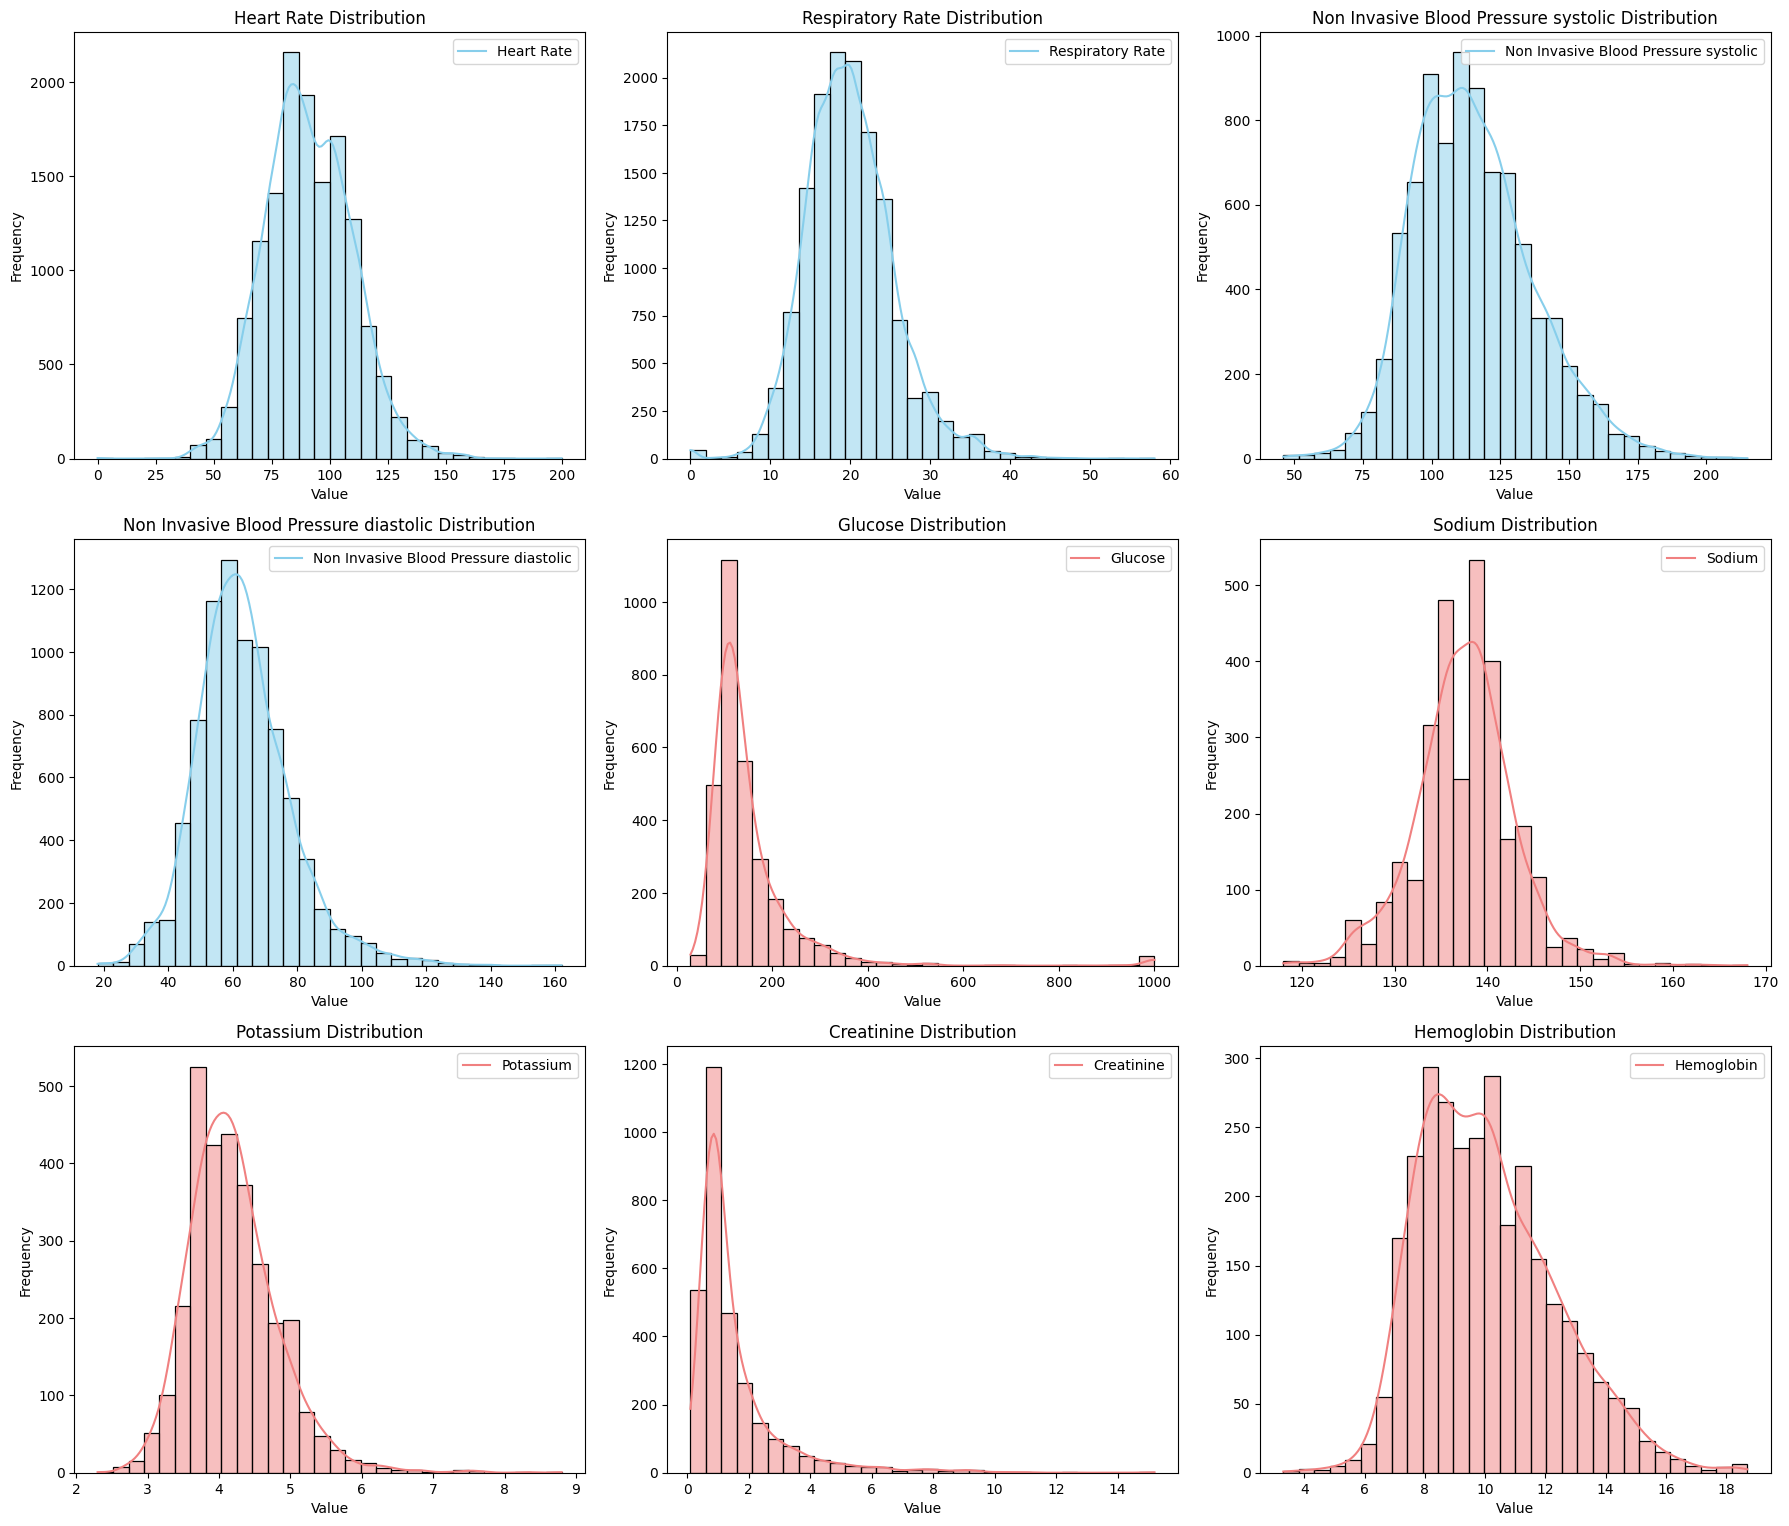


Finished generating distribution plots.


In [16]:
# Plot distributions of selected vital signs and lab measurements using merged DataFrames from Raw_data
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd

RAW = Path.cwd() / 'Data' / 'Raw_data'

# Load and merge as in previous cell (if not already in memory)
chartevents = pd.read_csv(RAW / 'chartevents.csv', low_memory=False)
d_items = pd.read_csv(RAW / 'd_items.csv', low_memory=False)
labevents = pd.read_csv(RAW / 'labevents.csv', low_memory=False)
d_labitems = pd.read_csv(RAW / 'd_labitems.csv', low_memory=False)

chartevents['itemid'] = pd.to_numeric(chartevents['itemid'], errors='coerce')
chartevents.dropna(subset=['itemid'], inplace=True)
chartevents['itemid'] = chartevents['itemid'].astype(int)
chartevents_merged = pd.merge(chartevents, d_items, on='itemid', how='left', suffixes=('_chart', '_ditem'))
chartevents_merged['valuenum'] = pd.to_numeric(chartevents_merged['valuenum'], errors='coerce')

labevents['itemid'] = pd.to_numeric(labevents['itemid'], errors='coerce')
labevents.dropna(subset=['itemid'], inplace=True)
labevents['itemid'] = labevents['itemid'].astype(int)
labevents_merged = pd.merge(labevents, d_labitems, on='itemid', how='left', suffixes=('_lab', '_dlab'))
labevents_merged['valuenum'] = pd.to_numeric(labevents_merged['valuenum'], errors='coerce')

print('Plotting Distributions of Selected Vital Signs and Lab Measurements\n')

# Define lists of labels
vital_sign_labels = [
    'Heart Rate',
    'Respiratory Rate',
    'Temperature F',
    'O2 Saturation',
    'Non Invasive Blood Pressure systolic',
    'Non Invasive Blood Pressure diastolic'
    ]
lab_measurement_labels = [
    'Glucose',
    'Sodium',
    'Potassium',
    'Creatinine',
    'Hemoglobin'
    ]

num_plots = len(vital_sign_labels) + len(lab_measurement_labels)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols
plt.figure(figsize=(num_cols * 6, num_rows * 5))
plot_index = 1

# Plot vital signs
print('Generating plots for vital signs...')
for label in vital_sign_labels:
    df_filtered = chartevents_merged[(chartevents_merged['label'] == label) & (chartevents_merged['valuenum'].notnull())]
    if not df_filtered.empty:
        plt.subplot(num_rows, num_cols, plot_index)
        sns.histplot(df_filtered['valuenum'], kde=True, bins=30, color='skyblue')
        plt.title(f'{label} Distribution')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend([label])
        plot_index += 1
    else:
        print(f"Warning: No data found for vital sign: {label}")

# Plot lab measurements
print('Generating plots for lab measurements...')
for label in lab_measurement_labels:
    df_filtered = labevents_merged[(labevents_merged['label'] == label) & (labevents_merged['valuenum'].notnull())]
    if not df_filtered.empty:
        plt.subplot(num_rows, num_cols, plot_index)
        sns.histplot(df_filtered['valuenum'], kde=True, bins=30, color='lightcoral')
        plt.title(f'{label} Distribution')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend([label])
        plot_index += 1
    else:
        print(f"Warning: No data found for lab measurement: {label}")

plt.tight_layout()
plt.show()
print('\nFinished generating distribution plots.')

In [17]:
print('Inspecting unique labels in chart_merged for vital signs\n')
from pathlib import Path
import pandas as pd

RAW = Path.cwd() / 'Data' / 'Raw_data'

# Load merged DataFrame if not already in memory
try:
    chart_merged
except NameError:
    chartevents = pd.read_csv(RAW / 'chartevents.csv', low_memory=False)
    d_items = pd.read_csv(RAW / 'd_items.csv', low_memory=False)
    chartevents['itemid'] = pd.to_numeric(chartevents['itemid'], errors='coerce')
    chartevents.dropna(subset=['itemid'], inplace=True)
    chartevents['itemid'] = chartevents['itemid'].astype(int)
    chart_merged = pd.merge(chartevents, d_items, on='itemid', how='left', suffixes=('_chart', '_ditem'))

# Filter for common vital sign categories to narrow down the search
vital_categories = ['Routine Vital Signs', 'Alarms', 'Respiratory', 'Temperature', 'Cardiovascular']

if 'category' in chart_merged.columns:
    filtered_labels_df = chart_merged[chart_merged['category'].isin(vital_categories)]
    unique_vital_labels = filtered_labels_df['label'].value_counts().reset_index()
    unique_vital_labels.columns = ['Label', 'Count']
    print("Top 50 unique labels related to vital signs in chart_merged:")
    print(unique_vital_labels.head(50))
else:
    print("Column 'category' not found in chart_merged. Available columns:")
    print(chart_merged.columns.tolist())

Inspecting unique labels in chart_merged for vital signs

Top 50 unique labels related to vital signs in chart_merged:
                                       Label  Count
0                           Respiratory Rate  13913
1                                 Heart Rate  13913
2                O2 saturation pulseoxymetry  13540
3                               Heart Rhythm  12460
4                              Ectopy Type 1  11044
5      Non Invasive Blood Pressure diastolic   8349
6       Non Invasive Blood Pressure systolic   8347
7           Non Invasive Blood Pressure mean   8342
8               Arterial Blood Pressure mean   5560
9           Arterial Blood Pressure systolic   5525
10         Arterial Blood Pressure diastolic   5524
11                          Temperature Site   3794
12                    Temperature Fahrenheit   3379
13                     O2 Delivery Device(s)   3145
14                                 Alarms On   3020
15                        Parameters Checked   29

In [18]:
# Load and merge chartevents and d_items into chart_merged from Raw_data
from pathlib import Path
import pandas as pd

RAW = Path.cwd() / 'Data' / 'Raw_data'

# Load data
chartevents = pd.read_csv(RAW / 'chartevents.csv', low_memory=False)
d_items = pd.read_csv(RAW / 'd_items.csv', low_memory=False)

# Clean and merge
chartevents['itemid'] = pd.to_numeric(chartevents['itemid'], errors='coerce')
chartevents.dropna(subset=['itemid'], inplace=True)
chartevents['itemid'] = chartevents['itemid'].astype(int)

chart_merged = pd.merge(chartevents, d_items, on='itemid', how='left', suffixes=('_chart', '_ditem'))
print('Merged chartevents and d_items into chart_merged. Shape:', chart_merged.shape)
display(chart_merged.head())

Merged chartevents and d_items into chart_merged. Shape: (668862, 19)


,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,10005817,20626031,32604416,6770.0,2132-12-16 00:00:00,2132-12-15 23:45:00,225054,On,NaN,NaN,0.0,Anti Embolic Device Status,Anti Embolic Device Status,chartevents,Treatments,NaN,Text,NaN,NaN
1,10005817,20626031,32604416,6770.0,2132-12-16 00:00:00,2132-12-15 23:43:00,223769,100,100.0,%,0.0,O2 Saturation Pulseoxymetry Alarm - High,SpO2 Alarm - High,chartevents,Alarms,%,Numeric,NaN,NaN
2,10005817,20626031,32604416,6770.0,2132-12-16 00:00:00,2132-12-15 23:47:00,223956,Atrial demand,NaN,NaN,0.0,Temporary Pacemaker Mode,Temp Pacemaker Mode,chartevents,Cardiovascular (Pacer Data),NaN,Text,NaN,NaN
3,10005817,20626031,32604416,6770.0,2132-12-16 00:00:00,2132-12-15 23:47:00,224866,Yes,NaN,NaN,0.0,Temporary Atrial Capture,Temp Atrial Capture,chartevents,Cardiovascular (Pacer Data),NaN,Text,NaN,NaN
4,10005817,20626031,32604416,6770.0,2132-12-16 00:00:00,2132-12-15 23:45:00,227341,No,0.0,NaN,0.0,History of falling (within 3 mnths),History of falling (within 3 mnths)*,chartevents,Restraint/Support Systems,NaN,Text,NaN,NaN


Identifying a sample patient for heart rate time-series analysis

Selected Sample Patient: Subject ID = 10039708, Stay ID = 33281088 with 652 Heart Rate measurements.

Prepared patient_heart_rate_data for plotting. Head of the data:
        subject_id   hadm_id   stay_id  caregiver_id           charttime            storetime  itemid value  valuenum valueuom  warning       label abbreviation      linksto             category  \
130805    10039708  28258130  33281088       28457.0 2140-01-23 19:00:00  2140-01-23 19:41:00  220045    76      76.0      bpm      0.0  Heart Rate           HR  chartevents  Routine Vital Signs   
136072    10039708  28258130  33281088       28457.0 2140-01-23 19:29:00  2140-01-23 19:29:00  220045    81      81.0      bpm      0.0  Heart Rate           HR  chartevents  Routine Vital Signs   
138792    10039708  28258130  33281088       28457.0 2140-01-23 19:45:00  2140-01-23 20:30:00  220045    71      71.0      bpm      0.0  Heart Rate           HR  chartevents

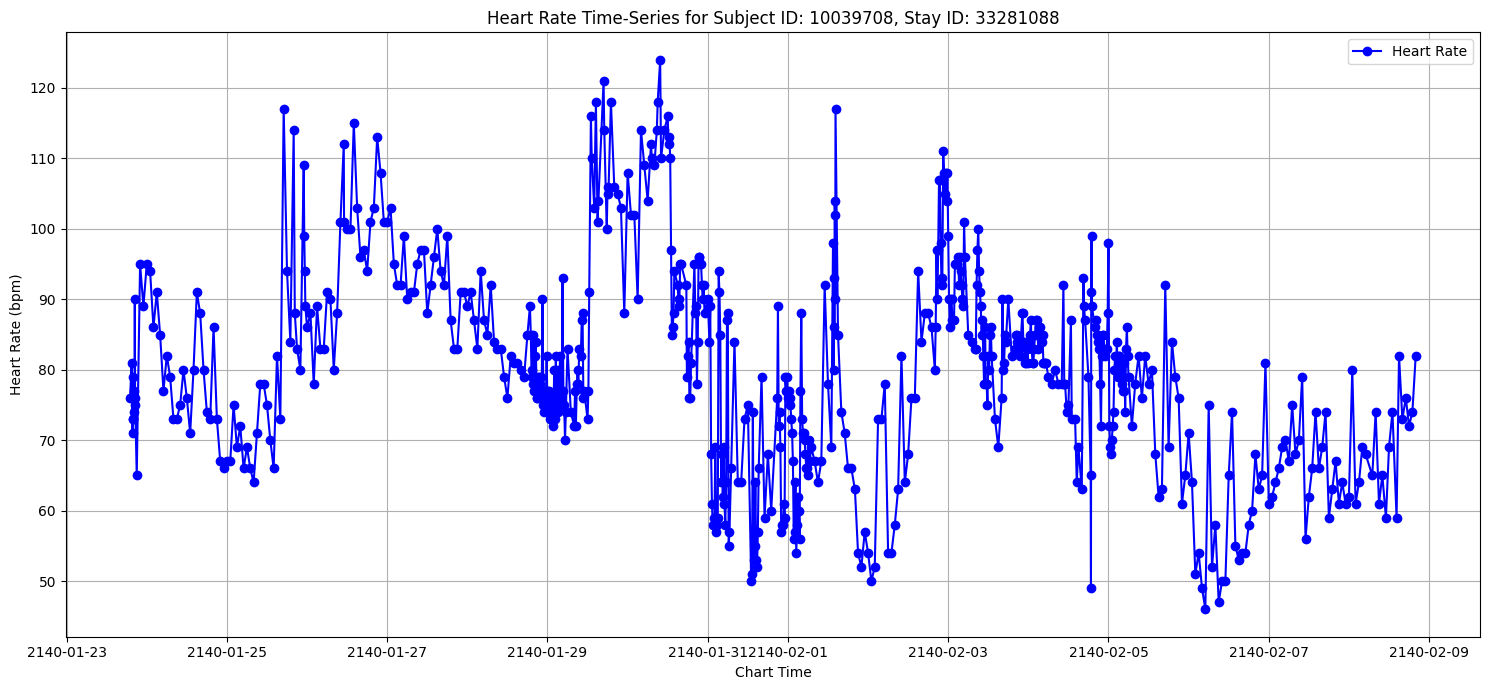

In [19]:
print('Identifying a sample patient for heart rate time-series analysis\n')

# Retrieve the merged chartevents DataFrame
chartevents['itemid'] = pd.to_numeric(chartevents['itemid'], errors='coerce')
chartevents.dropna(subset=['itemid'], inplace=True)
chartevents['itemid'] = chartevents['itemid'].astype(int)
chartevents_merged = pd.merge(chartevents, d_items, on='itemid', how='left', suffixes=('_chart', '_ditem'))
chartevents_merged['valuenum'] = pd.to_numeric(chartevents_merged['valuenum'], errors='coerce')

# Filter for Heart Rate measurements that have a numeric value
heart_rate_data = chartevents_merged[
    (chartevents_merged['label'] == 'Heart Rate') &
    (chartevents_merged['valuenum'].notnull())
]

# Count the number of heart rate measurements per patient and stay
heart_rate_counts = heart_rate_data.groupby(['subject_id', 'stay_id']).size().reset_index(name='count')

# Sort by count in descending order to find patients with many heart rate records
heart_rate_counts = heart_rate_counts.sort_values(by='count', ascending=False)

# Select a sample patient (e.g., the one with the most heart rate measurements)
if not heart_rate_counts.empty:
    sample_patient = heart_rate_counts.iloc[0]
    sample_subject_id = sample_patient['subject_id']
    sample_stay_id = sample_patient['stay_id']
    print(f"Selected Sample Patient: Subject ID = {sample_subject_id}, Stay ID = {sample_stay_id} with {sample_patient['count']} Heart Rate measurements.")

    # Filter data for the selected patient and Heart Rate label
    patient_heart_rate_data = chartevents_merged[
        (chartevents_merged['subject_id'] == sample_subject_id) &
        (chartevents_merged['stay_id'] == sample_stay_id) &
        (chartevents_merged['label'] == 'Heart Rate') &
        (chartevents_merged['valuenum'].notnull())
    ].copy() # Use .copy() to avoid SettingWithCopyWarning

    # Convert 'charttime' to datetime objects
    patient_heart_rate_data['charttime'] = pd.to_datetime(patient_heart_rate_data['charttime'])

    # Sort by charttime
    patient_heart_rate_data = patient_heart_rate_data.sort_values(by='charttime')

    print('\nPrepared patient_heart_rate_data for plotting. Head of the data:')
    print(patient_heart_rate_data.head())

    # Now plot the time-series
    plt.figure(figsize=(15, 7))
    plt.plot(patient_heart_rate_data['charttime'], patient_heart_rate_data['valuenum'], marker='o', linestyle='-', color='blue', label='Heart Rate')
    plt.title(f'Heart Rate Time-Series for Subject ID: {sample_subject_id}, Stay ID: {sample_stay_id}')
    plt.xlabel('Chart Time')
    plt.ylabel('Heart Rate (bpm)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("No heart rate data found to plot a time-series.")

Identifying and plotting the most frequent vital measurements

Top 10 Most Frequent Vital Measurements:
                                   label  count
0                        Safety Measures  19330
1                             Heart Rate  13913
2                       Respiratory Rate  13913
3            O2 saturation pulseoxymetry  13540
4                           Heart Rhythm  12460
5                          Ectopy Type 1  11044
6  Non Invasive Blood Pressure diastolic   8349
7   Non Invasive Blood Pressure systolic   8347
8       Non Invasive Blood Pressure mean   8342
9              Less Restrictive Measures   7675


C:\Users\tssmi\AppData\Local\Temp\ipykernel_21372\2994818156.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='count', data=most_frequent_measurements, palette='viridis')


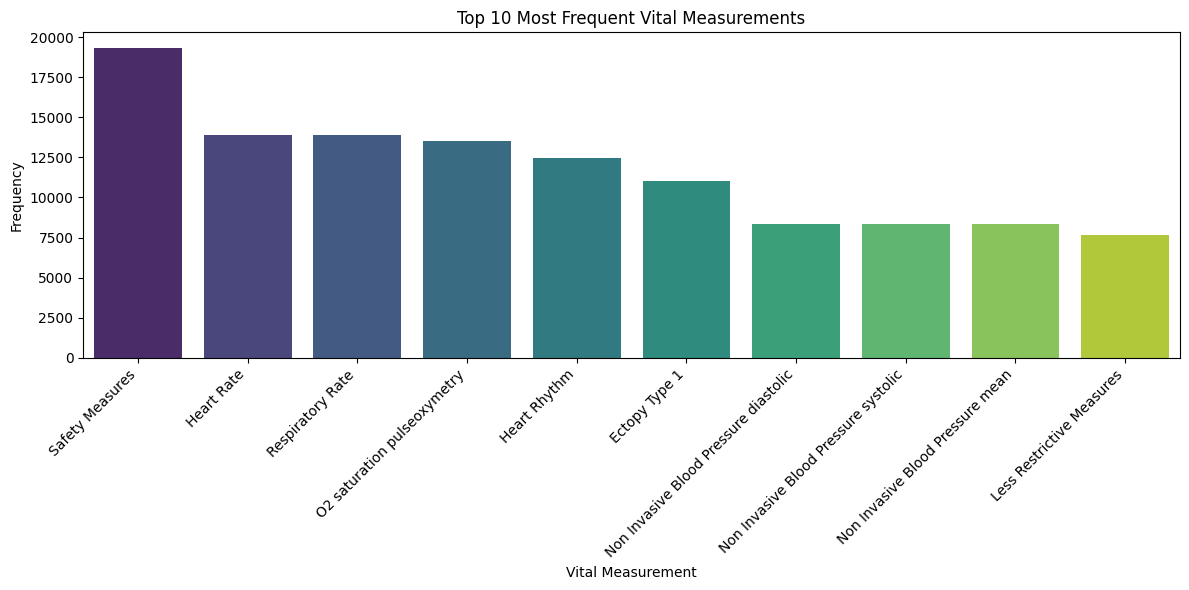


Finished plotting the most frequent vital measurements.


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

print('Identifying and plotting the most frequent vital measurements\n')

# 1. Access the 'chartevents_merged' DataFrame
chartevents['itemid'] = pd.to_numeric(chartevents['itemid'], errors='coerce')
chartevents.dropna(subset=['itemid'], inplace=True)
chartevents['itemid'] = chartevents['itemid'].astype(int)
chartevents_merged = pd.merge(chartevents, d_items, on='itemid', how='left', suffixes=('_chart', '_ditem'))
chartevents_merged['valuenum'] = pd.to_numeric(chartevents_merged['valuenum'], errors='coerce')

# 2. Count the occurrences of each unique 'label'
# Ensure only non-null labels are counted
label_counts = chartevents_merged['label'].value_counts().reset_index()
label_counts.columns = ['label', 'count']

# 3. Select the top 10 most frequent vital measurements
top_n = 10
most_frequent_measurements = label_counts.head(top_n)

print(f"Top {top_n} Most Frequent Vital Measurements:")
print(most_frequent_measurements)

# 4. Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='label', y='count', data=most_frequent_measurements, palette='viridis')

# 5. Set the plot title
plt.title(f'Top {top_n} Most Frequent Vital Measurements')

# 6. Label the x-axis and y-axis
plt.xlabel('Vital Measurement')
plt.ylabel('Frequency')

# 7. Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Ensure tight layout and display the plot
plt.tight_layout()
plt.show()

print('\nFinished plotting the most frequent vital measurements.')

Generating Correlation Map of Numerical Features from icustays DataFrame

Correlation Matrix:
            subject_id   hadm_id   stay_id       los
subject_id    1.000000  0.053632  0.055540 -0.012274
hadm_id       0.053632  1.000000 -0.053132 -0.019061
stay_id       0.055540 -0.053132  1.000000 -0.105860
los          -0.012274 -0.019061 -0.105860  1.000000


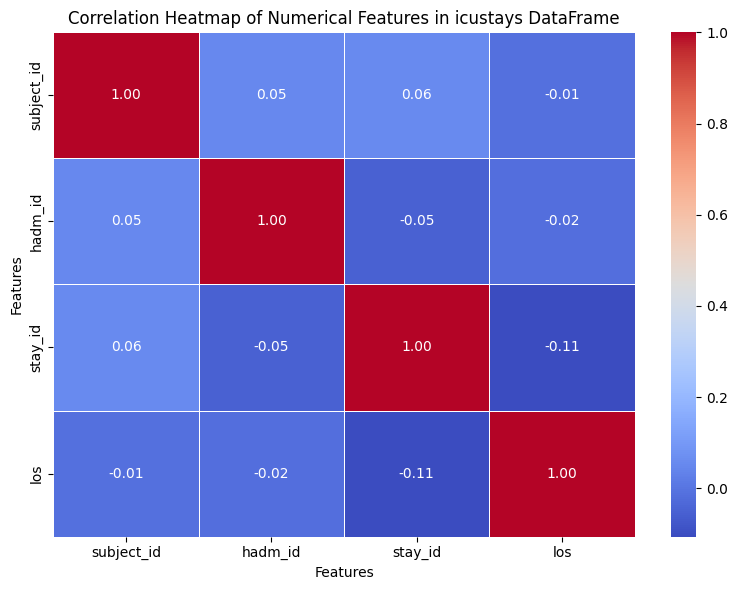

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd

print('Generating Correlation Map of Numerical Features from icustays DataFrame\n')

RAW = Path.cwd() / 'Data' / 'Raw_data'

# Load icustays DataFrame directly from Raw_data CSV
icustays_path = RAW / 'icustays.csv'
if icustays_path.exists():
    icustays_df = pd.read_csv(icustays_path, low_memory=False)
    # 2. Select all numerical columns
    numerical_cols = icustays_df.select_dtypes(include=['int64', 'float64'])
    # 3. Calculate the pairwise correlation matrix
    correlation_matrix = numerical_cols.corr()
    print("Correlation Matrix:")
    print(correlation_matrix)
    # 4. Create a heatmap of the correlation matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix,
                annot=True, # Annotate the heatmap with correlation values
                cmap='coolwarm', # Choose a diverging colormap
                fmt=".2f", # Format annotations to two decimal places
                linewidths=.5) # Add lines between cells
    plt.title('Correlation Heatmap of Numerical Features in icustays DataFrame')
    plt.xlabel('Features')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
else:
    print("icustays.csv not found in Raw_data folder.")

Generating scatter plot for stay_id vs. los (highest absolute correlation in icustays)



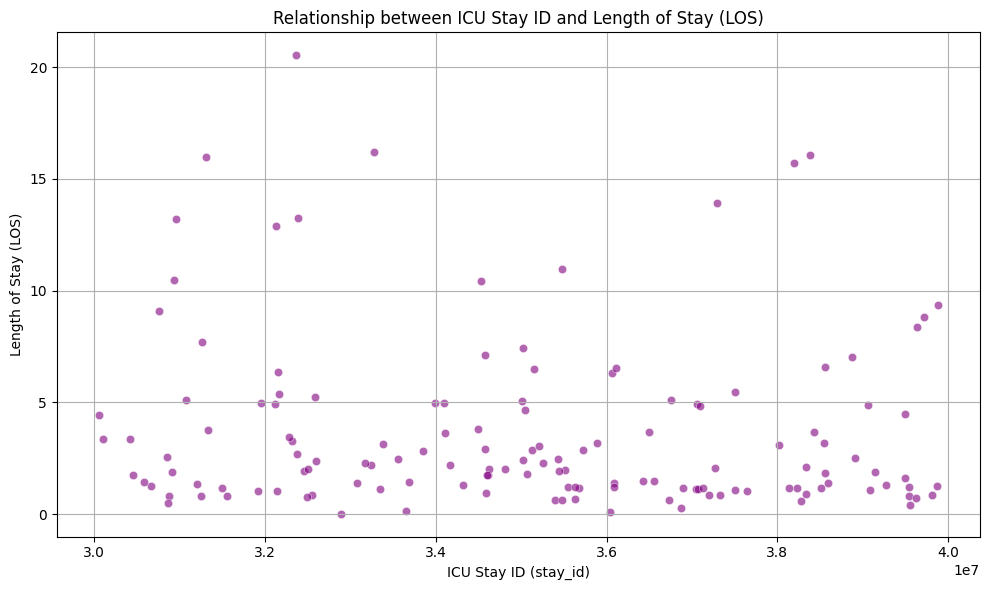

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd

print('Generating scatter plot for stay_id vs. los (highest absolute correlation in icustays)\n')

RAW = Path.cwd() / 'Data' / 'Raw_data'

# Load icustays DataFrame directly from Raw_data CSV
icustays_path = RAW / 'icustays.csv'
if icustays_path.exists():
    icustays_df = pd.read_csv(icustays_path, low_memory=False)
    if 'stay_id' in icustays_df.columns and 'los' in icustays_df.columns:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='stay_id', y='los', data=icustays_df, alpha=0.6, color='purple')
        plt.title('Relationship between ICU Stay ID and Length of Stay (LOS)')
        plt.xlabel('ICU Stay ID (stay_id)')
        plt.ylabel('Length of Stay (LOS)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Columns 'stay_id' and/or 'los' not found in icustays.csv. Available columns:")
        print(icustays_df.columns.tolist())
else:
    print("icustays.csv not found in Raw_data folder.")

In [23]:
print('Creating core_numerical_data DataFrame by merging patients, admissions, and icustays\n')
from pathlib import Path
import pandas as pd

RAW = Path.cwd() / 'Data' / 'Raw_data'

# Load the three source DataFrames
patients_path = RAW / 'patients.csv'
admissions_path = RAW / 'admissions.csv'
icustays_path = RAW / 'icustays.csv'

if patients_path.exists() and admissions_path.exists() and icustays_path.exists():
    patients = pd.read_csv(patients_path, low_memory=False)
    admissions = pd.read_csv(admissions_path, low_memory=False)
    icustays = pd.read_csv(icustays_path, low_memory=False)

    # Merge patients with admissions on subject_id
    merged_pa = pd.merge(patients, admissions, on='subject_id', how='inner')
    # Merge the result with icustays on subject_id and hadm_id
    core_numerical_data = pd.merge(merged_pa, icustays, on=['subject_id', 'hadm_id'], how='inner')

    print('Merged DataFrame shape:', core_numerical_data.shape)
    print('Head of core_numerical_data:')
    print(core_numerical_data.head())

    # Save to CSV for future use
    core_numerical_data.to_csv(RAW / 'core_numerical_data.csv', index=False)
    print('core_numerical_data.csv saved to Raw_data folder.')

    # Extract numerical features
    numerical_features = core_numerical_data.select_dtypes(include=['int64', 'float64'])
    print('Numerical features extracted. Head:')
    print(numerical_features.head())
    print('\nInfo of the numerical_features DataFrame:')
    numerical_features.info()
else:
    print('One or more source files (patients.csv, admissions.csv, icustays.csv) not found in Raw_data folder.')

Creating core_numerical_data DataFrame by merging patients, admissions, and icustays

Merged DataFrame shape: (140, 27)
Head of core_numerical_data:
   subject_id gender  anchor_age  anchor_year anchor_year_group         dod   hadm_id            admittime            dischtime            deathtime               admission_type admit_provider_id  \
0    10014729      F          21         2125       2011 - 2013         NaN  28889419  2125-02-27 07:15:00  2125-03-06 14:25:00                  NaN  SURGICAL SAME DAY ADMISSION            P17BJ5   
1    10003400      F          72         2134       2011 - 2013  2137-09-02  23559586  2137-08-04 00:07:00  2137-09-02 17:05:00  2137-09-02 17:05:00                       URGENT            P99U21   
2    10003400      F          72         2134       2011 - 2013  2137-09-02  23559586  2137-08-04 00:07:00  2137-09-02 17:05:00  2137-09-02 17:05:00                       URGENT            P99U21   
3    10003400      F          72         2134       201

In [24]:
print('Extracting numerical features from core_numerical_data for correlation analysis\n')

# Retrieve the consolidated DataFrame

# Select only the numerical columns for correlation analysis
numerical_features = core_numerical_data.select_dtypes(include=['int64', 'float64'])

print("Numerical features extracted. Head of the numerical_features DataFrame:")
print(numerical_features.head())
print("\nInfo of the numerical_features DataFrame:")
numerical_features.info()



Extracting numerical features from core_numerical_data for correlation analysis

Numerical features extracted. Head of the numerical_features DataFrame:
   subject_id  anchor_age  anchor_year   hadm_id  hospital_expire_flag   stay_id        los
0    10014729          21         2125  28889419                     0  33558396   2.471169
1    10003400          72         2134  23559586                     1  38383343  16.069838
2    10003400          72         2134  23559586                     1  34577403   2.916701
3    10003400          72         2134  20214994                     0  32128372  12.911308
4    10002428          80         2155  28662225                     0  38875437   7.032894

Info of the numerical_features DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject_id            140 non-null    int

Generating Correlation Map of Numerical Features from core_numerical_numerical DataFrame

Overall Correlation Matrix:
                      subject_id  anchor_age  anchor_year   hadm_id  hospital_expire_flag   stay_id       los
subject_id              1.000000   -0.016434    -0.062668  0.053632             -0.008470  0.055540 -0.012274
anchor_age             -0.016434    1.000000     0.065348  0.040246              0.193528  0.021988  0.006159
anchor_year            -0.062668    0.065348     1.000000 -0.020436             -0.114685  0.081492 -0.095937
hadm_id                 0.053632    0.040246    -0.020436  1.000000             -0.067512 -0.053132 -0.019061
hospital_expire_flag   -0.008470    0.193528    -0.114685 -0.067512              1.000000  0.003176  0.236396
stay_id                 0.055540    0.021988     0.081492 -0.053132              0.003176  1.000000 -0.105860
los                    -0.012274    0.006159    -0.095937 -0.019061              0.236396 -0.105860  1.000000


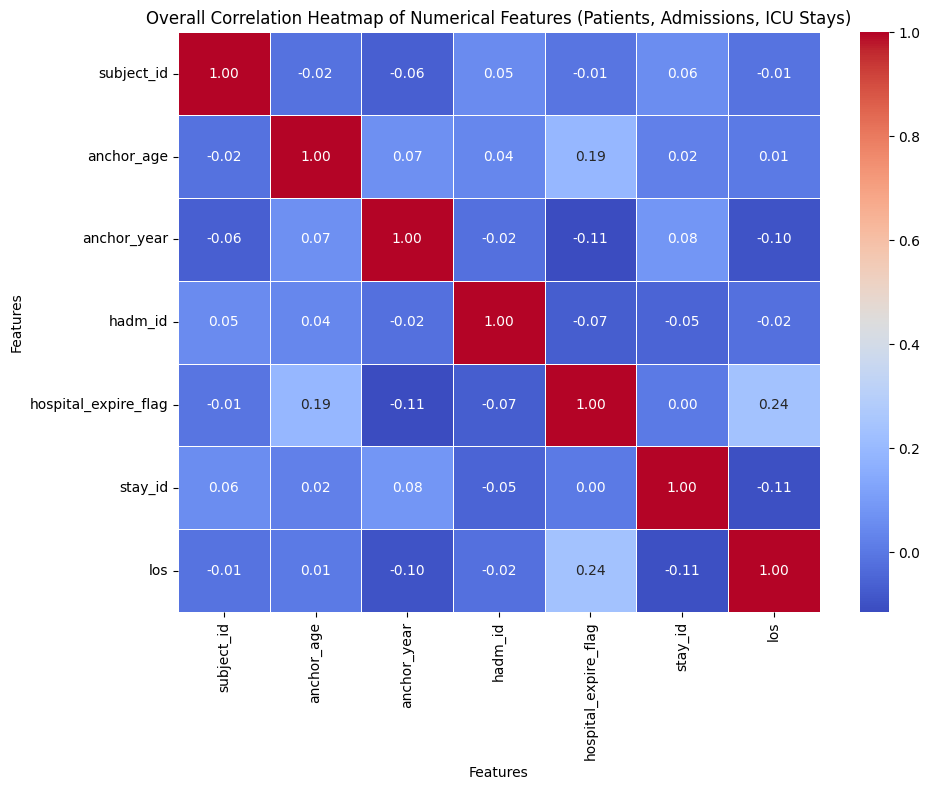

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

print('Generating Correlation Map of Numerical Features from core_numerical_numerical DataFrame\n')

# Retrieve the numerical features DataFrame
# Select only the numerical columns for correlation analysis
numerical_features_df = core_numerical_data.select_dtypes(include=['int64', 'float64'])

# Calculate the pairwise correlation matrix
correlation_matrix_overall = numerical_features_df.corr()

print("Overall Correlation Matrix:")
print(correlation_matrix_overall)

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8)) # Adjusted figure size for better readability
sns.heatmap(correlation_matrix_overall,
            annot=True, # Annotate the heatmap with correlation values
            cmap='coolwarm', # Choose a diverging colormap
            fmt=".2f", # Format annotations to two decimal places
            linewidths=.5) # Add lines between cells

plt.title('Overall Correlation Heatmap of Numerical Features (Patients, Admissions, ICU Stays)')
plt.xlabel('Features')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


Generating scatter plots for positively correlated identifier variables



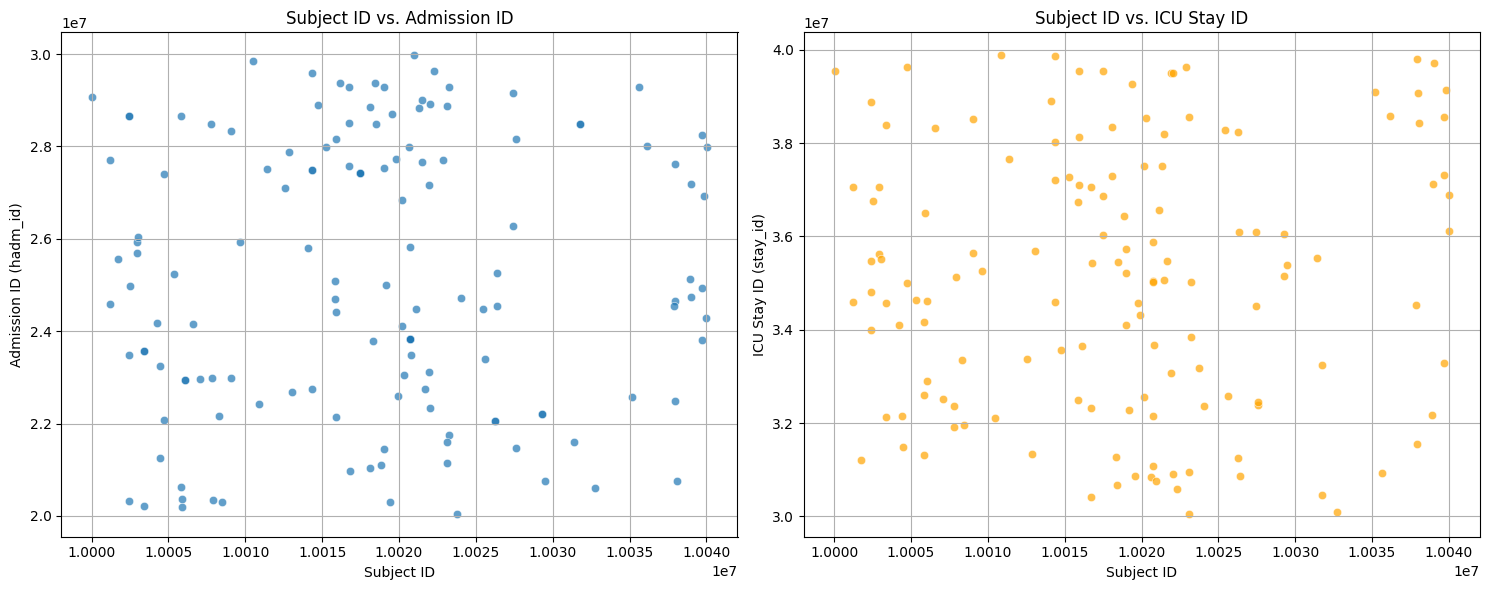

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

print('Generating scatter plots for positively correlated identifier variables\n')



plt.figure(figsize=(15, 6))

# Plot 1: subject_id vs hadm_id
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
sns.scatterplot(x='subject_id', y='hadm_id', data=numerical_features_df, alpha=0.7)
plt.title('Subject ID vs. Admission ID')
plt.xlabel('Subject ID')
plt.ylabel('Admission ID (hadm_id)')
plt.grid(True)

# Plot 2: subject_id vs stay_id
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
sns.scatterplot(x='subject_id', y='stay_id', data=numerical_features_df, alpha=0.7, color='orange')
plt.title('Subject ID vs. ICU Stay ID')
plt.xlabel('Subject ID')
plt.ylabel('ICU Stay ID (stay_id)')
plt.grid(True)

plt.tight_layout()
plt.show()


Generating visualizations for hospital_expire_flag vs. los



C:\Users\tssmi\AppData\Local\Temp\ipykernel_21372\601631318.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hospital_expire_flag', y='los', data=numerical_features_df, palette='viridis')
C:\Users\tssmi\AppData\Local\Temp\ipykernel_21372\601631318.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='hospital_expire_flag', y='los', data=numerical_features_df, jitter=0.2, alpha=0.6, palette='viridis')


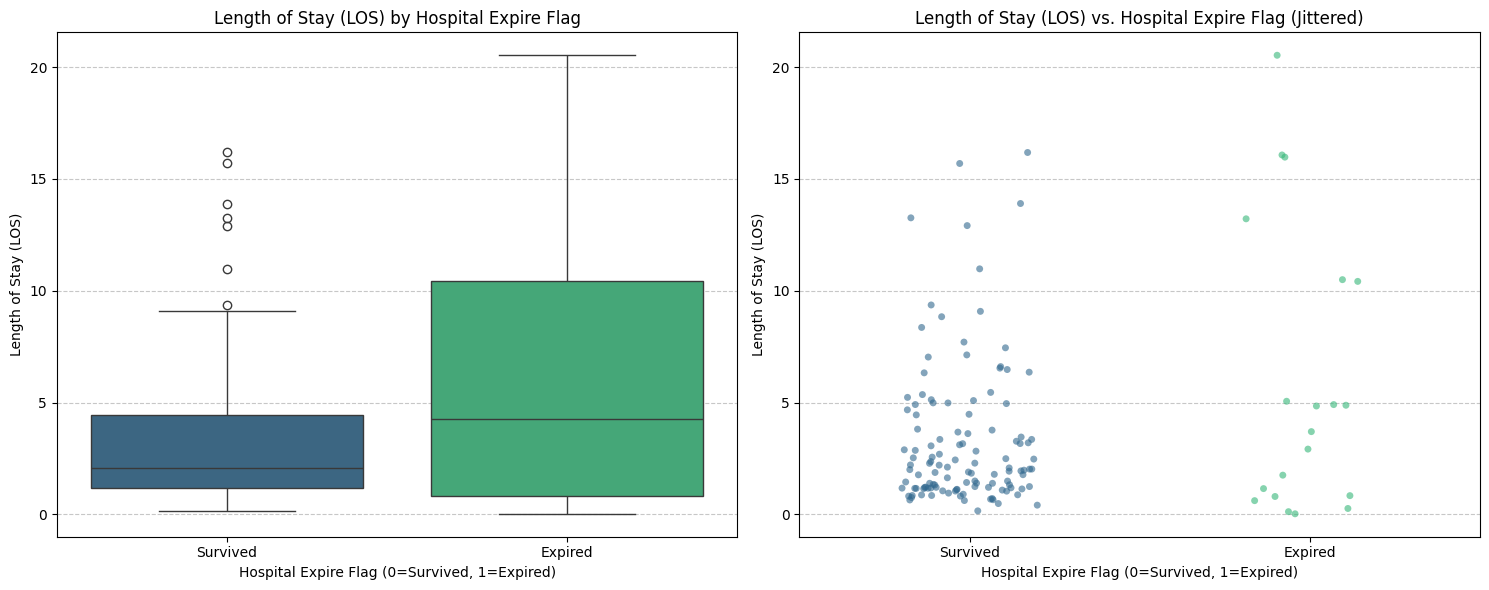

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

print('Generating visualizations for hospital_expire_flag vs. los\n')
plt.figure(figsize=(15, 6))
# Plot 1: Box Plot of LOS by Hospital Expire Flag
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
sns.boxplot(x='hospital_expire_flag', y='los', data=numerical_features_df, palette='viridis')
plt.title('Length of Stay (LOS) by Hospital Expire Flag')
plt.xlabel('Hospital Expire Flag (0=Survived, 1=Expired)')
plt.ylabel('Length of Stay (LOS)')
plt.xticks([0, 1], ['Survived', 'Expired'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Scatter Plot of LOS vs. Hospital Expire Flag with jitter
# Jitter is added to x-axis for better visualization of overlapping points
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
sns.stripplot(x='hospital_expire_flag', y='los', data=numerical_features_df, jitter=0.2, alpha=0.6, palette='viridis')
plt.title('Length of Stay (LOS) vs. Hospital Expire Flag (Jittered)')
plt.xlabel('Hospital Expire Flag (0=Survived, 1=Expired)')
plt.ylabel('Length of Stay (LOS)')
plt.xticks([0, 1], ['Survived', 'Expired'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



In [28]:
# 1. Load the DataFrames from CSV files
patients_df = pd.read_csv(RAW / 'patients.csv', low_memory=False)
admissions_df = pd.read_csv(RAW / 'admissions.csv', low_memory=False)
icustays_df = pd.read_csv(RAW / 'icustays.csv', low_memory=False)

# 2. Merge 'patients' with 'admissions' on 'subject_id'
merged_patients_admissions = pd.merge(patients_df,
                                      admissions_df,
                                      on='subject_id',
                                      how='inner',
                                      suffixes=('_pat', '_adm'))
print("Merged 'patients' and 'admissions' to create 'merged_patients_admissions'.")

# 3. Merge 'merged_patients_admissions' with 'icustays' on 'subject_id' and 'hadm_id'
core_numerical_data = pd.merge(merged_patients_admissions,
                               icustays_df,
                               on=['subject_id', 'hadm_id'],
                               how='inner',
                               suffixes=('_merged', '_icu'))
print("Merged 'merged_patients_admissions' and 'icustays' to create 'core_numerical_data'.")

# 4. Display the first few rows of the 'core_numerical_data' DataFrame
print('\n--- core_numerical_data (Head) ---')
print(core_numerical_data.head())

# 5. Print a concise summary (info()) of the 'core_numerical_data' DataFrame
print('\n--- core_numerical_data (Info) ---')
core_numerical_data.info()


Merged 'patients' and 'admissions' to create 'merged_patients_admissions'.
Merged 'merged_patients_admissions' and 'icustays' to create 'core_numerical_data'.

--- core_numerical_data (Head) ---
   subject_id gender  anchor_age  anchor_year anchor_year_group         dod   hadm_id            admittime            dischtime            deathtime               admission_type admit_provider_id  \
0    10014729      F          21         2125       2011 - 2013         NaN  28889419  2125-02-27 07:15:00  2125-03-06 14:25:00                  NaN  SURGICAL SAME DAY ADMISSION            P17BJ5   
1    10003400      F          72         2134       2011 - 2013  2137-09-02  23559586  2137-08-04 00:07:00  2137-09-02 17:05:00  2137-09-02 17:05:00                       URGENT            P99U21   
2    10003400      F          72         2134       2011 - 2013  2137-09-02  23559586  2137-08-04 00:07:00  2137-09-02 17:05:00  2137-09-02 17:05:00                       URGENT            P99U21   
3    1000

Generating visualizations for anchor_age vs. hospital_expire_flag



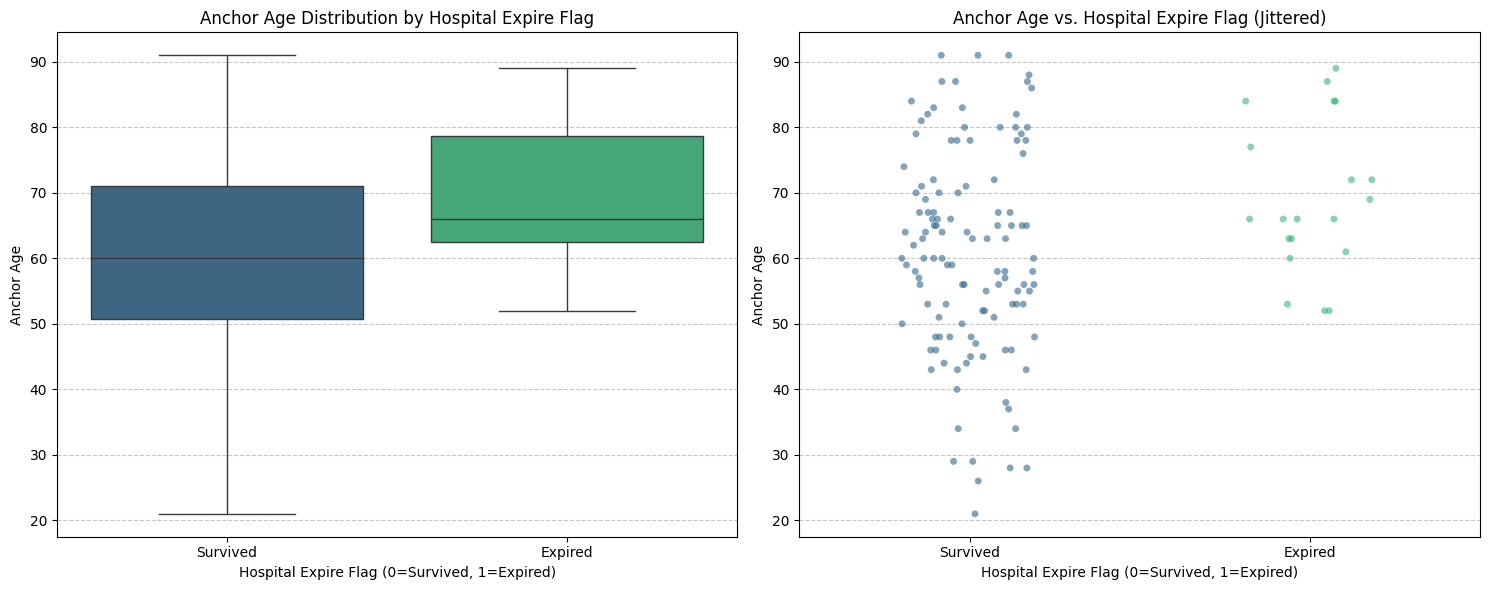

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

print('Generating visualizations for anchor_age vs. hospital_expire_flag\n')
plt.figure(figsize=(15, 6))
# Plot 1: Box Plot of Anchor Age by Hospital Expire Flag
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
sns.boxplot(x='hospital_expire_flag', y='anchor_age', data=numerical_features_df, palette='viridis', hue='hospital_expire_flag', legend=False)
plt.title('Anchor Age Distribution by Hospital Expire Flag')
plt.xlabel('Hospital Expire Flag (0=Survived, 1=Expired)')
plt.ylabel('Anchor Age')
plt.xticks([0, 1], ['Survived', 'Expired'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Scatter Plot of Anchor Age vs. Hospital Expire Flag with jitter
# Jitter is added to x-axis for better visualization of overlapping points
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
sns.stripplot(x='hospital_expire_flag', y='anchor_age', data=numerical_features_df, jitter=0.2, alpha=0.6, palette='viridis', hue='hospital_expire_flag', legend=False)
plt.title('Anchor Age vs. Hospital Expire Flag (Jittered)')
plt.xlabel('Hospital Expire Flag (0=Survived, 1=Expired)')
plt.ylabel('Anchor Age')
plt.xticks([0, 1], ['Survived', 'Expired'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


C:\Users\tssmi\AppData\Local\Temp\ipykernel_21372\2451188951.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='BMI_Category', data=bmi_data, order=['Underweight', 'Normal', 'Overweight', 'Obese'], palette='viridis')


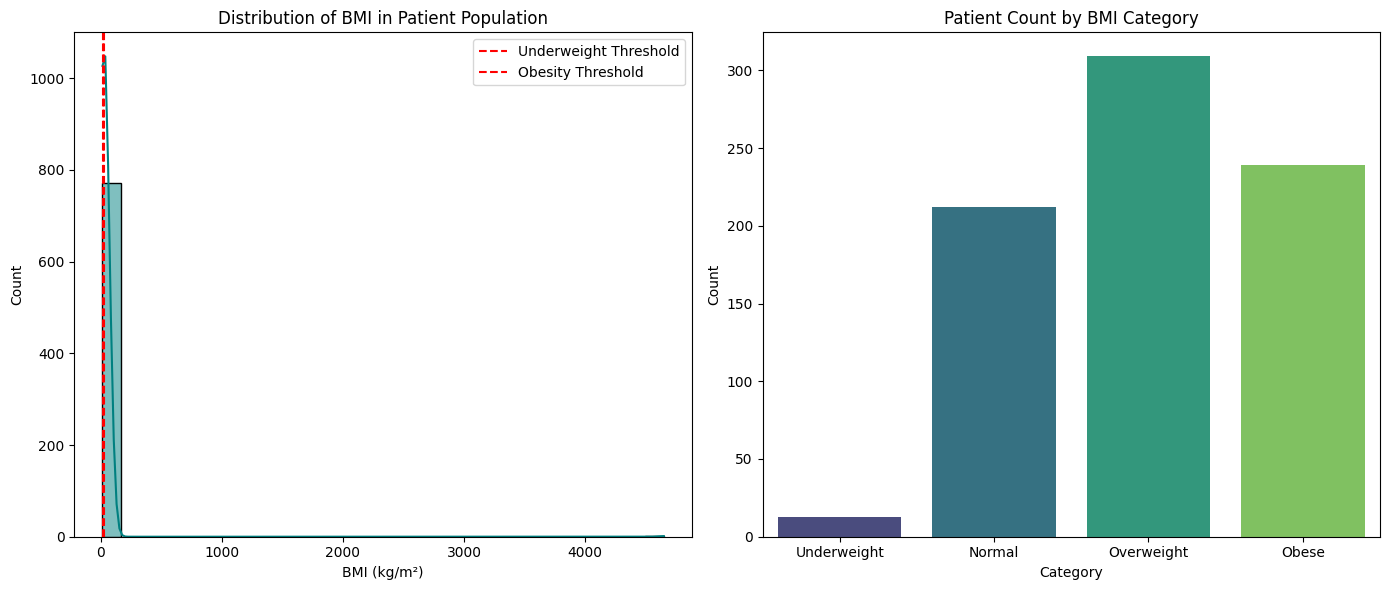

Meaningful Insight: This tells us the class imbalance. If most patients are Obese, your model will be biased towards weight-loss diets.


In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Setup paths
RAW = Path.cwd() / 'Data' / 'Raw_data'

# Load OMR (Outpatient Medical Record) for Weight/Height/BMI
omr = pd.read_csv(RAW / 'omr.csv', low_memory=False)

# Filter for BMI records
bmi_data = omr[omr['result_name'].str.contains('BMI', case=False, na=False)].copy()
bmi_data['result_value'] = pd.to_numeric(bmi_data['result_value'], errors='coerce')
bmi_data = bmi_data.dropna(subset=['result_value'])

# Classify BMI
def classify_bmi(bmi):
    if bmi < 18.5: return 'Underweight'
    elif 18.5 <= bmi < 25: return 'Normal'
    elif 25 <= bmi < 30: return 'Overweight'
    else: return 'Obese'

bmi_data['BMI_Category'] = bmi_data['result_value'].apply(classify_bmi)

# Visualization
plt.figure(figsize=(14, 6))

# Plot 1: Distribution
plt.subplot(1, 2, 1)
sns.histplot(bmi_data['result_value'], bins=30, kde=True, color='teal')
plt.title('Distribution of BMI in Patient Population')
plt.xlabel('BMI (kg/m²)')
plt.axvline(18.5, color='r', linestyle='--', label='Underweight Threshold')
plt.axvline(30, color='r', linestyle='--', label='Obesity Threshold')
plt.legend()

# Plot 2: Categories Count
plt.subplot(1, 2, 2)
sns.countplot(x='BMI_Category', data=bmi_data, order=['Underweight', 'Normal', 'Overweight', 'Obese'], palette='viridis')
plt.title('Patient Count by BMI Category')
plt.xlabel('Category')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

print("Meaningful Insight: This tells us the class imbalance. If most patients are Obese, your model will be biased towards weight-loss diets.")

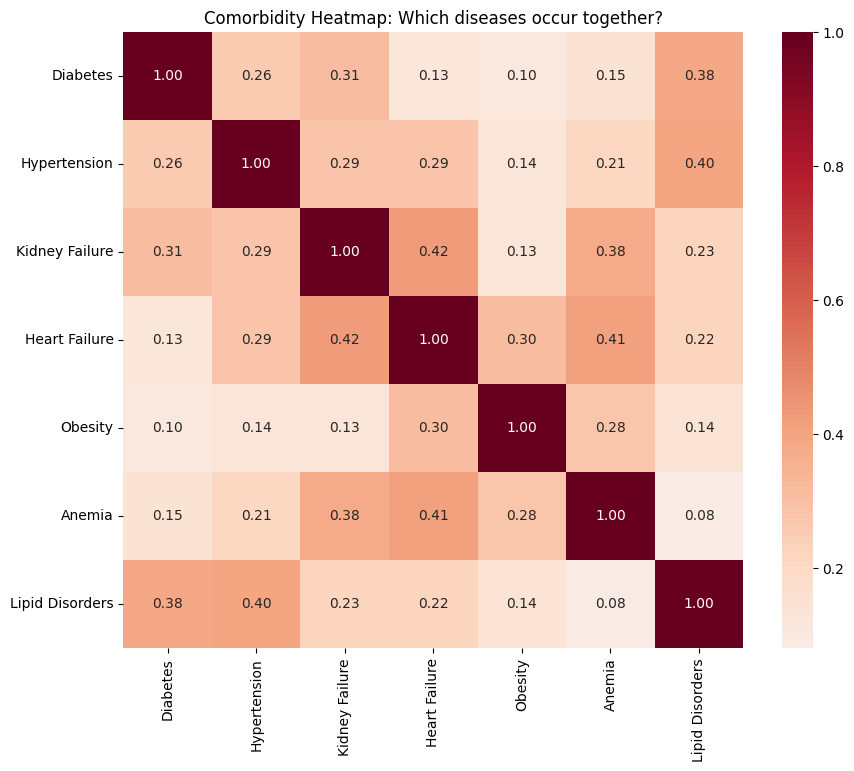

Meaningful Insight: High correlation (red squares) means you need 'Combination Diets' (e.g., Renal Diabetic Diet).


In [31]:
# Load Diagnoses
diagnoses = pd.read_csv(RAW / 'diagnoses_icd.csv', low_memory=False)
d_icd = pd.read_csv(RAW / 'd_icd_diagnoses.csv', low_memory=False)

# Merge to get names
diag_merged = pd.merge(diagnoses, d_icd, on=['icd_code', 'icd_version'], how='left')

# Define keywords for key nutritional diseases
disease_keywords = {
    'Diabetes': 'diabet',
    'Hypertension': 'hypertens',
    'Kidney Failure': 'kidney',
    'Heart Failure': 'heart failure',
    'Obesity': 'obesity',
    'Anemia': 'anemia',
    'Lipid Disorders': 'cholesterol|hyperlipidemia'
}

# Create a matrix of Patient x Disease
patient_diseases = pd.DataFrame(index=diag_merged['subject_id'].unique())

for disease, keyword in disease_keywords.items():
    # Find patients with this disease
    patients_with_disease = diag_merged[
        diag_merged['long_title'].str.contains(keyword, case=False, na=False)
    ]['subject_id'].unique()
    
    # Mark as 1
    patient_diseases[disease] = 0
    patient_diseases.loc[patients_with_disease, disease] = 1

# Calculate Correlation (Phi coefficient equivalent for binary data)
disease_corr = patient_diseases.corr()

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(disease_corr, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
plt.title('Comorbidity Heatmap: Which diseases occur together?')
plt.show()

print("Meaningful Insight: High correlation (red squares) means you need 'Combination Diets' (e.g., Renal Diabetic Diet).")

Please ensure omr.csv is in the folder


C:\Users\tssmi\AppData\Local\Temp\ipykernel_21372\3289981546.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Comorbidity_Score', y='result_value', data=bmi_merged, palette='Reds')


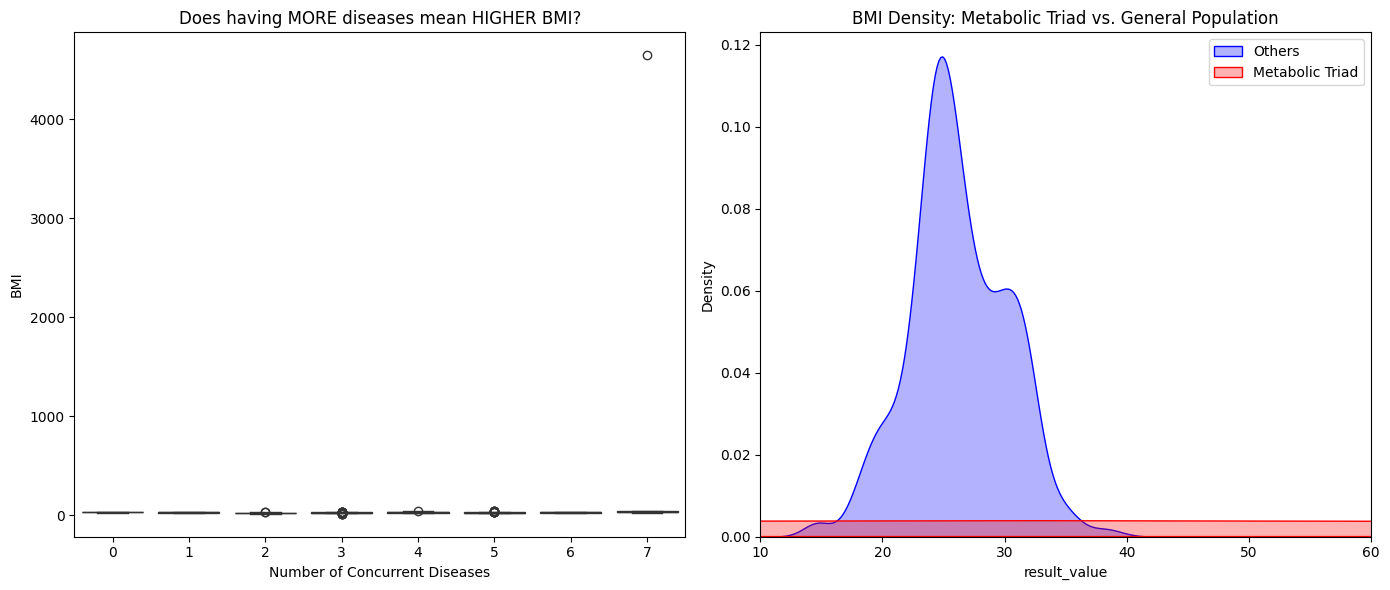

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

try:
    omr = pd.read_csv('omr.csv', low_memory=False)
except:
    print("Please ensure omr.csv is in the folder")

# 1. Create a "Comorbidity Score"
# Summing the rows gives us how many diseases each patient has
patient_diseases['Comorbidity_Score'] = patient_diseases.sum(axis=1)

# 2. Identify the "Metabolic Syndrome" Group
# Patients who have Diabetes AND Hypertension AND Obesity
patient_diseases['Has_Metabolic_Syndrome'] = (
    (patient_diseases['Diabetes'] == 1) & 
    (patient_diseases['Hypertension'] == 1) & 
    (patient_diseases['Obesity'] == 1)
).astype(int)

# 3. Merge with BMI Data (from OMR)
bmi_data = omr[omr['result_name'].str.contains('BMI', case=False, na=False)].copy()
bmi_data['result_value'] = pd.to_numeric(bmi_data['result_value'], errors='coerce')
bmi_merged = pd.merge(patient_diseases, bmi_data, left_index=True, right_on='subject_id', how='inner')

# --- VISUALIZATION ---
plt.figure(figsize=(14, 6))

# Plot A: BMI vs. Number of Comorbidities
plt.subplot(1, 2, 1)
sns.boxplot(x='Comorbidity_Score', y='result_value', data=bmi_merged, palette='Reds')
plt.title('Does having MORE diseases mean HIGHER BMI?')
plt.xlabel('Number of Concurrent Diseases')
plt.ylabel('BMI')

# Plot B: Metabolic Syndrome vs. The Rest
plt.subplot(1, 2, 2)
sns.kdeplot(data=bmi_merged[bmi_merged['Has_Metabolic_Syndrome']==0], x='result_value', fill=True, color='blue', label='Others', alpha=0.3)
sns.kdeplot(data=bmi_merged[bmi_merged['Has_Metabolic_Syndrome']==1], x='result_value', fill=True, color='red', label='Metabolic Triad', alpha=0.3)
plt.title('BMI Density: Metabolic Triad vs. General Population')
plt.legend()
plt.xlim(10, 60) # Limit x-axis to remove extreme outliers

plt.tight_layout()
plt.show()



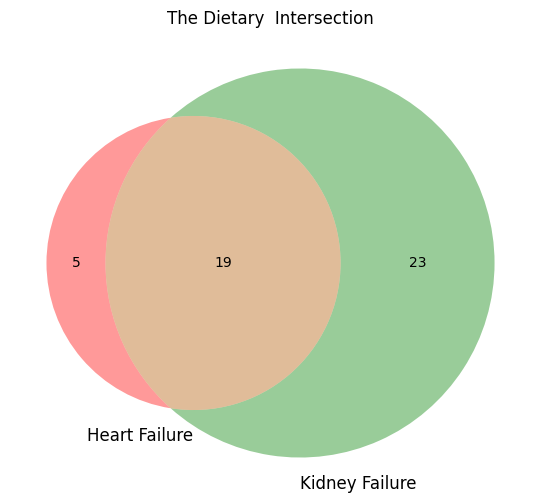

Deep Insight: There are 19 patients in the intersection. These patients usually require:
1. Low Sodium (<2g)
2. Low Potassium (No bananas/potatoes)
3. Fluid Restriction (<1.5L)


In [33]:
!pip install matplotlib-venn
from matplotlib_venn import venn2
# 1. Isolate the groups
patient_diseases['CardioRenal'] = (
    (patient_diseases['Heart Failure'] == 1) & 
    (patient_diseases['Kidney Failure'] == 1)
).astype(int)

# Count the groups
group_counts = patient_diseases['CardioRenal'].value_counts()

# 2. Visualization of the Intersection
plt.figure(figsize=(8, 6))
from matplotlib_venn import venn2

# Calculate sets
only_heart = patient_diseases[(patient_diseases['Heart Failure']==1) & (patient_diseases['Kidney Failure']==0)].shape[0]
only_kidney = patient_diseases[(patient_diseases['Heart Failure']==0) & (patient_diseases['Kidney Failure']==1)].shape[0]
both = patient_diseases[(patient_diseases['Heart Failure']==1) & (patient_diseases['Kidney Failure']==1)].shape[0]

try:
    venn2(subsets = (only_heart, only_kidney, both), set_labels = ('Heart Failure', 'Kidney Failure'))
    plt.title("The Dietary  Intersection")
    plt.show()
    print(f"Deep Insight: There are {both} patients in the intersection. These patients usually require:")
    print("1. Low Sodium (<2g)")
    print("2. Low Potassium (No bananas/potatoes)")
    print("3. Fluid Restriction (<1.5L)")
except:
    print("Matplotlib-venn not installed, skipping Venn diagram.")

C:\Users\tssmi\AppData\Local\Temp\ipykernel_21372\3363862616.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Patient_Type', y='valuenum', data=lab_merged, palette='Set2', order=['Healthy', 'Diabetes Only', 'Diabetic Nephropathy'])


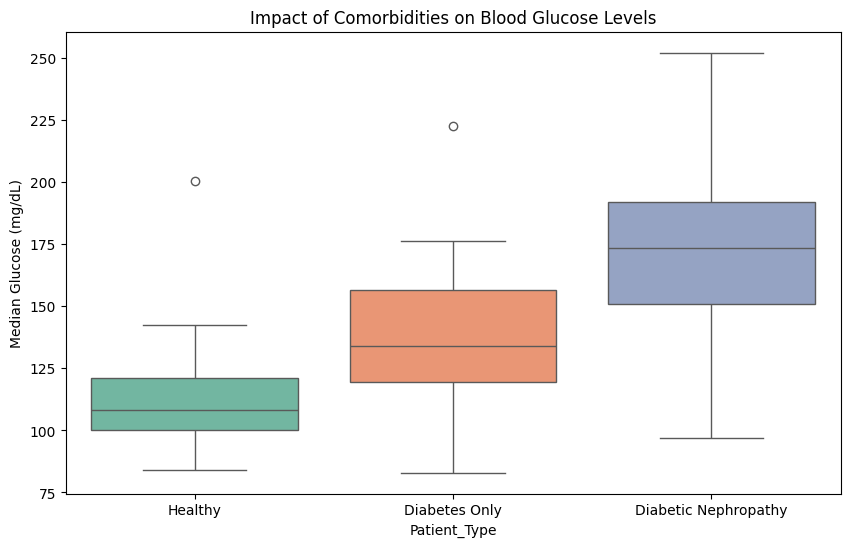

Deep Insight: Look at the 'Diabetic Nephropathy' box. If it is higher or wider than 'Diabetes Only', it proves that multi-condition patients have more volatile metabolism, requiring stricter AI diet controls.


In [34]:
# Load Lab Data (if not loaded)
try:
    labevents = pd.read_csv('C:\\Users\\tssmi\\OneDrive\\Desktop\\AINutricare\\Notebooks\\Data\\Raw_data\\labevents.csv', low_memory=False)
except:
    print("Check labevents.csv")

# 1. Filter for Glucose (Item ID 50931 is typically Serum Glucose)
glucose_lab = labevents[labevents['itemid'] == 50931].copy()
glucose_lab['valuenum'] = pd.to_numeric(glucose_lab['valuenum'], errors='coerce')
glucose_lab = glucose_lab.dropna(subset=['valuenum'])

# 2. Merge with Patient Diseases
# We take the MEDIAN glucose per patient to avoid noise
avg_glucose = glucose_lab.groupby('subject_id')['valuenum'].median().reset_index()
lab_merged = pd.merge(patient_diseases, avg_glucose, left_index=True, right_on='subject_id', how='inner')

# 3. Compare Groups
# We will compare: No Diabetes vs. Diabetes Only vs. Diabetes + Kidney Failure
def categorize_patient(row):
    if row['Diabetes'] == 0: return 'Healthy'
    if row['Diabetes'] == 1 and row['Kidney Failure'] == 0: return 'Diabetes Only'
    if row['Diabetes'] == 1 and row['Kidney Failure'] == 1: return 'Diabetic Nephropathy'
    return 'Other'

lab_merged['Patient_Type'] = lab_merged.apply(categorize_patient, axis=1)
lab_merged = lab_merged[lab_merged['Patient_Type'] != 'Other']

# Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='Patient_Type', y='valuenum', data=lab_merged, palette='Set2', order=['Healthy', 'Diabetes Only', 'Diabetic Nephropathy'])
plt.title('Impact of Comorbidities on Blood Glucose Levels')
plt.ylabel('Median Glucose (mg/dL)')
plt.show()

print("Deep Insight: Look at the 'Diabetic Nephropathy' box. If it is higher or wider than 'Diabetes Only', it proves that multi-condition patients have more volatile metabolism, requiring stricter AI diet controls.")

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore
# CONFIGURATION & DATA LOADING
IQR_MULTIPLIER = 1.5
Z_SCORE_THRESHOLD = 3.0
CONTAMINATION_RATE = 0.05 

# Load Data (Assuming files are in 'Data/Raw_data/' folder relative to script)
try:
    omr = pd.read_csv('Data/Raw_data/omr.csv', low_memory=False)
    labevents = pd.read_csv('Data/Raw_data/labevents.csv', low_memory=False)
    icustays = pd.read_csv('Data/Raw_data/icustays.csv', low_memory=False)
    patients = pd.read_csv('Data/Raw_data/patients.csv', low_memory=False)
    print(" Datasets loaded successfully.")
except FileNotFoundError as e:
    print(f" Error loading data: {e}")
    exit()

# ==========================================
# MODULE 1: PREPROCESSING FUNCTIONS
# ==========================================
def extract_bmi(omr_df):
    """Clean and extract BMI values."""
    df = omr_df[omr_df['result_name'].str.contains('BMI', case=False, na=False)].copy()
    df['result_value'] = pd.to_numeric(df['result_value'], errors='coerce')
    df = df.dropna(subset=['result_value'])
    return df[['subject_id', 'result_value']].rename(columns={'result_value': 'BMI'})

def extract_glucose(lab_df):
    """Clean and extract Serum Glucose (Item 50931)."""
    df = lab_df[lab_df['itemid'] == 50931].copy()
    df['valuenum'] = pd.to_numeric(df['valuenum'], errors='coerce')
    df = df.dropna(subset=['valuenum'])
    return df[['subject_id', 'valuenum']].rename(columns={'valuenum': 'Glucose'})

def extract_los(icu_df):
    """Extract Length of Stay."""
    return icu_df[['subject_id', 'los']].copy().rename(columns={'los': 'LOS'})

 Datasets loaded successfully.


In [36]:
def detect_outliers_iqr(df, column):
    """
    Detects outliers using the Interquartile Range (IQR) method.
    Best for skewed data like LOS or Glucose.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (IQR_MULTIPLIER * IQR)
    upper_bound = Q3 + (IQR_MULTIPLIER * IQR)
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"--- IQR Method for {column} ---")
    print(f"Bounds: {lower_bound:.2f} to {upper_bound:.2f}")
    print(f"Outliers detected: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
    return outliers

def detect_outliers_zscore(df, column):
    """
    Detects outliers using Z-Score.
    Best for normally distributed data (often Age or Height).
    """
    df['z_score'] = zscore(df[column])
    outliers = df[abs(df['z_score']) > Z_SCORE_THRESHOLD]
    
    print(f"\n--- Z-Score Method for {column} ---")
    print(f"Threshold: Z > {Z_SCORE_THRESHOLD}")
    print(f"Outliers detected: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
    return outliers

def detect_outliers_isolation_forest(df, columns):
    """
    Uses Unsupervised ML (Isolation Forest) to find anomalies in multi-dimensional space.
    e.g., A patient with BMI=20 (Normal) but Glucose=500 (Extreme) is a multivariate outlier.
    """
    iso = IsolationForest(contamination=CONTAMINATION_RATE, random_state=42)
    df['anomaly_score'] = iso.fit_predict(df[columns])
    
    # -1 indicates outlier, 1 indicates normal
    outliers = df[df['anomaly_score'] == -1]
    print(f"\n--- Isolation Forest (ML) for {columns} ---")
    print(f"Outliers detected: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
    return outliers

In [37]:
def plot_outlier_deep_dive(df, column, outlier_df, method_name):
    """
    Generates a 3-panel MNC-style report plot:
    1. Histogram with Outlier Regions highlighted.
    2. Boxplot (Standard check).
    3. Scatterplot (Visualizing the density of outliers).
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Histogram
    sns.histplot(df[column], bins=50, kde=True, ax=axes[0], color='skyblue', label='Normal')
    sns.histplot(outlier_df[column], bins=50, kde=False, ax=axes[0], color='red', label='Outliers')
    axes[0].set_title(f'{column} Distribution ({method_name})')
    axes[0].legend()
    
    # 2. Boxplot
    sns.boxplot(x=df[column], ax=axes[1], color='lightgreen')
    axes[1].set_title(f'{column} Boxplot')
    
    # 3. Strip Plot (Better than scatter for 1D)
    sns.stripplot(x=df[column], color='gray', alpha=0.3, ax=axes[2])
    sns.stripplot(x=outlier_df[column], color='red', marker='x', s=5, ax=axes[2])
    axes[2].set_title(f'{column} Outlier Isolation')
    
    plt.suptitle(f'Deep Dive Outlier Analysis: {column}', fontsize=16)
    plt.tight_layout()
    plt.show()

 ANALYZING BMI OUTLIERS...
--- IQR Method for BMI ---
Bounds: 14.60 to 41.00
Outliers detected: 2 (0.26%)


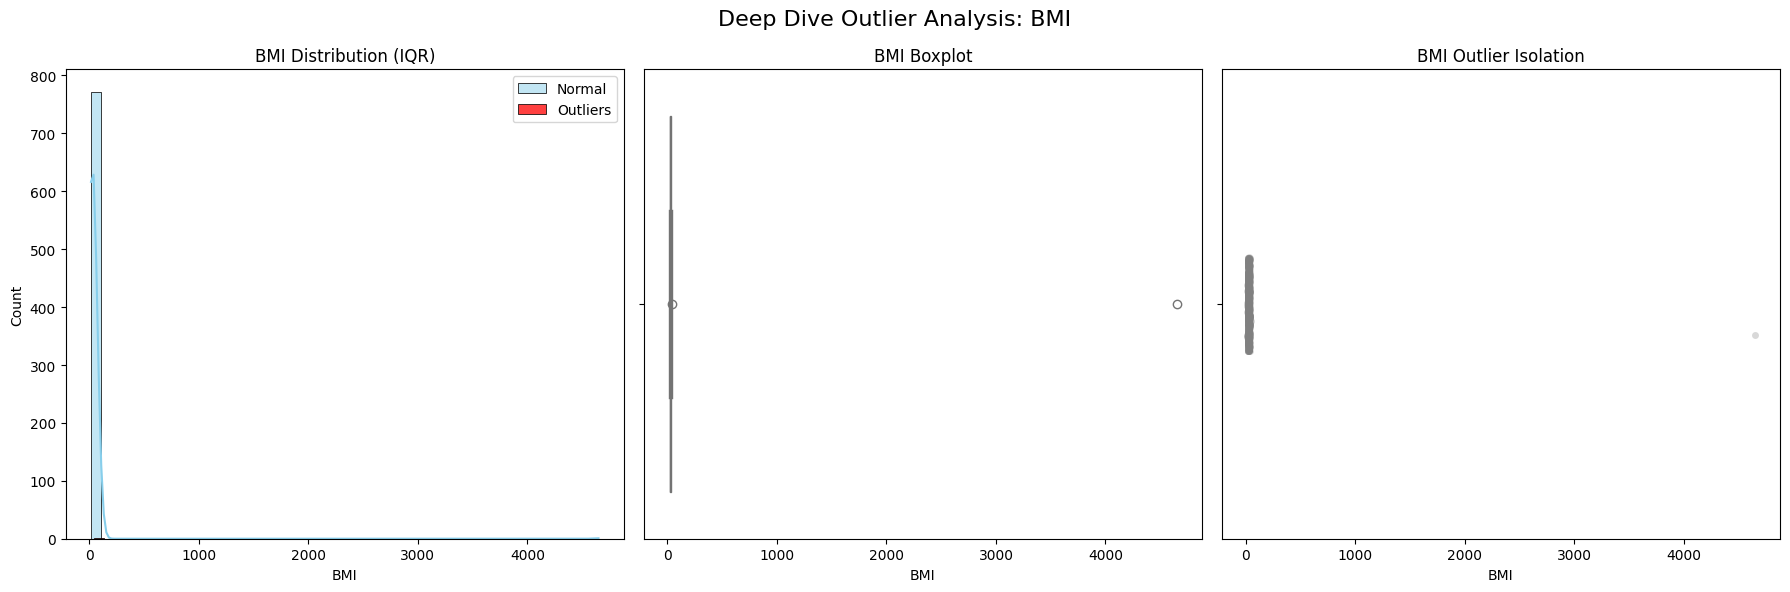


 ANALYZING GLUCOSE OUTLIERS...
--- IQR Method for Glucose ---
Bounds: 1.50 to 261.50
Outliers detected: 191 (7.05%)


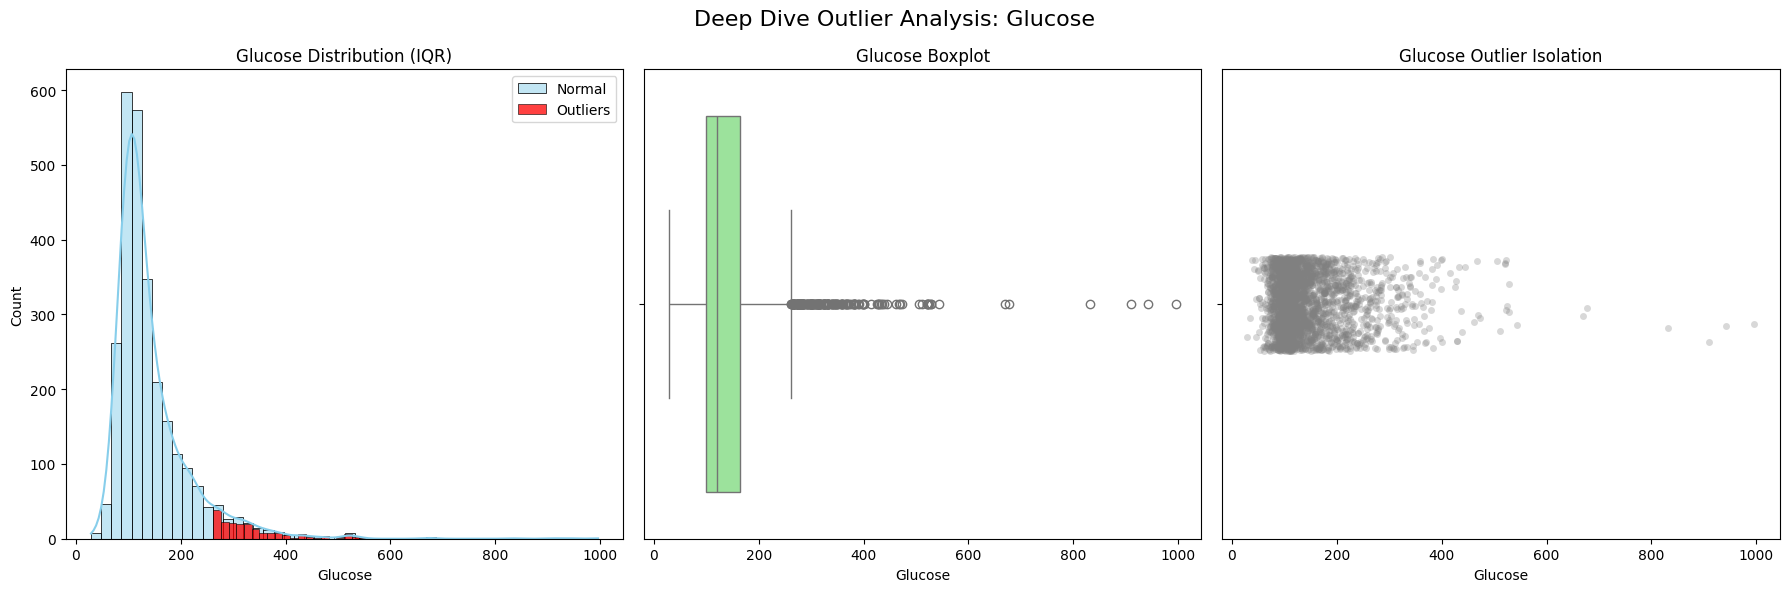


ANALYZING LOS OUTLIERS...
--- IQR Method for LOS ---
Bounds: -4.43 to 10.51
Outliers detected: 10 (7.14%)


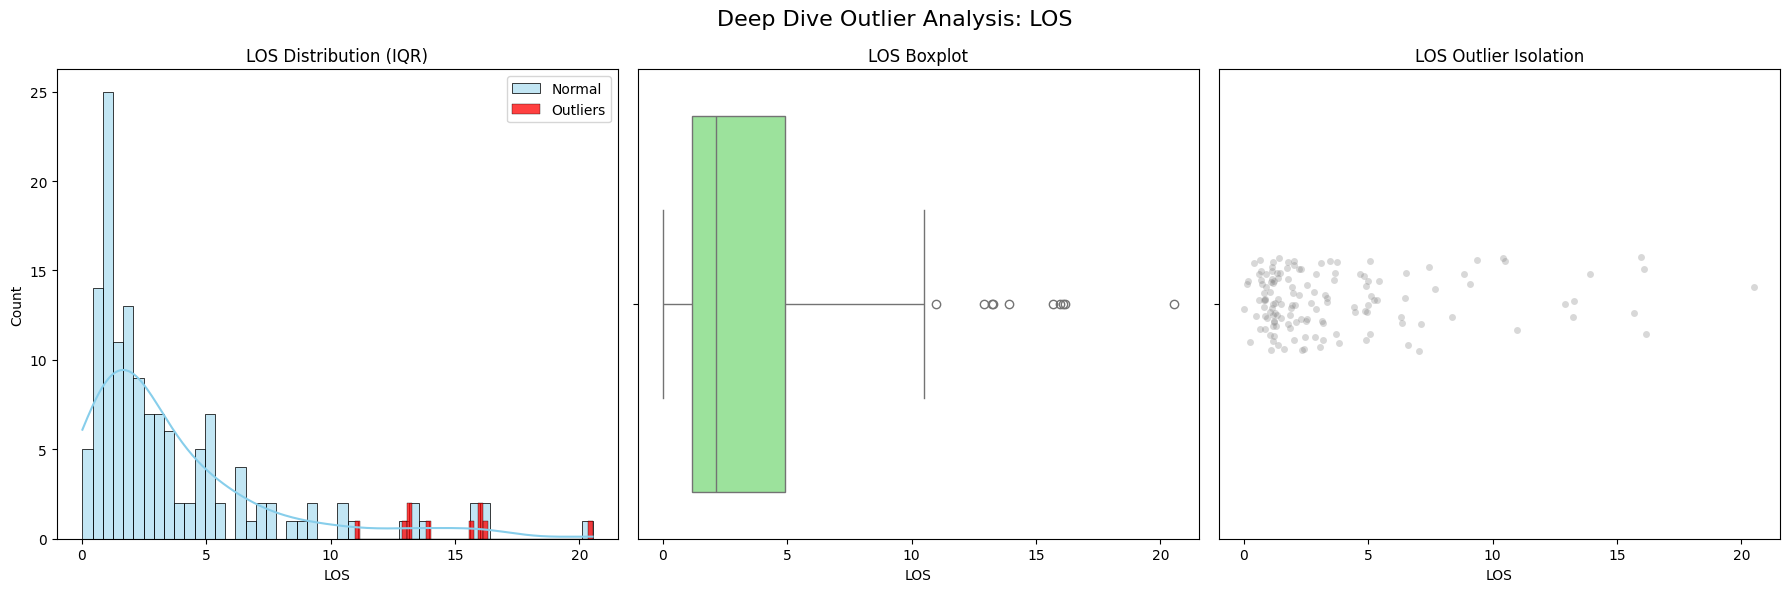


 RUNNING ISOLATION FOREST (Multivariate)...

--- Isolation Forest (ML) for ['BMI', 'Glucose'] ---
Outliers detected: 3533 (5.00%)


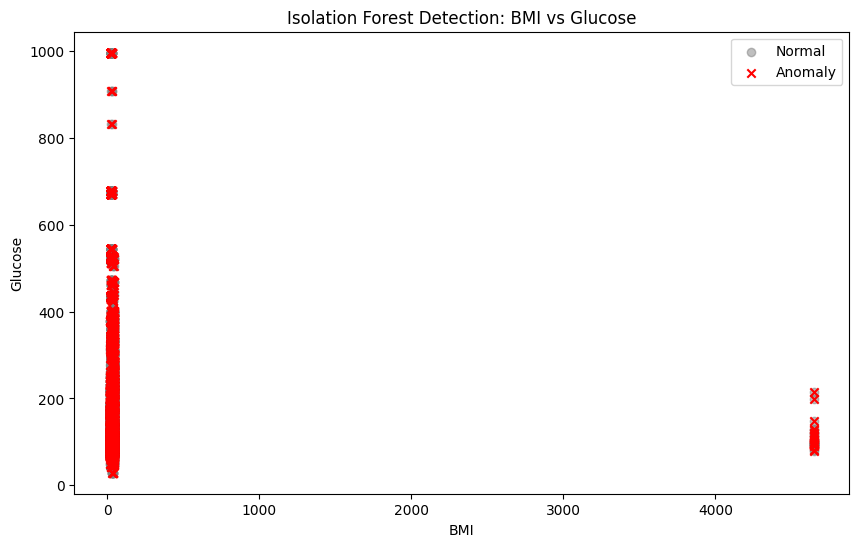


 Outlier Deep Dive Complete.


In [38]:
# 1. Prepare Data
bmi_df = extract_bmi(omr)
glucose_df = extract_glucose(labevents)
los_df = extract_los(icustays)

# 2. Analyze BMI (Feature 1)
# BMI is often skewed, so IQR is safer than Z-score.
print(" ANALYZING BMI OUTLIERS...")
bmi_outliers = detect_outliers_iqr(bmi_df, 'BMI')
plot_outlier_deep_dive(bmi_df, 'BMI', bmi_outliers, 'IQR')

# 3. Analyze Glucose (Feature 2)
# Glucose has extreme highs (Hyperglycemia). We need to see them.
print("\n ANALYZING GLUCOSE OUTLIERS...")
glucose_outliers = detect_outliers_iqr(glucose_df, 'Glucose')
plot_outlier_deep_dive(glucose_df, 'Glucose', glucose_outliers, 'IQR')

# 4. Analyze Length of Stay (Feature 3)
# LOS is highly skewed. Z-score will fail here. IQR is mandatory.
print("\nANALYZING LOS OUTLIERS...")
los_outliers = detect_outliers_iqr(los_df, 'LOS')
plot_outlier_deep_dive(los_df, 'LOS', los_outliers, 'IQR')

# 5. Multivariate Analysis (The "Hidden" Outliers)
# Let's merge BMI and Glucose to find patients who are weird in *combination*
print("\n RUNNING ISOLATION FOREST (Multivariate)...")
merged_df = pd.merge(bmi_df, glucose_df, on='subject_id', how='inner').dropna()

if not merged_df.empty:
    multi_outliers = detect_outliers_isolation_forest(merged_df, ['BMI', 'Glucose'])
    
    # Visualization for Multivariate
    plt.figure(figsize=(10, 6))
    plt.scatter(merged_df['BMI'], merged_df['Glucose'], c='grey', alpha=0.5, label='Normal')
    plt.scatter(multi_outliers['BMI'], multi_outliers['Glucose'], c='red', marker='x', label='Anomaly')
    plt.xlabel('BMI')
    plt.ylabel('Glucose')
    plt.title('Isolation Forest Detection: BMI vs Glucose')
    plt.legend()
    plt.show()
else:
    print("Not enough overlapping data for Multivariate analysis.")

print("\n Outlier Deep Dive Complete.")

 Data Loaded Successfully.

--- RUNNING LOF: PHYSIOLOGICAL CONSISTENCY CHECK ---


c:\Users\tssmi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


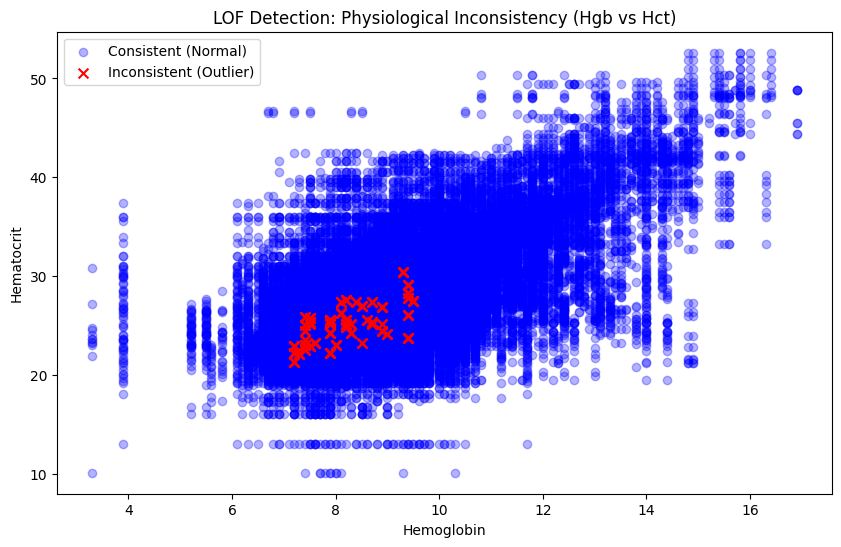

Detected 379 physiological inconsistencies.

--- RUNNING DBSCAN: VITAL SIGN CLUSTERING ---


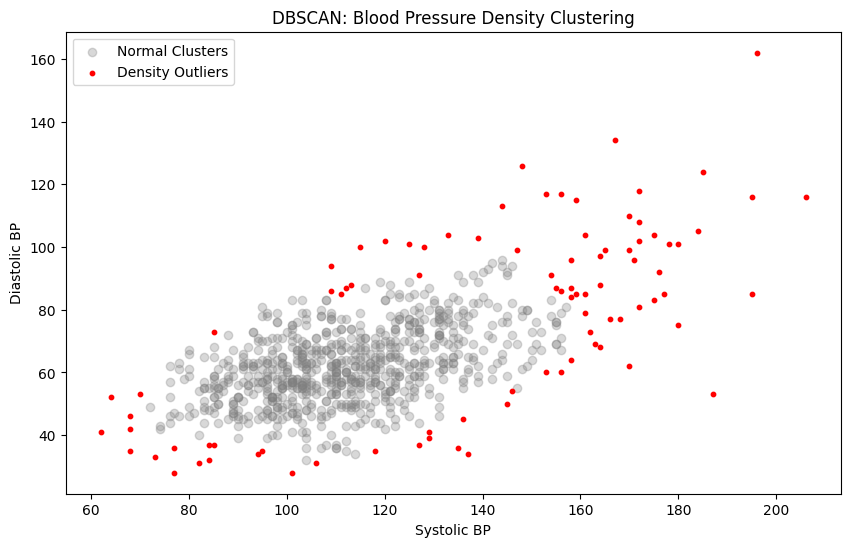

DBSCAN found 89 outliers (Noise points).

--- RUNNING TIME-SERIES ANOMALY DETECTION ---
Analyzing Temporal Outliers for Patient ID: 10003400


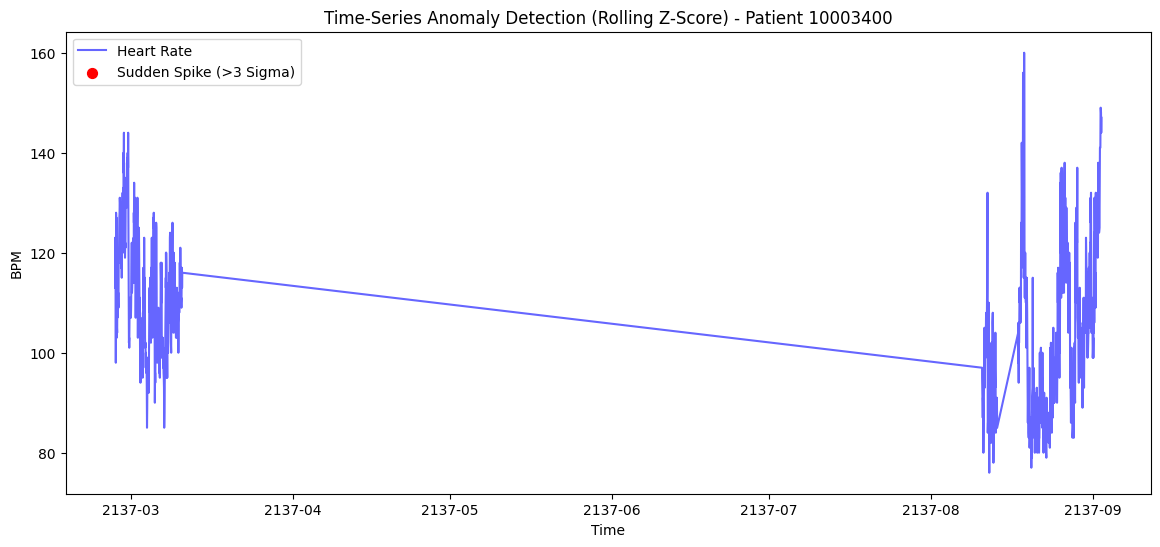


--- RUNNING DOMAIN KNOWLEDGE CHECKS ---
Rule 1 Check: Found 0 records where Diastolic > Systolic (Data Error).
Rule 2 Check: Found 0 records with Pulse Pressure < 10 (Critical/Error).

 Advanced Outlier Analysis Complete.


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

LAB_FILE = 'Data/Raw_data/labevents.csv'
CHART_FILE = 'Data/Raw_data/chartevents.csv'

# ITEM IDs (Specific to MIMIC dataset)
# Hemoglobin: 51222, Hematocrit: 51221 (These should correlate)
ITEM_HGB = 51222 
ITEM_HCT = 51221 
# Heart Rate: 220045
ITEM_HR = 220045 
# Blood Pressure: Systolic (220179), Diastolic (220180)
ITEM_SBP = 220179
ITEM_DBP = 220180
def load_data():
    try:
        lab = pd.read_csv(LAB_FILE, usecols=['subject_id', 'hadm_id', 'itemid', 'valuenum', 'charttime'])
        chart = pd.read_csv(CHART_FILE, usecols=['subject_id', 'stay_id', 'itemid', 'valuenum', 'charttime'])
        print(" Data Loaded Successfully.")
        return lab, chart
    except FileNotFoundError:
        print(" Files not found. Check paths.")
        return None, None

lab_df, chart_df = load_data()
if lab_df is None: exit()
# 1. LOCAL OUTLIER FACTOR (LOF)
print("\n--- RUNNING LOF: PHYSIOLOGICAL CONSISTENCY CHECK ---")

# Extract Hgb and Hct for the same admission
hgb = lab_df[lab_df['itemid'] == ITEM_HGB][['subject_id', 'hadm_id', 'valuenum']].rename(columns={'valuenum': 'Hgb'})
hct = lab_df[lab_df['itemid'] == ITEM_HCT][['subject_id', 'hadm_id', 'valuenum']].rename(columns={'valuenum': 'Hct'})

# Merge on admission
blood_data = pd.merge(hgb, hct, on=['subject_id', 'hadm_id']).dropna()

if not blood_data.empty:
    # LOF Algorithm
    # n_neighbors=20 is standard; contamination=auto allows algorithm to decide
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
    
    # We fit on the 2D data (Hgb vs Hct)
    X = blood_data[['Hgb', 'Hct']]
    blood_data['anomaly_score'] = lof.fit_predict(X) # -1 is outlier, 1 is inlier

    # Visualization
    plt.figure(figsize=(10, 6))
    inliers = blood_data[blood_data['anomaly_score'] == 1]
    outliers = blood_data[blood_data['anomaly_score'] == -1]
    
    plt.scatter(inliers['Hgb'], inliers['Hct'], c='blue', alpha=0.3, label='Consistent (Normal)')
    plt.scatter(outliers['Hgb'], outliers['Hct'], c='red', marker='x', s=50, label='Inconsistent (Outlier)')
    plt.xlabel('Hemoglobin')
    plt.ylabel('Hematocrit')
    plt.title('LOF Detection: Physiological Inconsistency (Hgb vs Hct)')
    plt.legend()
    plt.show()
    
    print(f"Detected {len(outliers)} physiological inconsistencies.")
else:
    print("Not enough paired lab data for LOF.")

# 2. DBSCAN CLUSTERING
print("\n--- RUNNING DBSCAN: VITAL SIGN CLUSTERING ---")

# Extract Systolic and Diastolic BP
sbp = chart_df[chart_df['itemid'] == ITEM_SBP][['subject_id', 'stay_id', 'charttime', 'valuenum']].rename(columns={'valuenum': 'SBP'})
dbp = chart_df[chart_df['itemid'] == ITEM_DBP][['subject_id', 'stay_id', 'charttime', 'valuenum']].rename(columns={'valuenum': 'DBP'})

# Merge on exact timestamp (BP is usually taken together)
bp_data = pd.merge(sbp, dbp, on=['subject_id', 'stay_id', 'charttime']).dropna().sample(frac=0.1) # Sample 10% for speed if large

if not bp_data.empty:
    # Standardize data (DBSCAN works better on scaled data)
    scaler = StandardScaler()
    X_bp = scaler.fit_transform(bp_data[['SBP', 'DBP']])
    
    # DBSCAN
    # eps = distance threshold, min_samples = cluster size
    dbscan = DBSCAN(eps=0.3, min_samples=10)
    bp_data['cluster'] = dbscan.fit_predict(X_bp)

    # Visualization
    plt.figure(figsize=(10, 6))
    # Cluster -1 is noise (outlier) in DBSCAN
    plt.scatter(bp_data[bp_data['cluster']!=-1]['SBP'], bp_data[bp_data['cluster']!=-1]['DBP'], c='grey', alpha=0.3, label='Normal Clusters')
    plt.scatter(bp_data[bp_data['cluster']==-1]['SBP'], bp_data[bp_data['cluster']==-1]['DBP'], c='red', s=10, label='Density Outliers')
    plt.xlabel('Systolic BP')
    plt.ylabel('Diastolic BP')
    plt.title('DBSCAN: Blood Pressure Density Clustering')
    plt.legend()
    plt.show()
    
    print(f"DBSCAN found {len(bp_data[bp_data['cluster']==-1])} outliers (Noise points).")
else:
    print("Not enough BP data for DBSCAN.")
# 3. TIME-SERIES ANOMALY DETECTION (Rolling Z-Score)

print("\n--- RUNNING TIME-SERIES ANOMALY DETECTION ---")

# Select one patient with lots of data
top_patient = chart_df[chart_df['itemid'] == ITEM_HR]['subject_id'].value_counts().idxmax()
print(f"Analyzing Temporal Outliers for Patient ID: {top_patient}")

hr_data = chart_df[(chart_df['subject_id'] == top_patient) & (chart_df['itemid'] == ITEM_HR)].copy()
hr_data['charttime'] = pd.to_datetime(hr_data['charttime'])
hr_data = hr_data.sort_values('charttime')

# Calculate Rolling Stats (Window = 5 measurements)
window_size = 5
hr_data['rolling_mean'] = hr_data['valuenum'].rolling(window=window_size).mean()
hr_data['rolling_std'] = hr_data['valuenum'].rolling(window=window_size).std()

# Define Outlier: Value deviates > 3 std devs from the moving average
# This detects sudden spikes relative to the *recent* trend, not the global average.
hr_data['ts_z_score'] = (hr_data['valuenum'] - hr_data['rolling_mean']) / hr_data['rolling_std']
hr_data['is_outlier'] = abs(hr_data['ts_z_score']) > 3

# Visualization
plt.figure(figsize=(14, 6))
plt.plot(hr_data['charttime'], hr_data['valuenum'], label='Heart Rate', color='blue', alpha=0.6)
plt.scatter(hr_data[hr_data['is_outlier']]['charttime'], hr_data[hr_data['is_outlier']]['valuenum'], color='red', label='Sudden Spike (>3 Sigma)', s=50, zorder=5)
plt.title(f'Time-Series Anomaly Detection (Rolling Z-Score) - Patient {top_patient}')
plt.ylabel('BPM')
plt.xlabel('Time')
plt.legend()
plt.show()
# 4. DOMAIN KNOWLEDGE CHECKS
print("\n--- RUNNING DOMAIN KNOWLEDGE CHECKS ---")
bp_data['pulse_pressure'] = bp_data['SBP'] - bp_data['DBP']

# Rule 1: Diastolic > Systolic (Impossible)
impossible_bp = bp_data[bp_data['DBP'] > bp_data['SBP']]
print(f"Rule 1 Check: Found {len(impossible_bp)} records where Diastolic > Systolic (Data Error).")

# Rule 2: Pulse Pressure < 10 (Physiological Crisis or Error)
narrow_pp = bp_data[bp_data['pulse_pressure'] < 10]
print(f"Rule 2 Check: Found {len(narrow_pp)} records with Pulse Pressure < 10 (Critical/Error).")

print("\n Advanced Outlier Analysis Complete.")

   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.6 MB 840.2 kB/s eta 0:00:11
   --- ------------------------------------ 0.8/9.6 MB 1.0 MB/s eta 0:00:09
   ---- ----------------------------------- 1.0/9.6 MB 1.2 MB/s eta 0:00:08
   ---- ----------------------------------- 1.0/9.6 MB 1.2 MB/s eta 0:00:08
   ---- ----------------------------------- 1.0/9.6 MB 1.2 MB/s eta 0:00:08
   ------ --------------------------------- 1.6/9.6 MB 953.2 kB/s eta 0:00:09
   ------ --------------------------------- 1.6/9.6 MB 953.2 kB/s eta 0:00:09
   ------- -------------------------------- 1.8/9.6 MB 949.8 kB/s eta 0:00:09
   -------- ------------------------------- 2.1/9.6 MB 970.9 kB/s eta 0:00:08
   -------- ------------------------------- 2.1/9.6 MB 970.9 kB/s eta 0:00:08
   -------- ---------

C:\Users\tssmi\AppData\Local\Temp\ipykernel_21372\3697574047.py:57: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = patient_df['Glucose'].resample('1H').mean().interpolate(method='linear')


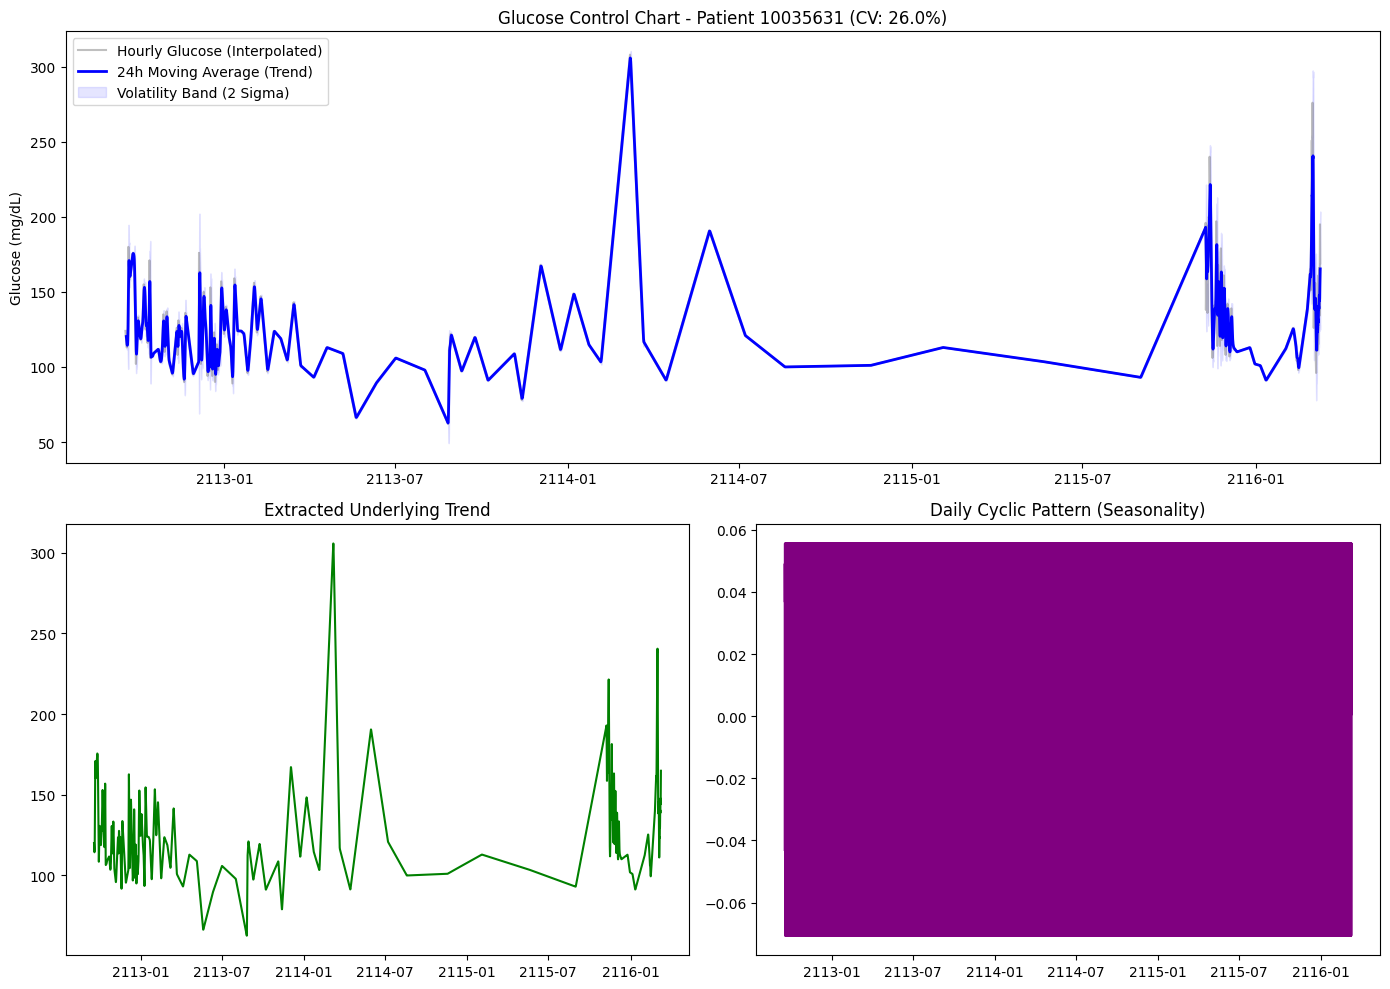


--- CLINICAL INTERPRETATION ---
 STATUS: STABLE
AI ACTION: Standard 3-meal diet plan is safe.


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
# CONFIGURATION
LAB_FILE = 'Data/Raw_data/labevents.csv'
CHART_FILE = 'Data/Raw_data/chartevents.csv'
ITEMS_GLUCOSE = [50931, 50809] # Serum Glucose, Blood Gas Glucose
ITEM_HR = 220045 # Heart Rate

# DATA LOADING & PREPROCESSING
def load_and_prep_data():
    print("⏳ Loading Data...")
    try:
        # Load Labs (Glucose)
        labs = pd.read_csv(LAB_FILE, usecols=['subject_id', 'itemid', 'charttime', 'valuenum'])
        glucose = labs[labs['itemid'].isin(ITEMS_GLUCOSE)].copy()
        glucose['charttime'] = pd.to_datetime(glucose['charttime'])
        glucose = glucose.rename(columns={'valuenum': 'Glucose'})
        
        # Load Vitals (Heart Rate) - Optional, for correlation
        charts = pd.read_csv(CHART_FILE, usecols=['subject_id', 'itemid', 'charttime', 'valuenum'])
        hr = charts[charts['itemid'] == ITEM_HR].copy()
        hr['charttime'] = pd.to_datetime(hr['charttime'])
        hr = hr.rename(columns={'valuenum': 'HeartRate'})
        
        print("✅ Data Loaded.")
        return glucose, hr
    except FileNotFoundError:
        print("❌ Data files not found.")
        return None, None

def get_best_patient(df, min_records=50):
    """Finds the patient with the most data points for meaningful TS analysis."""
    counts = df['subject_id'].value_counts()
    top_patient = counts.idxmax()
    count = counts.max()
    print(f"🔎 Selected Patient {top_patient} with {count} records.")
    return top_patient

# ANALYSIS 1: GLYCEMIC VARIABILITY (GV)
def analyze_glycemic_variability(df, subject_id):
    """
    Calculates key MNC-grade metrics:
    1. MAG (Mean Absolute Glucose Change) - Speed of fluctuation.
    2. CV (Coefficient of Variation) - Relative volatility.
    """
    patient_df = df[df['subject_id'] == subject_id].sort_values('charttime').copy()
    patient_df = patient_df.set_index('charttime')
    
    # Resample to hourly to handle irregular testing times
    # Interpolate linearly to fill gaps (standard clinical practice for trends)
    ts = patient_df['Glucose'].resample('1H').mean().interpolate(method='linear')
    
    # --- Calculation ---
    mean_glucose = ts.mean()
    std_dev = ts.std()
    cv = (std_dev / mean_glucose) * 100 # Coefficient of Variation (%)
    
    # Mean Amplitude of Glycemic Excursions (Simplified MAG)
    # Sum of absolute differences between consecutive hours / Total hours
    mag = np.sum(np.abs(np.diff(ts))) / len(ts)
    
    print(f"\n--- Glycemic Analysis for Patient {subject_id} ---")
    print(f"Mean Glucose: {mean_glucose:.2f} mg/dL")
    print(f"Volatility (CV): {cv:.2f}% (Normal < 36%)")
    print(f"Instability Score (MAG): {mag:.2f} mg/dL per hour")
    
    return ts, cv, mag
# ANALYSIS 2: DECOMPOSITION & TREND

def visualize_trends(ts, subject_id, cv):
    """
    Decomposes the time series into Trend, Seasonality, and Noise.
    Also plots Rolling Statistics (Bollinger Bands logic).
    """
    # 1. Rolling Stats
    rolling_mean = ts.rolling(window=24).mean() # 24-hour moving average
    rolling_std = ts.rolling(window=24).std()
    
    plt.figure(figsize=(14, 10))
    
    # Plot A: Raw Data vs. Rolling Trend
    plt.subplot(2, 1, 1)
    plt.plot(ts, label='Hourly Glucose (Interpolated)', color='gray', alpha=0.5)
    plt.plot(rolling_mean, label='24h Moving Average (Trend)', color='blue', linewidth=2)
    plt.fill_between(ts.index, 
                     rolling_mean - 2*rolling_std, 
                     rolling_mean + 2*rolling_std, 
                     color='blue', alpha=0.1, label='Volatility Band (2 Sigma)')
    plt.title(f'Glucose Control Chart - Patient {subject_id} (CV: {cv:.1f}%)')
    plt.ylabel('Glucose (mg/dL)')
    plt.legend()
    
    # Plot B: Seasonal Decomposition (if enough data)
    if len(ts) > 48: # Need at least 2 days for seasonality
        decomp = seasonal_decompose(ts, model='additive', period=24) # 24h period
        
        plt.subplot(2, 2, 3)
        plt.plot(decomp.trend, color='green')
        plt.title('Extracted Underlying Trend')
        
        plt.subplot(2, 2, 4)
        plt.plot(decomp.seasonal, color='purple')
        plt.title('Daily Cyclic Pattern (Seasonality)')
        
    plt.tight_layout()
    plt.show()

# ==========================================
# EXECUTION
# ==========================================
glucose_df, hr_df = load_and_prep_data()

if glucose_df is not None:
    # 1. Pick a patient who actually has enough data to analyze
    target_patient = get_best_patient(glucose_df)
    
    # 2. Run Analysis
    ts_data, patient_cv, patient_mag = analyze_glycemic_variability(glucose_df, target_patient)
    
    # 3. Interpret & Visualize
    visualize_trends(ts_data, target_patient, patient_cv)
    
    # 4. Clinical Logic for AI-NutriCare
    print("\n--- CLINICAL INTERPRETATION ---")
    if patient_cv > 36:
        print("⚠️ STATUS: UNSTABLE (High Variability)")
        print("AI ACTION: Diet plan must split meals into 6 small portions (Small Frequent Feeds).")
        print("REASON: Large meals will cause dangerous spikes (Hyperglycemia).")
    else:
        print(" STATUS: STABLE")
        print("AI ACTION: Standard 3-meal diet plan is safe.")

In [41]:
import pandas as pd

try:
    # Load a chunk of labevents to find glucose
    # glucose itemid is typically 50931
    chunk_size = 100000
    candidate_subject = None
    
    for chunk in pd.read_csv('Data/Raw_data/labevents.csv', chunksize=chunk_size):
        glucose_data = chunk[chunk['itemid'] == 50931]
        if not glucose_data.empty:
            counts = glucose_data['subject_id'].value_counts()
            # Find first subject with > 30 records
            valid_subjects = counts[counts > 30]
            if not valid_subjects.empty:
                candidate_subject = valid_subjects.index[0]
                print(f"Found candidate subject with sufficient glucose data: {candidate_subject}")
                print(f"Record count: {valid_subjects.iloc[0]}")
                break
    
    if not candidate_subject:
        print("Could not find a subject with > 30 glucose records in the scanned chunks.")

except Exception as e:
    print(f"Error searching for patient: {e}")

Found candidate subject with sufficient glucose data: 10035631
Record count: 205



---  Running Fluid Balance Analysis for Patient 10014729 ---


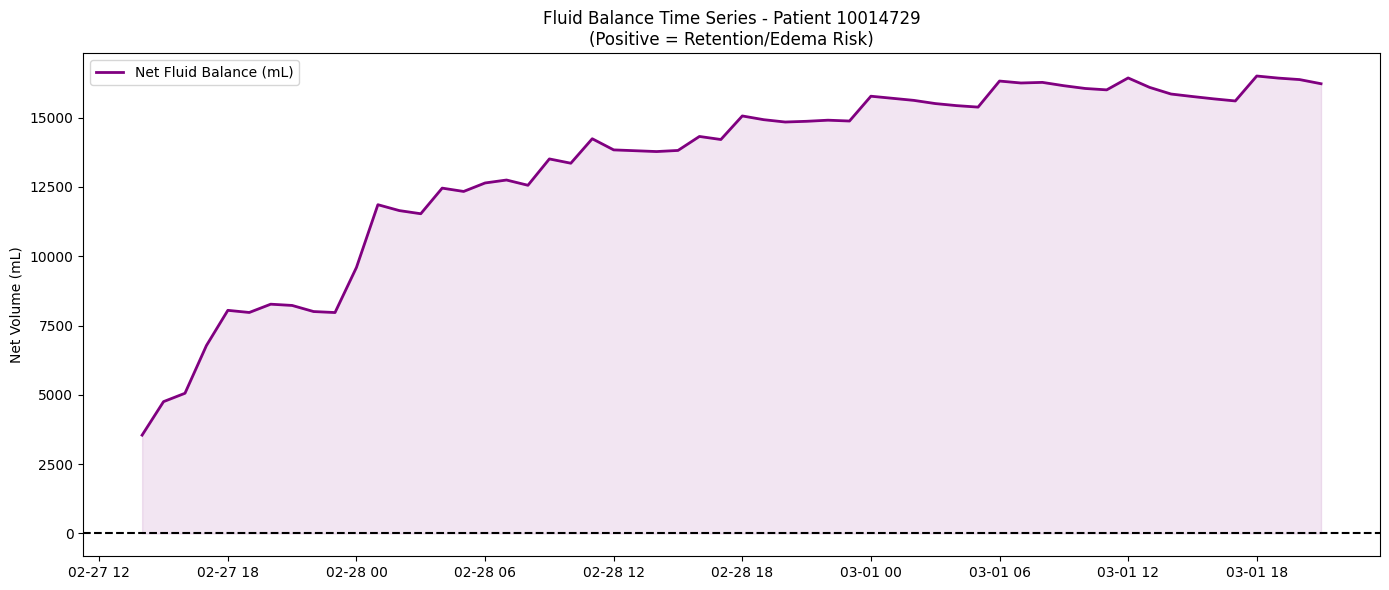

Final Net Balance: +16223 mL
 DIAGNOSIS: FLUID OVERLOAD
AI DIET RULE: Assign 'Low Sodium' (<1500mg) & 'Fluid Restricted' diet.

---  Running Glucose Forecasting for Patient 10035631 ---
 Training Model on 12180 points. Testing on 3045 points.


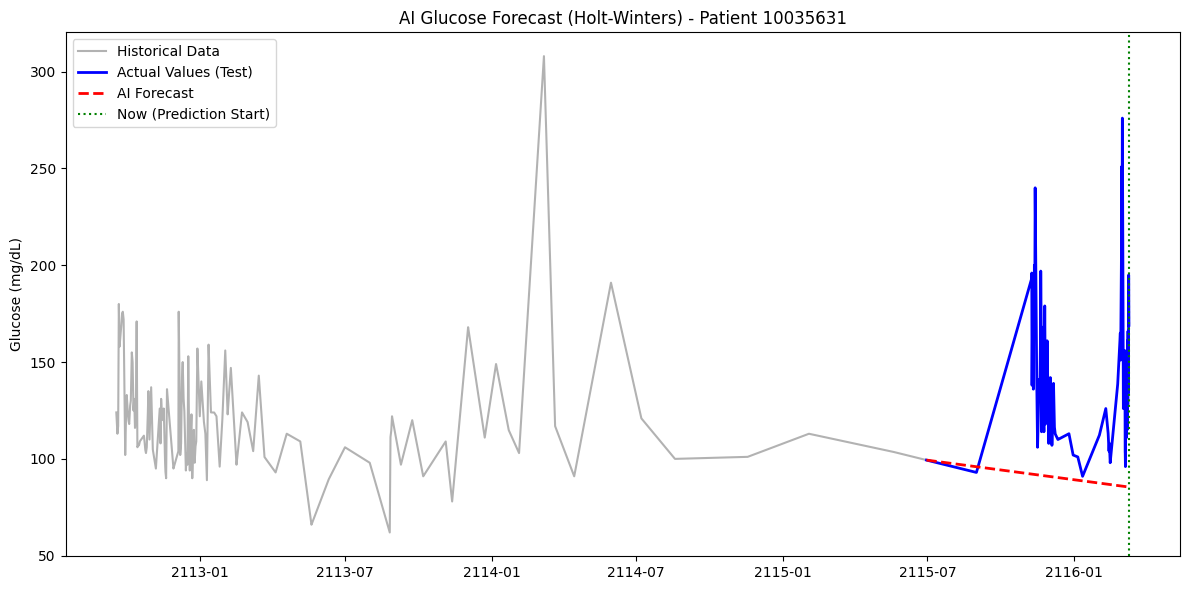

Current Glucose: 169 mg/dL
Predicted (12h): 85 mg/dL
 STATUS: Stable Glucose Trend.


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ==========================================
# CONFIGURATION
# ==========================================
# Adjust these filenames if your local paths are different
LAB_FILE = 'Data/Raw_data/labevents.csv'
INPUT_FILE = 'Data/Raw_data/inputevents.csv'
OUTPUT_FILE = 'Data/Raw_data/outputevents.csv'

# Item IDs (MIMIC-III Standards)
GLUCOSE_ITEMID = 50931  # Serum Glucose

# ==========================================
# MODULE 1: FLUID BALANCE TIME SERIES
# Use Case: Detection of Fluid Overload (Edema/Heart Failure Risk)
# ==========================================
def analyze_fluid_balance(subject_id):
    print(f"\n---  Running Fluid Balance Analysis for Patient {subject_id} ---")
    
    try:
        # 1. Load Inputs (IVs, Tube Feeds)
        inputs = pd.read_csv(INPUT_FILE, usecols=['subject_id', 'starttime', 'amount'])
        inputs = inputs[inputs['subject_id'] == subject_id].copy()
        if inputs.empty:
            print(f" No input data found for Patient {subject_id}")
            return

        inputs['starttime'] = pd.to_datetime(inputs['starttime'])
        inputs = inputs.set_index('starttime').sort_index()
        
        # 2. Load Outputs (Urine, Drains)
        outputs = pd.read_csv(OUTPUT_FILE, usecols=['subject_id', 'charttime', 'value'])
        outputs = outputs[outputs['subject_id'] == subject_id].copy()
        if outputs.empty:
            print(f" No output data found for Patient {subject_id}")
            return

        outputs['charttime'] = pd.to_datetime(outputs['charttime'])
        outputs = outputs.set_index('charttime').sort_index()
        
        # 3. Resample to Hourly (Fixed '1h' deprecation)
        in_hourly = inputs['amount'].resample('1h').sum().fillna(0)
        out_hourly = outputs['value'].resample('1h').sum().fillna(0)
        
        # 4. Align and Calculate Net Balance
        df = pd.concat([in_hourly, out_hourly], axis=1, keys=['Input', 'Output']).fillna(0)
        df['Cum_Input'] = df['Input'].cumsum()
        df['Cum_Output'] = df['Output'].cumsum()
        df['Net_Balance'] = df['Cum_Input'] - df['Cum_Output']
        
        # 5. Visualization
        plt.figure(figsize=(14, 6))
        plt.plot(df.index, df['Net_Balance'], label='Net Fluid Balance (mL)', color='purple', linewidth=2)
        
        # Color the area: Purple for Overload, Orange for Dehydration
        plt.fill_between(df.index, df['Net_Balance'], 0, where=(df['Net_Balance']>0), color='purple', alpha=0.1)
        plt.fill_between(df.index, df['Net_Balance'], 0, where=(df['Net_Balance']<0), color='orange', alpha=0.1)
        
        plt.title(f'Fluid Balance Time Series - Patient {subject_id}\n(Positive = Retention/Edema Risk)')
        plt.ylabel('Net Volume (mL)')
        plt.axhline(0, color='black', linestyle='--')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # 6. Clinical Logic / Interpretation
        final_balance = df['Net_Balance'].iloc[-1]
        print(f"Final Net Balance: {final_balance:+.0f} mL")
        
        if final_balance > 2000:
            print(" DIAGNOSIS: FLUID OVERLOAD")
            print("AI DIET RULE: Assign 'Low Sodium' (<1500mg) & 'Fluid Restricted' diet.")
        elif final_balance < -1000:
            print(" DIAGNOSIS: DEHYDRATION")
            print("AI DIET RULE: Prioritize Hydrating Foods (Soups, Fruits, Jello).")
        else:
            print(" DIAGNOSIS: EUVOLEMIC (Balanced)")
            print("AI DIET RULE: Standard maintenance fluid intake.")
            
    except Exception as e:
        print(f" Fluid Analysis Error: {e}")

# ==========================================
# MODULE 2: GLUCOSE FORECASTING (AI PREDICTION)
# Use Case: Predicting Hypo/Hyperglycemia before it happens
# ==========================================
def forecast_glucose(subject_id):
    print(f"\n---  Running Glucose Forecasting for Patient {subject_id} ---")
    
    try:
        # 1. Load Lab Glucose
        labs = pd.read_csv(LAB_FILE, usecols=['subject_id', 'itemid', 'charttime', 'valuenum'])
        # Filter for Serum Glucose (50931)
        glucose = labs[(labs['subject_id'] == subject_id) & (labs['itemid'] == GLUCOSE_ITEMID)].copy()
        
        # Check Data Sufficiency
        if len(glucose) < 20:
            print(f" Insufficient data ({len(glucose)} records). Forecasting requires > 20 points.")
            return

        glucose['charttime'] = pd.to_datetime(glucose['charttime'])
        glucose = glucose.set_index('charttime').sort_index()
        
        # 2. Resample and Interpolate (Fixed '2h' deprecation)
        # We use 2h intervals because lab draws aren't hourly. Linear interpolation fills gaps.
        ts = glucose['valuenum'].resample('2h').mean().interpolate(method='linear')
        
        # 3. Train/Test Split (80/20)
        train_size = int(len(ts) * 0.8)
        train, test = ts.iloc[:train_size], ts.iloc[train_size:]
        
        print(f" Training Model on {len(train)} points. Testing on {len(test)} points.")
        
        # 4. Fit Holt-Winters Exponential Smoothing Model
        # Seasonal periods = 4 (approx 8 hours daily cycle logic, usually 3 meals)
        model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=4, trend='add').fit()
        
        # Predict: Test duration + 12 hours into the unknown future
        forecast_steps = len(test) + 6
        pred = model.forecast(forecast_steps)
        
        # 5. Visualization
        plt.figure(figsize=(12, 6))
        plt.plot(train.index, train, label='Historical Data', color='gray', alpha=0.6)
        plt.plot(test.index, test, label='Actual Values (Test)', color='blue', linewidth=2)
        plt.plot(pred.index, pred, label='AI Forecast', color='red', linestyle='--', linewidth=2)
        
        # Highlight the "Future" zone
        last_date = test.index[-1]
        plt.axvline(last_date, color='green', linestyle=':', label='Now (Prediction Start)')
        
        plt.title(f'AI Glucose Forecast (Holt-Winters) - Patient {subject_id}')
        plt.ylabel('Glucose (mg/dL)')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # 6. Clinical Logic / Interpretation
        current_val = test.iloc[-1]
        future_val = pred.iloc[-1]
        trend = future_val - current_val
        
        print(f"Current Glucose: {current_val:.0f} mg/dL")
        print(f"Predicted (12h): {future_val:.0f} mg/dL")
        
        if future_val > 180:
            print(" ALERT: Hyperglycemia Predicted.")
            print("AI DIET RULE: Suggest 'Low Glycemic Index' dinner (Leafy Greens, Proteins). No Dessert.")
        elif future_val < 70:
            print(" ALERT: Hypoglycemia Predicted.")
            print("AI DIET RULE: Suggest 'Complex Carb' snack now to prevent crash.")
        elif trend > 30:
            print("↗ ALERT: Rapid Rising Trend.")
            print("AI DIET RULE: Avoid simple sugars in next meal.")
        else:
            print(" STATUS: Stable Glucose Trend.")
            
    except Exception as e:
        print(f" Forecasting Error: {e}")

# ==========================================
# EXECUTION PIPELINE
# ==========================================
if __name__ == "__main__":
    # 1. FLUID ANALYSIS
    # Using the patient you found with fluid overload
    PATIENT_FLUID = 10014729 
    analyze_fluid_balance(PATIENT_FLUID)
    
    # 2. GLUCOSE FORECASTING
    # Using the patient you identified with 205 records (Excellent candidate)
    PATIENT_GLUCOSE = 10035631
    forecast_glucose(PATIENT_GLUCOSE)

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# CONFIGURATION
CHART_FILE = 'Data/Raw_data/chartevents.csv'
D_ITEMS_FILE = 'Data/Raw_data/d_items.csv'
# STEP 1: LOAD DATA
try:
       # Load d_items to find the IDs first
    d_items = pd.read_csv(D_ITEMS_FILE)
    chartevents = pd.read_csv(CHART_FILE, low_memory=False) 
    print(" Data Loaded.")
except FileNotFoundError:
    print(" Files not found.")
    exit()

 Data Loaded.


In [46]:
search_terms = {
    "heart_rate": ["Heart Rate", "HR"],
    "blood_pressure": ["Blood Pressure", "BP", "Systolic", "Diastolic"],
    "respiratory_rate": ["Respiratory Rate", "RR"],
    "temperature": ["Temperature", "Temp"],
    "oxygen_saturation": ["Oxygen Saturation", "SpO2"]
}
found_items = {}
for vital, terms in search_terms.items():
    pattern = '|'.join(terms)
    matches = d_items[d_items['label'].str.contains(pattern, case=False, na=False)]
    found_items[vital] = matches['itemid'].tolist()
all_vital_ids = [item for sublist in found_items.values() for item in sublist]

 Extracted 67110 valid vital sign records.


C:\Users\tssmi\AppData\Local\Temp\ipykernel_21372\32260008.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Vital_Category', y='valuenum', data=final_vitals, palette='Set2')


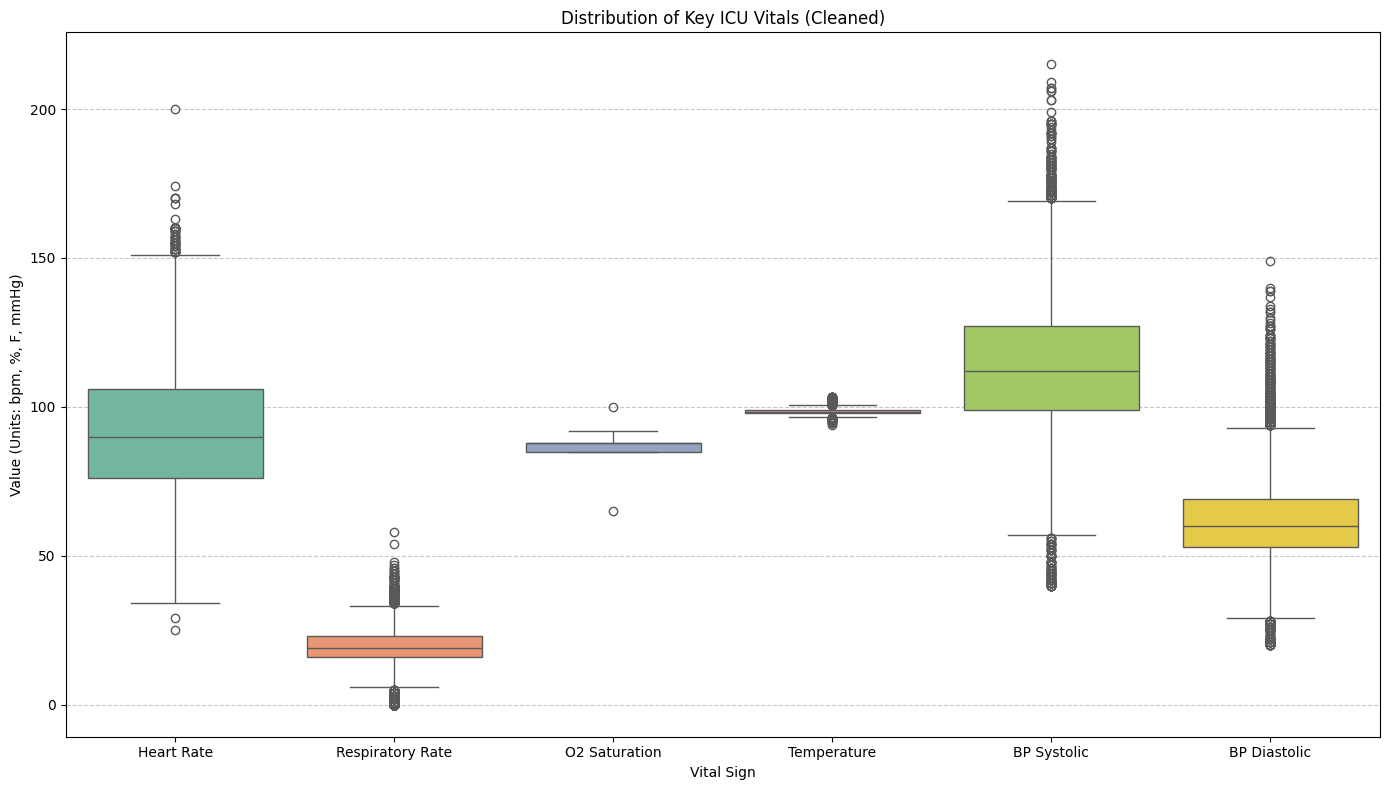


--- Vital Signs Summary Statistics ---
                    count        mean        std   min    50%    max
Vital_Category                                                      
BP Diastolic      14417.0   61.625858  13.573545  20.0   60.0  149.0
BP Systolic       14444.0  114.146981  21.526163  40.0  112.0  215.0
Heart Rate        16333.0   90.934366  22.405053  25.0   90.0  200.0
O2 Saturation      1175.0   86.654468   1.826763  65.0   88.0  100.0
Respiratory Rate  17359.0   19.150873   6.659651   0.0   19.0   58.0
Temperature        3382.0   98.596328   1.075252  94.0   98.4  103.4


In [47]:
vitals_df = chartevents[chartevents['itemid'].isin(all_vital_ids)].copy()

# Merge with d_items to get the actual labels back
vitals_df = vitals_df.merge(d_items[['itemid', 'label']], on='itemid', how='left')

# Convert valuenum to numeric, coercing errors
vitals_df['valuenum'] = pd.to_numeric(vitals_df['valuenum'], errors='coerce')
vitals_df = vitals_df.dropna(subset=['valuenum'])

# Standardize Labels (Map the messy specific labels to our generic categories)
def standardize_label(row_label):
    row_label = row_label.lower()
    if 'heart rate' in row_label: return 'Heart Rate'
    if 'respiratory rate' in row_label: return 'Respiratory Rate'
    if 'saturation' in row_label or 'spo2' in row_label: return 'O2 Saturation'
    if 'temperature' in row_label:
        return 'Temperature'
    if 'systolic' in row_label: return 'BP Systolic'
    if 'diastolic' in row_label: return 'BP Diastolic'
    return 'Other'

vitals_df['Vital_Category'] = vitals_df['label'].apply(standardize_label)

# Filter out 'Other' just in case
vitals_df = vitals_df[vitals_df['Vital_Category'] != 'Other']
bounds = {
    'Heart Rate': (20, 250),
    'Respiratory Rate': (0, 70),
    'O2 Saturation': (50, 100),
    'Temperature': (90, 110), # Assuming Fahrenheit mostly
    'BP Systolic': (40, 250),
    'BP Diastolic': (20, 150)
}

clean_vitals = []
for vital, (low, high) in bounds.items():
    subset = vitals_df[vitals_df['Vital_Category'] == vital]
    if vital == 'Temperature' and not subset.empty and subset['valuenum'].mean() < 50:
        subset.loc[:, 'valuenum'] = subset['valuenum'] * 9/5 + 32
        
    subset = subset[(subset['valuenum'] >= low) & (subset['valuenum'] <= high)]
    clean_vitals.append(subset)

if clean_vitals:
    final_vitals = pd.concat(clean_vitals)
else:
    final_vitals = pd.DataFrame()

print(f" Extracted {len(final_vitals)} valid vital sign records.")

if not final_vitals.empty:
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Vital_Category', y='valuenum', data=final_vitals, palette='Set2')
    plt.title('Distribution of Key ICU Vitals (Cleaned)')
    plt.ylabel('Value (Units: bpm, %, F, mmHg)')
    plt.xlabel('Vital Sign')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('icu_vitals_distribution.png')
    plt.show()
    
    # Summary Stats
    summary = final_vitals.groupby('Vital_Category')['valuenum'].describe()[['count', 'mean', 'std', 'min', '50%', 'max']]
    print("\n--- Vital Signs Summary Statistics ---")
    print(summary)
else:
    print("⚠️ No matching vital signs found ")

C:\Users\tssmi\AppData\Local\Temp\ipykernel_21372\3346270446.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')


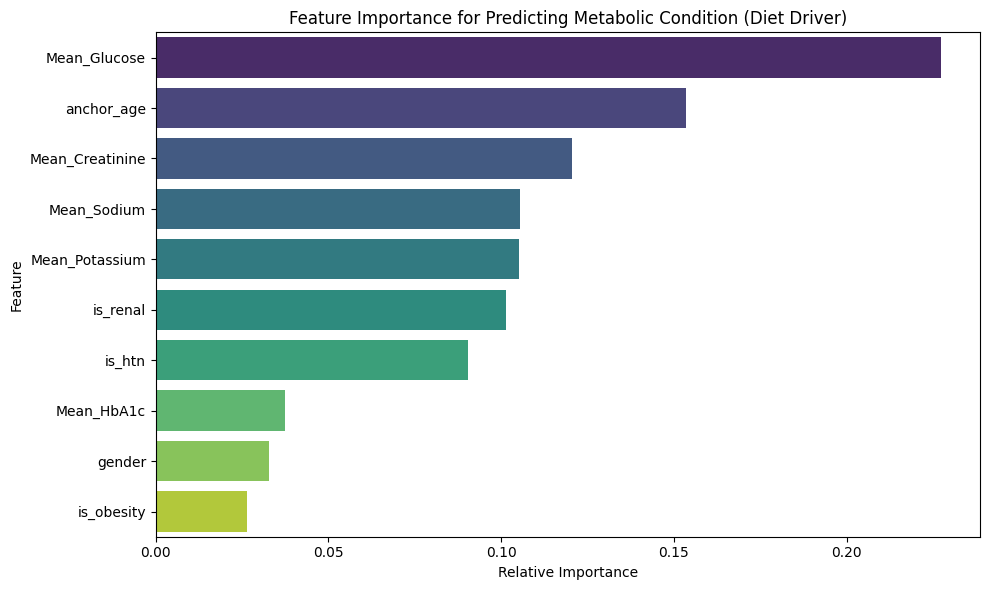


---  Top Selected Variables for Modeling ---
           Feature  Importance
7     Mean_Glucose    0.227261
1       anchor_age    0.153423
6  Mean_Creatinine    0.120421
9      Mean_Sodium    0.105350
8   Mean_Potassium    0.105157
3         is_renal    0.101300
2           is_htn    0.090341
5       Mean_HbA1c    0.037547
0           gender    0.032705
4       is_obesity    0.026495

Interpretation: These are the features that most strongly differentiate patient profiles.


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

RAW_DATA_PATH = '' # Assumes current directory
PATIENTS = 'Data/Raw_data/patients.csv'
ADMISSIONS = 'Data/Raw_data/admissions.csv'
DIAGNOSES = 'Data/Raw_data/diagnoses_icd.csv'
LABS = 'Data/Raw_data/labevents.csv'
VITALS = 'Data/Raw_data/chartevents.csv'
# 1. Demographics (Age, Gender)
patients = pd.read_csv(PATIENTS, usecols=['subject_id', 'gender', 'anchor_age'])
admissions = pd.read_csv(ADMISSIONS, usecols=['subject_id', 'hadm_id', 'hospital_expire_flag'])
base_df = pd.merge(patients, admissions, on='subject_id')

# 2. Comorbidities (Diagnoses) - Creating Binary Flags
diag = pd.read_csv(DIAGNOSES)
diag['is_diabetes'] = diag['icd_code'].str.startswith('250').astype(int)
diag['is_htn'] = diag['icd_code'].str.startswith('401').astype(int)
diag['is_renal'] = diag['icd_code'].str.startswith('585').astype(int)
diag['is_obesity'] = diag['icd_code'].str.startswith('278').astype(int)

# Group by Admission to get flags per patient visit
diag_grouped = diag.groupby('hadm_id')[['is_diabetes', 'is_htn', 'is_renal', 'is_obesity']].max().reset_index()
base_df = base_df.merge(diag_grouped, on='hadm_id', how='left').fillna(0)

# 3. Labs (Numeric Features) - Calculating Mean Values
labs = pd.read_csv(LABS, usecols=['subject_id', 'hadm_id', 'itemid', 'valuenum'])
# Key Labs: Glucose(50931), Creatinine(50912), Sodium(50983), Potassium(50971), HbA1c(50852)
target_labs = {
    50931: 'Mean_Glucose',
    50912: 'Mean_Creatinine',
    50983: 'Mean_Sodium',
    50971: 'Mean_Potassium',
    50852: 'Mean_HbA1c'
}
labs_filtered = labs[labs['itemid'].isin(target_labs.keys())].copy()
labs_filtered['valuenum'] = pd.to_numeric(labs_filtered['valuenum'], errors='coerce')
# Pivot to get one row per admission with columns for each lab
lab_features = labs_filtered.groupby(['hadm_id', 'itemid'])['valuenum'].mean().unstack(level='itemid').rename(columns=target_labs)
base_df = base_df.merge(lab_features, on='hadm_id', how='left')
# Drop Identifiers
X = base_df.drop(columns=['subject_id', 'hadm_id', 'hospital_expire_flag'])
y = base_df['is_diabetes'] 
X = X.drop(columns=['is_diabetes']) # Remove target from features

# Encode Gender
le = LabelEncoder()
X['gender'] = le.fit_transform(X['gender'].astype(str))

# Impute Missing Labs (Mean Imputation)
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_imputed, y)

# Get Feature Importances
importances = rf.feature_importances_
feature_names = X.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values('Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Feature Importance for Predicting Metabolic Condition (Diet Driver)')
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

print("\n---  Top Selected Variables for Modeling ---")
print(feature_imp_df.head(10))
print("\nInterpretation: These are the features that most strongly differentiate patient profiles.")

Identifying a sample patient for heart rate time-series analysis

Selected Sample Patient: Subject ID = 10039708, Stay ID = 33281088 with 652 Heart Rate measurements.

Prepared patient_heart_rate_data for plotting. Head of the data:
        subject_id   hadm_id   stay_id  caregiver_id           charttime            storetime  itemid value  valuenum valueuom  warning       label abbreviation      linksto             category  \
130805    10039708  28258130  33281088       28457.0 2140-01-23 19:00:00  2140-01-23 19:41:00  220045    76      76.0      bpm      0.0  Heart Rate           HR  chartevents  Routine Vital Signs   
136072    10039708  28258130  33281088       28457.0 2140-01-23 19:29:00  2140-01-23 19:29:00  220045    81      81.0      bpm      0.0  Heart Rate           HR  chartevents  Routine Vital Signs   
138792    10039708  28258130  33281088       28457.0 2140-01-23 19:45:00  2140-01-23 20:30:00  220045    71      71.0      bpm      0.0  Heart Rate           HR  chartevents

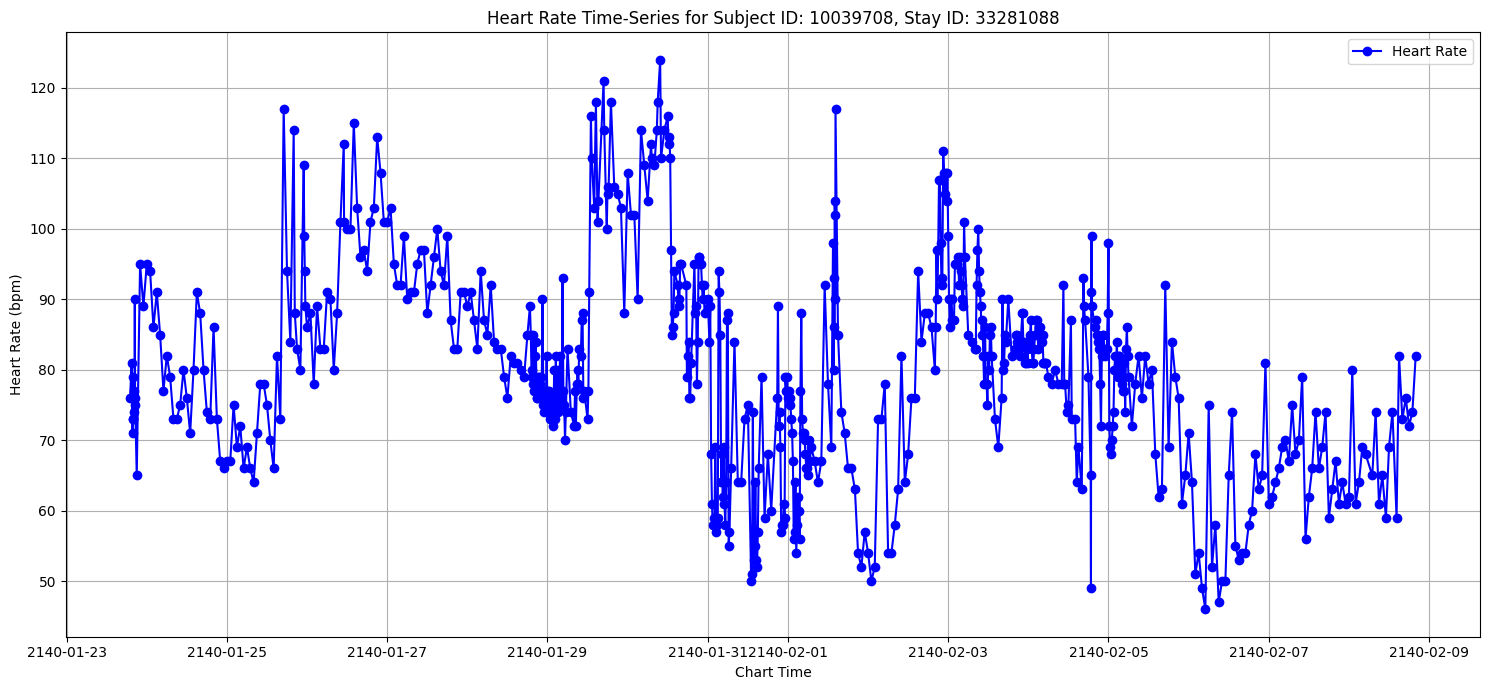

In [49]:
print('Identifying a sample patient for heart rate time-series analysis\n')

# Retrieve the merged chartevents DataFrame
chartevents['itemid'] = pd.to_numeric(chartevents['itemid'], errors='coerce')
chartevents.dropna(subset=['itemid'], inplace=True)
chartevents['itemid'] = chartevents['itemid'].astype(int)
chartevents_merged = pd.merge(chartevents, d_items, on='itemid', how='left', suffixes=('_chart', '_ditem'))
chartevents_merged['valuenum'] = pd.to_numeric(chartevents_merged['valuenum'], errors='coerce')

# Filter for Heart Rate measurements that have a numeric value
heart_rate_data = chartevents_merged[
    (chartevents_merged['label'] == 'Heart Rate') &
    (chartevents_merged['valuenum'].notnull())
]

# Count the number of heart rate measurements per patient and stay
heart_rate_counts = heart_rate_data.groupby(['subject_id', 'stay_id']).size().reset_index(name='count')

# Sort by count in descending order to find patients with many heart rate records
heart_rate_counts = heart_rate_counts.sort_values(by='count', ascending=False)

# Select a sample patient (e.g., the one with the most heart rate measurements)
if not heart_rate_counts.empty:
    sample_patient = heart_rate_counts.iloc[0]
    sample_subject_id = sample_patient['subject_id']
    sample_stay_id = sample_patient['stay_id']
    print(f"Selected Sample Patient: Subject ID = {sample_subject_id}, Stay ID = {sample_stay_id} with {sample_patient['count']} Heart Rate measurements.")

    # Filter data for the selected patient and Heart Rate label
    patient_heart_rate_data = chartevents_merged[
        (chartevents_merged['subject_id'] == sample_subject_id) &
        (chartevents_merged['stay_id'] == sample_stay_id) &
        (chartevents_merged['label'] == 'Heart Rate') &
        (chartevents_merged['valuenum'].notnull())
    ].copy() # Use .copy() to avoid SettingWithCopyWarning

    # Convert 'charttime' to datetime objects
    patient_heart_rate_data['charttime'] = pd.to_datetime(patient_heart_rate_data['charttime'])

    # Sort by charttime
    patient_heart_rate_data = patient_heart_rate_data.sort_values(by='charttime')

    print('\nPrepared patient_heart_rate_data for plotting. Head of the data:')
    print(patient_heart_rate_data.head())

    # Now plot the time-series
    plt.figure(figsize=(15, 7))
    plt.plot(patient_heart_rate_data['charttime'], patient_heart_rate_data['valuenum'], marker='o', linestyle='-', color='blue', label='Heart Rate')
    plt.title(f'Heart Rate Time-Series for Subject ID: {sample_subject_id}, Stay ID: {sample_stay_id}')
    plt.xlabel('Chart Time')
    plt.ylabel('Heart Rate (bpm)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("No heart rate data found to plot a time-series.")

 Loading Data...
 Data Loaded.
 Found 3 Heart Rate IDs: [220047, 220046, 220045]
 Found 4 Resp Rate IDs: [224688, 224690, 220210, 224689]
Found 13 Glucose IDs: [52027, 50809, 50931, 52569, 51941, 51084, 51981, 50842, 51053, 51022, 51034, 51790, 51478]
Extracted 33697 Vital Records and 3065 Lab Records.
 Generating Distribution Plots...


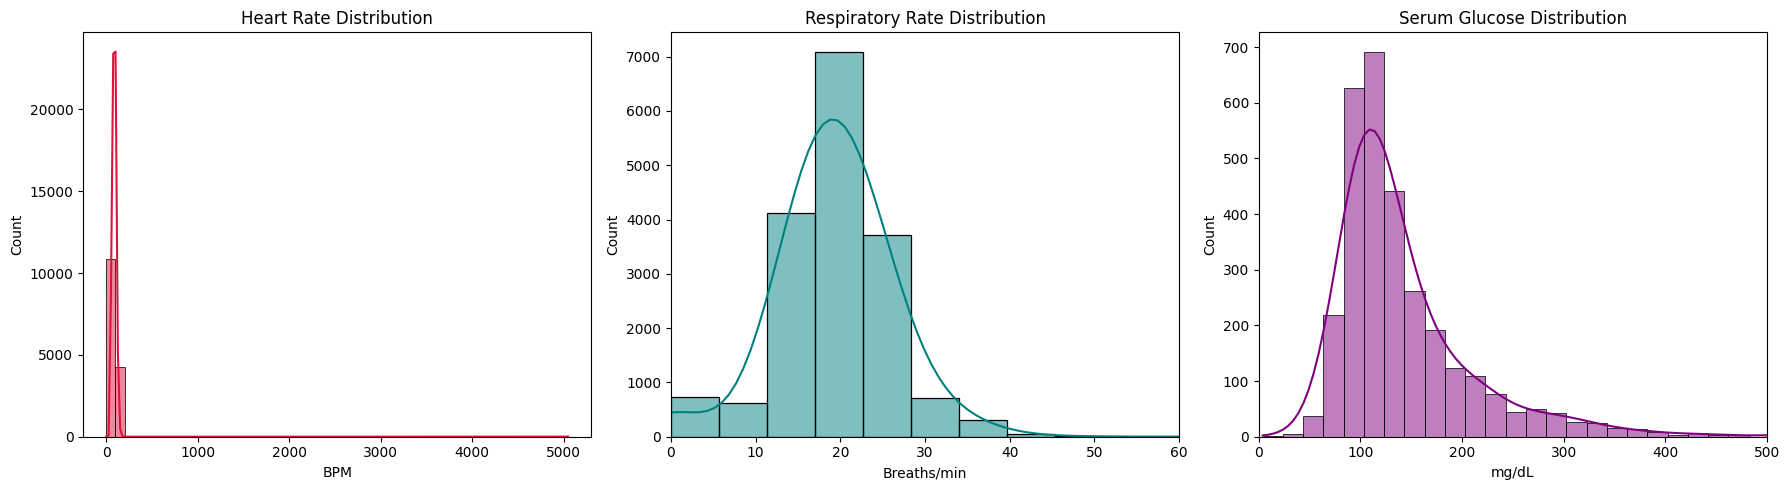

 Generating Time-Series...
 Selected Common Patient: 10003400


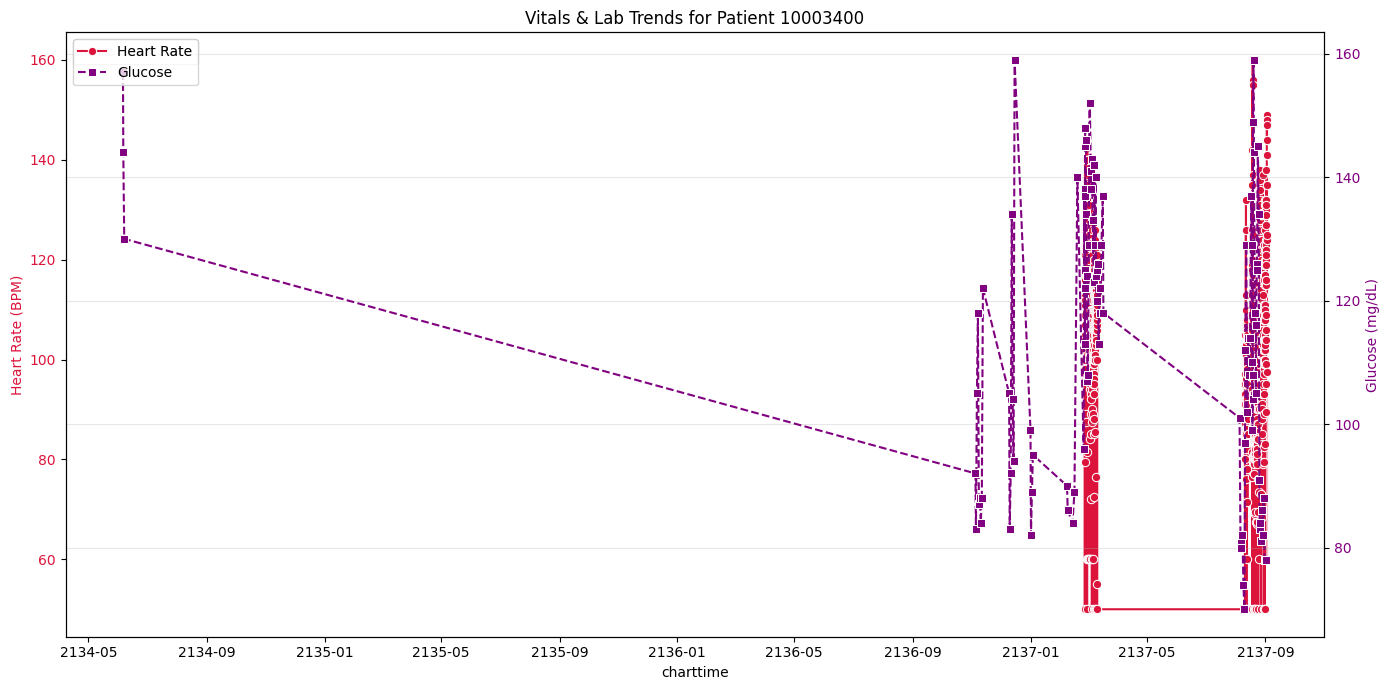


Analysis Complete.


In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# ==========================================
# CONFIGURATION
CHART_FILE = 'Data/Raw_data/chartevents.csv'
LAB_FILE = 'Data/Raw_data/labevents.csv'
D_ITEMS = 'Data/Raw_data/d_items.csv'
D_LABITEMS = 'Data/Raw_data/d_labitems.csv'

# STEP 1: LOAD DATA
print(" Loading Data...")
try:
    d_items = pd.read_csv(D_ITEMS)
    d_labitems = pd.read_csv(D_LABITEMS)
    chartevents = pd.read_csv(CHART_FILE, low_memory=False)
    labevents = pd.read_csv(LAB_FILE, low_memory=False)
    print(" Data Loaded.")
except FileNotFoundError:
    print(" Files not found.")
    exit()

def get_ids(df, column, search_str):
    matches = df[df[column].str.contains(search_str, case=False, na=False)]
    return matches['itemid'].tolist()

# Find IDs
hr_ids = get_ids(d_items, 'label', 'Heart Rate')
rr_ids = get_ids(d_items, 'label', 'Respiratory Rate')
gluc_ids = get_ids(d_labitems, 'label', 'Glucose')

print(f" Found {len(hr_ids)} Heart Rate IDs: {hr_ids}")
print(f" Found {len(rr_ids)} Resp Rate IDs: {rr_ids}")
print(f"Found {len(gluc_ids)} Glucose IDs: {gluc_ids}")
# Vitals
vitals = chartevents[chartevents['itemid'].isin(hr_ids + rr_ids)].copy()
# Merge labels for readability
vitals = vitals.merge(d_items[['itemid', 'label']], on='itemid', how='left')
vitals['valuenum'] = pd.to_numeric(vitals['valuenum'], errors='coerce')
vitals['charttime'] = pd.to_datetime(vitals['charttime'])
vitals = vitals.dropna(subset=['valuenum'])

# Simplify Labels
vitals['Simple_Label'] = vitals['label'].apply(lambda x: 'Heart Rate' if 'Heart Rate' in str(x) else 'Respiratory Rate')

# Labs
labs = labevents[labevents['itemid'].isin(gluc_ids)].copy()
labs['valuenum'] = pd.to_numeric(labs['valuenum'], errors='coerce')
labs['charttime'] = pd.to_datetime(labs['charttime'])
labs = labs.dropna(subset=['valuenum'])

print(f"Extracted {len(vitals)} Vital Records and {len(labs)} Lab Records.")

if len(vitals) == 0 and len(labs) == 0:
    print(" No matching data found in chartevents or labevents. Cannot plot.")
    exit()

# ==========================================
# STEP 4: PLOT DISTRIBUTIONS
# ==========================================
print(" Generating Distribution Plots...")
plt.figure(figsize=(18, 5))

# Plot 1: Heart Rate
plt.subplot(1, 3, 1)
hr_data = vitals[vitals['Simple_Label'] == 'Heart Rate']['valuenum']
if not hr_data.empty:
    sns.histplot(hr_data, bins=50, kde=True, color='crimson')
    plt.title('Heart Rate Distribution')
    plt.xlabel('BPM')
else:
    plt.text(0.5, 0.5, 'No HR Data', ha='center')

# Plot 2: Respiratory Rate
plt.subplot(1, 3, 2)
rr_data = vitals[vitals['Simple_Label'] == 'Respiratory Rate']['valuenum']
if not rr_data.empty:
    sns.histplot(rr_data, bins=30, kde=True, color='teal')
    plt.title('Respiratory Rate Distribution')
    plt.xlabel('Breaths/min')
    plt.xlim(0, 60)
else:
    plt.text(0.5, 0.5, 'No RR Data', ha='center')

# Plot 3: Glucose
plt.subplot(1, 3, 3)
if not labs.empty:
    sns.histplot(labs['valuenum'], bins=50, kde=True, color='purple')
    plt.title('Serum Glucose Distribution')
    plt.xlabel('mg/dL')
    plt.xlim(0, 500)
else:
    plt.text(0.5, 0.5, 'No Glucose Data', ha='center')

plt.tight_layout()
plt.savefig('distribution_plots.png')
plt.show()

print(" Generating Time-Series...")

# Find a patient with data
# We prefer a patient who has BOTH Vitals and Labs
vital_subjs = set(vitals['subject_id'].unique())
lab_subjs = set(labs['subject_id'].unique())
common_subjs = list(vital_subjs.intersection(lab_subjs))

if common_subjs:
    # Pick the one with most records
    target_pat = vitals[vitals['subject_id'].isin(common_subjs)]['subject_id'].value_counts().idxmax()
    print(f" Selected Common Patient: {target_pat}")
elif vital_subjs:
    target_pat = vitals['subject_id'].value_counts().idxmax()
    print(f" Selected Vital-Only Patient: {target_pat}")
elif lab_subjs:
    target_pat = labs['subject_id'].value_counts().idxmax()
    print(f" Selected Lab-Only Patient: {target_pat}")
else:
    print("No patients found.")
    exit()

# Filter Data
pat_vitals = vitals[vitals['subject_id'] == target_pat].sort_values('charttime')
pat_labs = labs[labs['subject_id'] == target_pat].sort_values('charttime')

# Plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Left Axis: Heart Rate
if not pat_vitals.empty:
    hr_pat = pat_vitals[pat_vitals['Simple_Label'] == 'Heart Rate']
    if not hr_pat.empty:
        sns.lineplot(data=hr_pat, x='charttime', y='valuenum', ax=ax1, color='crimson', label='Heart Rate', marker='o')
        ax1.set_ylabel('Heart Rate (BPM)', color='crimson')
        ax1.tick_params(axis='y', labelcolor='crimson')

# Right Axis: Glucose
if not pat_labs.empty:
    ax2 = ax1.twinx()
    sns.lineplot(data=pat_labs, x='charttime', y='valuenum', ax=ax2, color='purple', label='Glucose', marker='s', linestyle='--')
    ax2.set_ylabel('Glucose (mg/dL)', color='purple')
    ax2.tick_params(axis='y', labelcolor='purple')
    # Legend trick
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title(f'Vitals & Lab Trends for Patient {target_pat}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('timeseries_plot.png')
plt.show()

print("\nAnalysis Complete.")

 Loading Data...
 Data Loaded.

--- Top 10 Most Frequent Measurements ---
   itemid                                  label  count
0  227969                        Safety Measures  19330
1  220045                             Heart Rate  13913
2  220210                       Respiratory Rate  13913
3  220277            O2 saturation pulseoxymetry  13540
4  220048                           Heart Rhythm  12460
5  224650                          Ectopy Type 1  11044
6  220180  Non Invasive Blood Pressure diastolic   8349
7  220179   Non Invasive Blood Pressure systolic   8347
8  220181       Non Invasive Blood Pressure mean   8342
9  227958              Less Restrictive Measures   7675
 Generating Barplot...


C:\Users\tssmi\AppData\Local\Temp\ipykernel_21372\2017325981.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='label', data=top_20, palette='viridis')


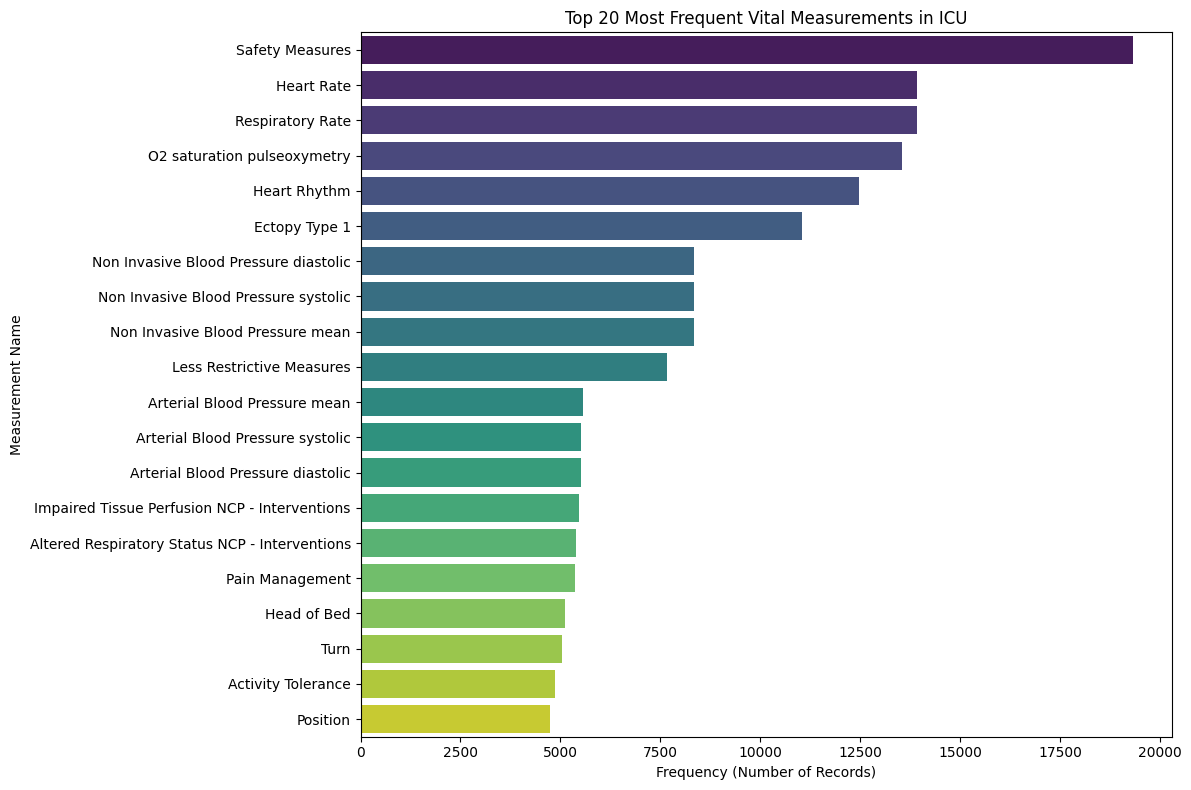


Interpretation:
1. This plot identifies which features are most abundant in your dataset.
2. The top items (usually Heart Rate, SpO2, BP) are the most reliable candidates for  ML model.
3. Items with low frequency might have too many missing values to be useful features.


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


CHART_FILE = 'Data/Raw_data/chartevents.csv'
D_ITEMS = 'Data/Raw_data/d_items.csv'


print(" Loading Data...")
try:
    d_items = pd.read_csv(D_ITEMS)
    chartevents = pd.read_csv(CHART_FILE, low_memory=False) # Load full file or use chunking
    print(" Data Loaded.")
except FileNotFoundError:
    print(" Files not found.")
    exit()


# Count occurrences of each itemid
item_counts = chartevents['itemid'].value_counts().reset_index()
item_counts.columns = ['itemid', 'count']

top_items = item_counts.merge(d_items[['itemid', 'label']], on='itemid', how='left')

# Select Top 20
top_20 = top_items.head(20)

print("\n--- Top 10 Most Frequent Measurements ---")
print(top_20[['itemid', 'label', 'count']].head(10))


print(" Generating Barplot...")

plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='label', data=top_20, palette='viridis')
plt.title('Top 20 Most Frequent Vital Measurements in ICU')
plt.xlabel('Frequency (Number of Records)')
plt.ylabel('Measurement Name')
plt.tight_layout()
plt.savefig('most_frequent_vitals.png')
plt.show()

print("\nInterpretation:")
print("1. This plot identifies which features are most abundant in your dataset.")
print("2. The top items (usually Heart Rate, SpO2, BP) are the most reliable candidates for  ML model.")
print("3. Items with low frequency might have too many missing values to be useful features.")

Loading ICU Data...
Loaded 140 ICU Stays and 668862 Chart Events.

Filtering by Length of Stay...


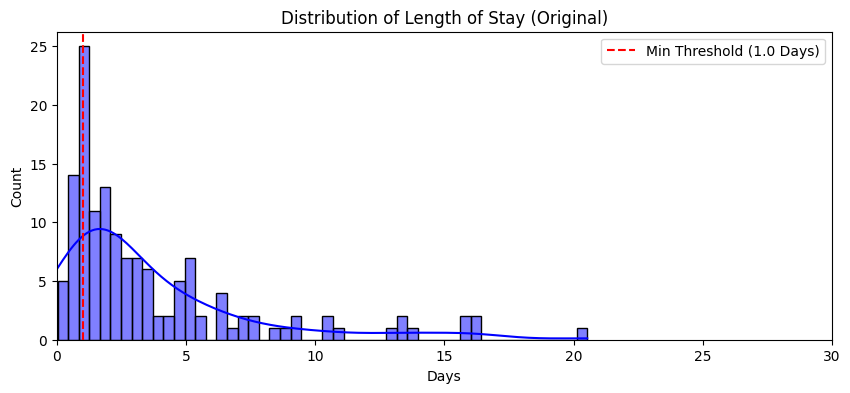

Stays > 1.0 Day: 117 (out of 140)

 Filtering by Data Density (Record Counts)...


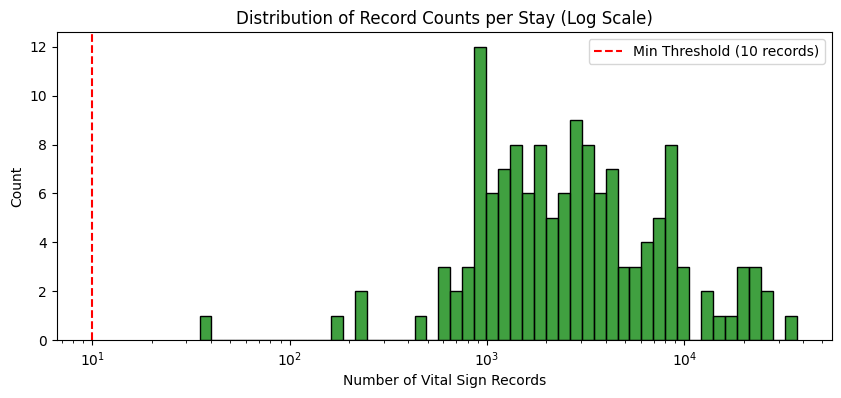

 Stays with > 10 Records: 140

 Calculating Final Valid Cohort...
 Final Valid ICU Stays: 117
 Dropped 23 poor-quality stays.


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# CONFIGURATION

ICUSTAYS_FILE = 'Data/Raw_data/icustays.csv'
CHART_FILE = 'Data/Raw_data/chartevents.csv'

# Thresholds for "Quality Data"
MIN_LOS_DAYS = 1.0       # Minimum Length of Stay (1 Day)
MIN_RECORDS_COUNT = 10   # Minimum Vital Sign Measurements
# STEP 1: LOAD DATA
print("Loading ICU Data...")
try:
    icustays = pd.read_csv(ICUSTAYS_FILE)
    # Load just subject_id, stay_id to save memory while counting
    chartevents = pd.read_csv(CHART_FILE, usecols=['subject_id', 'stay_id', 'itemid'], low_memory=False)
    print(f"Loaded {len(icustays)} ICU Stays and {len(chartevents)} Chart Events.")
except FileNotFoundError:
    print(" Files not found.")
    exit()
# STEP 2: FILTER BY LENGTH OF STAY (LOS)

print("\nFiltering by Length of Stay...")

# Plot LOS Distribution before filtering
plt.figure(figsize=(10, 4))
sns.histplot(icustays['los'], bins=50, kde=True, color='blue')
plt.title('Distribution of Length of Stay (Original)')
plt.xlabel('Days')
plt.xlim(0, 30) # Zoom in
plt.axvline(MIN_LOS_DAYS, color='red', linestyle='--', label=f'Min Threshold ({MIN_LOS_DAYS} Days)')
plt.legend()
plt.show()

# Apply Filter
valid_los_stays = icustays[icustays['los'] >= MIN_LOS_DAYS]['stay_id'].unique()
print(f"Stays > {MIN_LOS_DAYS} Day: {len(valid_los_stays)} (out of {len(icustays)})")
# STEP 3: FILTER BY DATA DENSITY

print("\n Filtering by Data Density (Record Counts)...")

# Count records per stay
stay_counts = chartevents['stay_id'].value_counts()

# Plot Density Distribution
plt.figure(figsize=(10, 4))
sns.histplot(stay_counts, bins=50, color='green', log_scale=True) # Log scale because some stays have 10,000+ records
plt.title('Distribution of Record Counts per Stay (Log Scale)')
plt.xlabel('Number of Vital Sign Records')
plt.axvline(MIN_RECORDS_COUNT, color='red', linestyle='--', label=f'Min Threshold ({MIN_RECORDS_COUNT} records)')
plt.legend()
plt.show()

# Apply Filter
valid_density_stays = stay_counts[stay_counts >= MIN_RECORDS_COUNT].index.tolist()
print(f" Stays with > {MIN_RECORDS_COUNT} Records: {len(valid_density_stays)}")
# STEP 4: INTERSECTION
print("\n Calculating Final Valid Cohort...")

# Find stays that satisfy BOTH conditions
final_valid_stays = list(set(valid_los_stays) & set(valid_density_stays))

print(f" Final Valid ICU Stays: {len(final_valid_stays)}")
print(f" Dropped {len(icustays) - len(final_valid_stays)} poor-quality stays.")



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# CONFIGURATION
CHART_FILE = '      Data/Raw_data/chartevents.csv'
LAB_FILE = '      Data/Raw_data/labevents.csv'
ICUSTAYS_FILE = '      Data/Raw_data/icustays.csv'
D_ITEMS = '      Data/Raw_data/d_items.csv'
D_LABITEMS = '      Data/Raw_data/d_labitems.csv'
try:
    d_items = pd.read_csv(D_ITEMS)
    d_labitems = pd.read_csv(D_LABITEMS)
    icustays = pd.read_csv(ICUSTAYS_FILE)
    # Loading selective columns to save memory
    chartevents = pd.read_csv(CHART_FILE, usecols=['subject_id', 'stay_id', 'charttime', 'itemid', 'valuenum'], low_memory=False)
    labevents = pd.read_csv(LAB_FILE, usecols=['subject_id', 'hadm_id', 'charttime', 'itemid', 'valuenum'], low_memory=False)
except FileNotFoundError:
    print("Files not found.")
    exit()

def get_ids(df, search_str):
    return df[df['label'].str.contains(search_str, case=False, na=False)]['itemid'].tolist()

# Find IDs dynamically
hr_ids = get_ids(d_items, 'Heart Rate')
rr_ids = get_ids(d_items, 'Respiratory Rate')
spo2_ids = get_ids(d_items, 'Saturation')
bp_ids = get_ids(d_items, 'Blood Pressure systolic')
gluc_ids = get_ids(d_labitems, 'Glucose')

print(f"🔹 Found IDs - HR: {len(hr_ids)}, RR: {len(rr_ids)}, SpO2: {len(spo2_ids)}, BP: {len(bp_ids)}, Gluc: {len(gluc_ids)}")

print("Extracting Data...")

# A. Process Vitals
vitals = chartevents[chartevents['itemid'].isin(hr_ids + rr_ids + spo2_ids + bp_ids)].copy()
vitals['charttime'] = pd.to_datetime(vitals['charttime'])
vitals['valuenum'] = pd.to_numeric(vitals['valuenum'], errors='coerce')
vitals = vitals.dropna(subset=['valuenum', 'stay_id'])

# Map Item IDs to a Clean Feature Name
id_map = {}
for i in hr_ids: id_map[i] = 'HeartRate'
for i in rr_ids: id_map[i] = 'RespRate'
for i in spo2_ids: id_map[i] = 'SpO2'
for i in bp_ids: id_map[i] = 'SystolicBP'

vitals['feature'] = vitals['itemid'].map(id_map)

# B. Process Labs (Glucose)
labs = labevents[labevents['itemid'].isin(gluc_ids)].copy()
labs['charttime'] = pd.to_datetime(labs['charttime'])
labs['valuenum'] = pd.to_numeric(labs['valuenum'], errors='coerce')
labs = labs.dropna(subset=['valuenum', 'hadm_id'])
labs['feature'] = 'Glucose'

# C. Link Labs to Stay ID (Critical Step)
print("Linking Labs to ICU Stays...")
# Merge on HADM_ID first
labs_merged = labs.merge(icustays[['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime']], on=['subject_id', 'hadm_id'])
labs_merged['intime'] = pd.to_datetime(labs_merged['intime'])
labs_merged['outtime'] = pd.to_datetime(labs_merged['outtime'])

# Filter: Keep only labs taken DURING the ICU stay
mask = (labs_merged['charttime'] >= labs_merged['intime']) & (labs_merged['charttime'] <= labs_merged['outtime'])
labs_valid = labs_merged[mask][['stay_id', 'charttime', 'valuenum', 'feature']].copy()

# D. Combine
all_data = pd.concat([
    vitals[['stay_id', 'charttime', 'valuenum', 'feature']], 
    labs_valid[['stay_id', 'charttime', 'valuenum', 'feature']]
])

print("Resampling to Hourly Bins...")

# 1. Round time to nearest hour
all_data['charttime'] = all_data['charttime'].dt.round('h')

# 2. Pivot Table (The Heavy Lifting)
# Index = [Stay ID, Time], Columns = [Features]
hourly_data = all_data.pivot_table(index=['stay_id', 'charttime'], columns='feature', values='valuenum', aggfunc='mean')

# 3. Forward Fill (Imputation)
# If a value is missing at 2pm, use the value from 1pm (limit to 24 hours back)
hourly_filled = hourly_data.groupby(level=0).ffill(limit=24)

# 4. Visualization: Raw vs. Resampled
print("Generating Visualization...")

# Pick a patient stay with enough data
stay_counts = all_data['stay_id'].value_counts()
if not stay_counts.empty:
    sample_stay = stay_counts.idxmax()
    
    # Raw Data for this stay (Filter for a specific feature, e.g., HeartRate)
    raw_sample = all_data[(all_data['stay_id'] == sample_stay) & (all_data['feature'] == 'HeartRate')]
    
    # Resampled Data for this stay
    if sample_stay in hourly_filled.index.get_level_values(0):
        resampled_sample = hourly_filled.loc[sample_stay]['HeartRate']
        
        plt.figure(figsize=(14, 6))
        
        # Plot Raw Data (Scatter)
        plt.scatter(raw_sample['charttime'], raw_sample['valuenum'], color='red', label='Raw Data Points (Irregular)', alpha=0.6, zorder=5)
        
        # Plot Resampled Data (Step/Line)
        plt.plot(resampled_sample.index, resampled_sample.values, color='blue', label='Hourly Resampled & Filled', linewidth=2, marker='.', alpha=0.7)
        
        plt.title(f'Data Transformation: Raw vs. Hourly Binned (Stay ID {sample_stay})')
        plt.ylabel('Heart Rate (BPM)')
        plt.xlabel('Time')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('raw_vs_resampled.png')
        plt.show()
    else:
        print(f"Sample stay {sample_stay} not found in resampled data.")
else:
    print("No valid stays found for visualization.")

print(f"Final Shape: {hourly_filled.shape}")
print("Saved to 'icu_hourly_features.csv'. Ready for LSTM Training.")
print("\nSample Output (Hourly Filled):")
print(hourly_filled.head())

Files not found.
🔹 Found IDs - HR: 3, RR: 4, SpO2: 10, BP: 4, Gluc: 13
Extracting Data...


KeyError: 'charttime'

: 


--- 1. ANALYSIS OF MISSINGNESS ---
Percentage of Missing Values (Per Feature):
feature
Glucose       91.021389
HeartRate      0.969988
RespRate       1.052893
SpO2           2.752446
SystolicBP     5.571215
dtype: float64


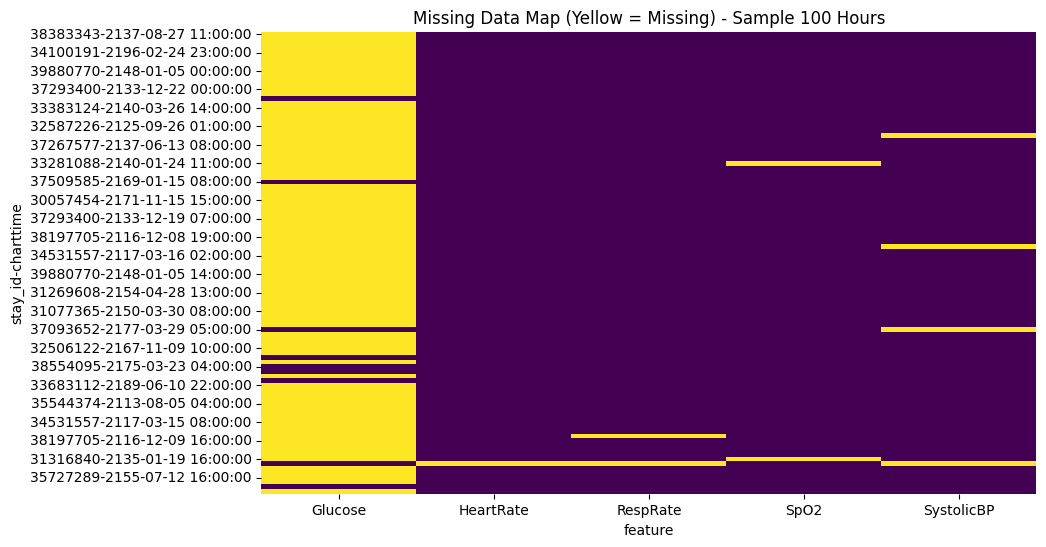


--- 2. APPLYING IMPUTATION ---

Remaining Missing Values (%) after Imputation:
feature
Glucose       3.855082
HeartRate     0.082905
RespRate      0.049743
SpO2          0.074614
SystolicBP    1.475709
dtype: float64
 Saving to: Data/Transformed_data/icu_imputed.csv ...
 Success! File saved.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ==========================================
# CONFIGURATION
# ==========================================

CHART_FILE = 'Data/Raw_data/chartevents.csv'
LAB_FILE = 'Data/Raw_data/labevents.csv'
ICUSTAYS_FILE = 'Data/Raw_data/icustays.csv'
D_ITEMS = 'Data/Raw_data/d_items.csv'
D_LABITEMS = 'Data/Raw_data/d_labitems.csv'

try:
    d_items = pd.read_csv(D_ITEMS)
    d_labitems = pd.read_csv(D_LABITEMS)
    icustays = pd.read_csv(ICUSTAYS_FILE)
    chartevents = pd.read_csv(CHART_FILE, usecols=['subject_id', 'stay_id', 'charttime', 'itemid', 'valuenum'], low_memory=False)
    labevents = pd.read_csv(LAB_FILE, usecols=['subject_id', 'hadm_id', 'charttime', 'itemid', 'valuenum'], low_memory=False)
except:
    print("Files not found.")
    exit()
def get_ids(df, search_str):
    return df[df['label'].str.contains(search_str, case=False, na=False)]['itemid'].tolist()

hr_ids = get_ids(d_items, 'Heart Rate')
rr_ids = get_ids(d_items, 'Respiratory Rate')
spo2_ids = get_ids(d_items, 'Saturation')
bp_ids = get_ids(d_items, 'Blood Pressure systolic')
gluc_ids = get_ids(d_labitems, 'Glucose')

vitals = chartevents[chartevents['itemid'].isin(hr_ids + rr_ids + spo2_ids + bp_ids)].copy()
vitals['valuenum'] = pd.to_numeric(vitals['valuenum'], errors='coerce')
vitals = vitals.dropna(subset=['valuenum', 'stay_id'])
id_map = {}
for i in hr_ids: id_map[i] = 'HeartRate'
for i in rr_ids: id_map[i] = 'RespRate'
for i in spo2_ids: id_map[i] = 'SpO2'
for i in bp_ids: id_map[i] = 'SystolicBP'
vitals['feature'] = vitals['itemid'].map(id_map)

labs = labevents[labevents['itemid'].isin(gluc_ids)].copy()
labs['valuenum'] = pd.to_numeric(labs['valuenum'], errors='coerce')
labs = labs.dropna(subset=['valuenum', 'hadm_id'])
labs['feature'] = 'Glucose'
labs_merged = labs.merge(icustays[['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime']], on=['subject_id', 'hadm_id'])
mask = (labs_merged['charttime'] >= labs_merged['intime']) & (labs_merged['charttime'] <= labs_merged['outtime'])
labs_valid = labs_merged[mask][['stay_id', 'charttime', 'valuenum', 'feature']].copy()

all_data = pd.concat([vitals[['stay_id', 'charttime', 'valuenum', 'feature']], labs_valid[['stay_id', 'charttime', 'valuenum', 'feature']]])
all_data['charttime'] = pd.to_datetime(all_data['charttime']).dt.round('h')

# --- THIS IS THE STARTING POINT FOR STEP 11 ---
# Pivot to create the sparse matrix (lots of NaNs)
hourly_unfilled = all_data.pivot_table(index=['stay_id', 'charttime'], columns='feature', values='valuenum', aggfunc='mean')

# ==========================================
# ANALYSIS: MISSING DATA
# ==========================================
print("\n--- 1. ANALYSIS OF MISSINGNESS ---")
# Calculate % missing
missing_pct = hourly_unfilled.isna().mean() * 100
print("Percentage of Missing Values (Per Feature):")
print(missing_pct)

# Visualization of Missing Data Pattern
plt.figure(figsize=(10, 6))
sns.heatmap(hourly_unfilled.isna().sample(100), cbar=False, cmap='viridis')
plt.title('Missing Data Map (Yellow = Missing) - Sample 100 Hours')
plt.show()

# ==========================================
# IMPUTATION: FORWARD FILL
# ==========================================
print("\n--- 2. APPLYING IMPUTATION ---")


# Apply ffill
hourly_ffill = hourly_unfilled.groupby(level=0).ffill(limit=24)

# Apply bfill (on the result of ffill)
hourly_final = hourly_ffill.groupby(level=0).bfill(limit=2)

# Check stats after
remaining_missing = hourly_final.isna().mean() * 100
print("\nRemaining Missing Values (%) after Imputation:")
print(remaining_missing)
# Fixed the typo: 'Noteboooks' -> 'Notebooks' (or just use 'Data/Transformed')

OUTPUT_PATH = 'Data/Transformed_data/icu_imputed.csv'

print(f" Saving to: {OUTPUT_PATH} ...")

try:
    # 1. Create the directory if it doesn't exist (Safety First)
    os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)
    
    # 2. Save the file
    hourly_final.reset_index().to_csv(OUTPUT_PATH, index=False)
    print(" Success! File saved.")
    
except OSError as e:
    print(f"Error: {e}")
    print(f"   Current Working Directory is: {os.getcwd()}")


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

# CONFIGURATION

# We load the file from the previous step
INPUT_FILE = 'Data/Transformed_data/icu_imputed.csv' 
OUTPUT_FILE = 'Data/Transformed_data/icu_fully_imputed.csv'
# STEP 1: LOAD DATA

print(" Loading Time-Series Imputed Data...")
try:
    df = pd.read_csv(INPUT_FILE)
    
    # --- CRITICAL PREP ---
    # Convert timestamp to datetime
    if 'charttime' in df.columns:
        df['charttime'] = pd.to_datetime(df['charttime'])
    
    # Set Metadata as Index so the Imputer ignores them
    # We only want to calculate the mean of NUMBERS (Glucose, HR), not IDs or Dates.
    df = df.set_index(['stay_id', 'charttime'])
    
    print(f"Loaded Data: {df.shape}")
except FileNotFoundError:
    print(" File not found. Please run the previous Time-Series Imputation step first.")
    exit()

# STEP 2: CHECK REMAINING MISSINGNESS

# These are the gaps that Forward Fill couldn't fix (e.g., missing from the start)
missing_before = df.isna().mean() * 100
print("\nMissing Values Before Mean Imputation (%):")
print(missing_before[missing_before > 0])

if df.isna().sum().sum() == 0:
    print(" No missing values found! Your data is already clean.")
else:
    print(" Missing values detected. Proceeding with Mean Imputation...")

# STEP 3: APPLY MEAN IMPUTATION

print("\n Applying Mean Imputation (Global Average)...")

# Initialize the Imputer (Strategy = 'mean')
imputer = SimpleImputer(strategy='mean')

# Fit and Transform
# This learns the average of 'Glucose', 'HeartRate', etc., and fills NaNs
df_filled_array = imputer.fit_transform(df)

# Reconstruct the DataFrame (Imputer strips names, we put them back)
df_filled = pd.DataFrame(df_filled_array, columns=df.columns, index=df.index)


# STEP 4: VERIFICATION

missing_after = df_filled.isna().sum().sum()
print(f" Imputation Complete. Missing Values Remaining: {missing_after}")

# Compare Statistics (To ensure we didn't distort data)
print("\n--- Statistics Before vs After ---")
print("Original Mean Glucose:", df['Glucose'].mean())
print("Imputed Mean Glucose: ", df_filled['Glucose'].mean())

# STEP 5: SAVE FINAL DATASET

# Reset index to save stay_id and charttime as normal columns
df_filled.reset_index().to_csv(OUTPUT_FILE, index=False)
print(f"\n Saved final dataset to '{OUTPUT_FILE}'")

 Loading Time-Series Imputed Data...
Loaded Data: (12062, 5)

Missing Values Before Mean Imputation (%):
Glucose       3.855082
HeartRate     0.082905
RespRate      0.049743
SpO2          0.074614
SystolicBP    1.475709
dtype: float64
 Missing values detected. Proceeding with Mean Imputation...

 Applying Mean Imputation (Global Average)...
 Imputation Complete. Missing Values Remaining: 0

--- Statistics Before vs After ---
Original Mean Glucose: 145.17293265499697
Imputed Mean Glucose:  145.172932654997

 Saved final dataset to 'Data/Transformed_data/icu_fully_imputed.csv'



Total Missing Values: 0
Missing values per column:
stay_id       0
charttime     0
Glucose       0
HeartRate     0
RespRate      0
SpO2          0
SystolicBP    0
dtype: int64


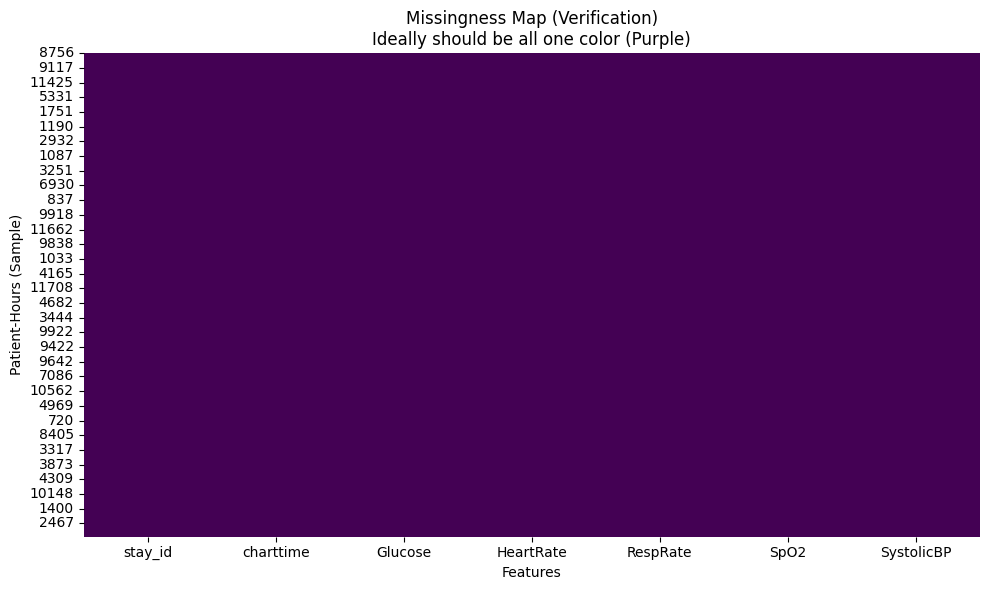


 VERIFICATION PASSED: Dataset is 100% complete.
   You are ready to train your ML/LSTM models.


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the path where you saved the file
# Ideally: 'Data/Transformed_data/icu_fully_imputed.csv'
OUTPUT_FILE = 'Data/Transformed_data/icu_fully_imputed.csv'

try:
    
    df_final = pd.read_csv(OUTPUT_FILE)
    
    # 1. Statistical Verification
    # Count total empty cells in the entire dataframe
    missing_sum = df_final.isna().sum().sum()
    print(f"\nTotal Missing Values: {missing_sum}")
    print("Missing values per column:")
    print(df_final.isna().sum())

    # 2. Visual Verification (Heatmap)
    # We sample 10,000 rows to make the plot render faster
    if len(df_final) > 10000:
        plot_data = df_final.sample(10000)
    else:
        plot_data = df_final

    plt.figure(figsize=(10, 6))
    # 'viridis' colormap: Yellow=True(Missing), Purple=False(Present)
    sns.heatmap(plot_data.isna(), cbar=False, cmap='viridis')
    plt.title('Missingness Map (Verification)\nIdeally should be all one color (Purple)')
    plt.ylabel('Patient-Hours (Sample)')
    plt.xlabel('Features')
    plt.tight_layout()
    plt.show() 
    
    # 3. Final Verdict
    if missing_sum == 0:
        print("\n VERIFICATION PASSED: Dataset is 100% complete.")
        print("   You are ready to train your ML/LSTM models.")
    else:
        print("\nVERIFICATION FAILED: Gaps still exist.")
        print("   Check your Mean Imputation step.")

except FileNotFoundError:
    print(f" File '{OUTPUT_FILE}' not found. Please check the file path.")

Stable Patient: 10027602 (Mean: 137.2, Std: 26.2)
Unstable Patient: 10005348 (Mean: 141.3, Std: 53.2)


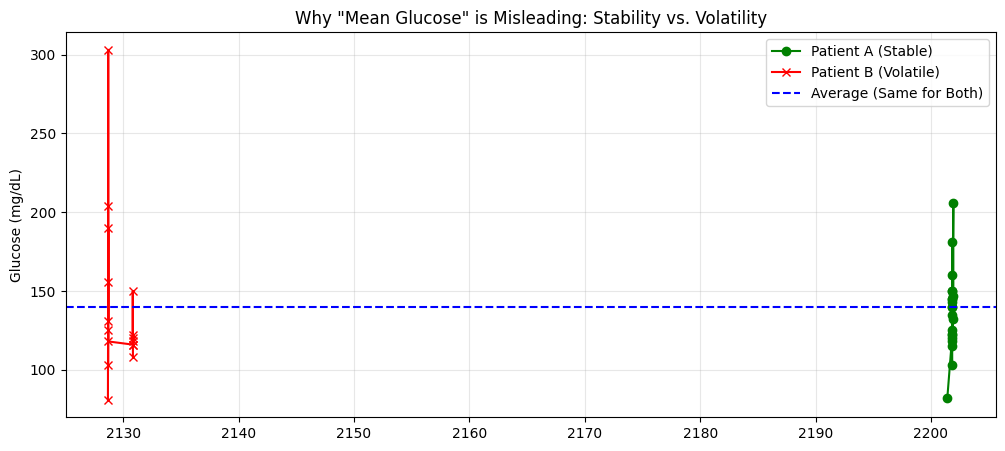

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Labs
try:
    labs = pd.read_csv('Data/Raw_data/labevents.csv', usecols=['subject_id', 'itemid', 'valuenum', 'charttime'])
    # Filter for Glucose (50931)
    glucose = labs[labs['itemid'] == 50931].copy()
    glucose['charttime'] = pd.to_datetime(glucose['charttime'])
except:
    print("Files not found.")
    exit()

# Calculate Metrics per Patient
stats = glucose.groupby('subject_id')['valuenum'].agg(['mean', 'std', 'count'])
stats = stats[stats['count'] > 10] # Need enough data to see variance

# Find two patients with similar Mean but different Std Dev
# Let's filter for Mean around 140 +/- 5
candidates = stats[(stats['mean'] > 135) & (stats['mean'] < 145)].sort_values('std')

if len(candidates) > 2:
    stable_patient = candidates.head(1).index[0]
    unstable_patient = candidates.tail(1).index[0]
    
    print(f"Stable Patient: {stable_patient} (Mean: {candidates.loc[stable_patient]['mean']:.1f}, Std: {candidates.loc[stable_patient]['std']:.1f})")
    print(f"Unstable Patient: {unstable_patient} (Mean: {candidates.loc[unstable_patient]['mean']:.1f}, Std: {candidates.loc[unstable_patient]['std']:.1f})")

    # Plot
    plt.figure(figsize=(12, 5))
    
    # Stable
    p1 = glucose[glucose['subject_id'] == stable_patient].sort_values('charttime')
    plt.plot(p1['charttime'], p1['valuenum'], label='Patient A (Stable)', color='green', marker='o')
    
    # Unstable
    p2 = glucose[glucose['subject_id'] == unstable_patient].sort_values('charttime')
    plt.plot(p2['charttime'], p2['valuenum'], label='Patient B (Volatile)', color='red', marker='x')
    
    plt.axhline(140, color='blue', linestyle='--', label='Average (Same for Both)')
    plt.title('Why "Mean Glucose" is Misleading: Stability vs. Volatility')
    plt.ylabel('Glucose (mg/dL)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Could not find suitable candidates.")

Loading Diagnosis Data...
 Data Loaded.
 Identifying Metabolic Triad Conditions...
   - Found 35 patients with Diabetes (35.0%)
   - Found 73 patients with Hypertension (73.0%)
   - Found 20 patients with Obesity (20.0%)

 Calculating Correlations...

Correlation Matrix:
              Diabetes  Hypertension   Obesity
Diabetes      1.000000      0.257373  0.104828
Hypertension  0.257373      1.000000  0.135147
Obesity       0.104828      0.135147  1.000000

 Generating Heatmap...


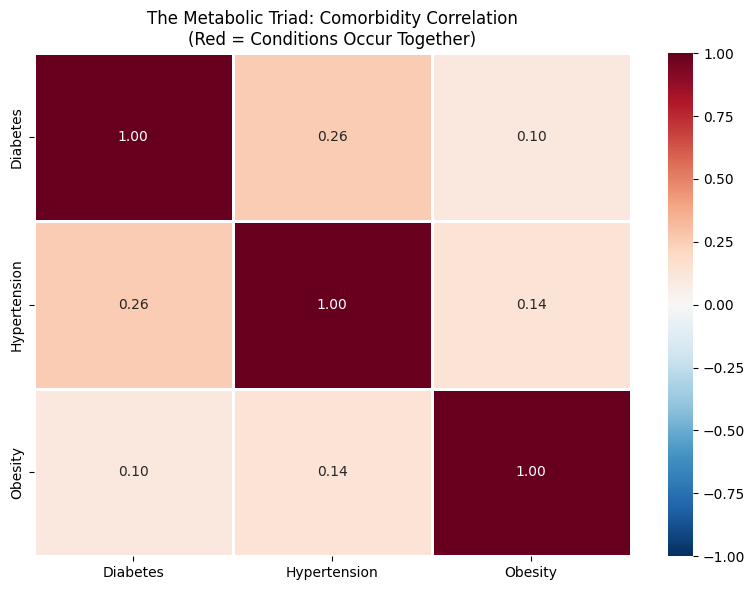


 Heatmap Saved.
Interpretation: Look for RED squares. A high number (e.g., 0.4+) means if a patient has X, they likely have Y.


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# CONFIGURATION
DIAGNOSES_FILE = 'Data/Raw_data/diagnoses_icd.csv'
D_DIAGNOSES_FILE = 'Data/Raw_data/d_icd_diagnoses.csv'
# STEP 1: LOAD DATA
print("Loading Diagnosis Data...")
try:
    diag = pd.read_csv(DIAGNOSES_FILE)
    d_diag = pd.read_csv(D_DIAGNOSES_FILE)
    print(" Data Loaded.")
except FileNotFoundError:
    print(f" Error: Could not find {DIAGNOSES_FILE} or {D_DIAGNOSES_FILE}.")
    exit()
# STEP 2: PREPARE THE TRIAD DATA
print(" Identifying Metabolic Triad Conditions...")

# Merge to get the full names of diseases
# We merge on both code and version to be precise
df = diag.merge(d_diag, on=['icd_code', 'icd_version'], how='left')

# Initialize a DataFrame with all unique patients as the index
patients = df['subject_id'].unique()
triad_df = pd.DataFrame(index=patients)

# Define the search terms for the "Triad"
conditions = {
    'Diabetes': 'diabet',       # Matches "Type 2 diabetes", "Diabetes mellitus"
    'Hypertension': 'hypertens', # Matches "Essential hypertension", "Hypertensive kidney disease"
    'Obesity': 'obesity'        # Matches "Obesity", "Morbid obesity"
}

# Loop through and flag each patient (1 = Has Disease, 0 = Healthy)
for name, term in conditions.items():
    # Find all subject_ids who have a diagnosis matching the term
    sick_patients = df[df['long_title'].str.contains(term, case=False, na=False)]['subject_id'].unique()
    
    # Create the column: 0 by default
    triad_df[name] = 0
    
    # Set to 1 for sick patients
    triad_df.loc[sick_patients, name] = 1
    
    count = triad_df[name].sum()
    print(f"   - Found {count} patients with {name} ({count/len(patients)*100:.1f}%)")


# STEP 3: COMPUTE CORRELATION
print("\n Calculating Correlations...")
# We use Pearson correlation (Phi coefficient for binary data)
correlation_matrix = triad_df.corr()

print("\nCorrelation Matrix:")
print(correlation_matrix)

# STEP 4: VISUALIZE HEATMAP

print("\n Generating Heatmap...")
plt.figure(figsize=(8, 6))

# Draw the heatmap
sns.heatmap(correlation_matrix, 
            annot=True,       # Show the numbers
            cmap='RdBu_r',    # Red = Positive Correlation, Blue = Negative
            center=0,         # White is 0 (No correlation)
            vmin=-1, vmax=1,  # limit the scale
            linewidths=1,     # Add grid lines
            fmt='.2f')        # 2 decimal places

plt.title('The Metabolic Triad: Comorbidity Correlation\n(Red = Conditions Occur Together)')
plt.tight_layout()
plt.savefig('metabolic_triad_heatmap.png')
plt.show()

print("\n Heatmap Saved.")
print("Interpretation: Look for RED squares. A high number (e.g., 0.4+) means if a patient has X, they likely have Y.")

In [6]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# 1. SETUP & LOADING 
RAW = Path('Data/Raw_data')  # Ensure this matches your folder structure

print("Step 1: Loading Data Definitions...")
# We explicitly read the CSVs here to ensure they are DataFrames, not strings
d_items = pd.read_csv(RAW / 'd_items.csv', low_memory=False)
d_labitems = pd.read_csv(RAW / 'd_labitems.csv', low_memory=False)

print("Step 2: Loading Clinical Events (This may take time)...")
chartevents = pd.read_csv(RAW / 'chartevents.csv', low_memory=False)
labevents = pd.read_csv(RAW / 'labevents.csv', low_memory=False)

# --- CLEANING (From your reference code) ---
print("Step 3: Cleaning IDs and Standardizing...")

# Standardize column names
for df in [chartevents, labevents, d_items, d_labitems]:
    df.columns = df.columns.str.lower()

# Ensure ItemIDs are integers (matches your reference logic)
chartevents['itemid'] = pd.to_numeric(chartevents['itemid'], errors='coerce')
chartevents = chartevents.dropna(subset=['itemid'])
chartevents['itemid'] = chartevents['itemid'].astype(int)

# Ensure Timestamps
chartevents['charttime'] = pd.to_datetime(chartevents['charttime'])
labevents['charttime'] = pd.to_datetime(labevents['charttime'])

print(f" Data Loaded & Cleaned. Chart Rows: {len(chartevents)}")
# 2. SMART FILTERING & LINKING
print("\nStep 4: Selecting Target Vitals...")

# We define the IDs we want (Big 5)
POSSIBLE_IDS = {
    'Heart Rate': [220045, 220046, 220047],
    'O2 Saturation': [220277, 220227],
    'Resp Rate': [220210, 224690],
    'Temperature': [223761, 223762],
    'BP Mean': [220181, 220052, 225312],
    'BP Systolic': [220179, 220050],     
    'BP Diastolic': [220180, 220051]     
}

# Find which IDs actually exist in your data
found_item_list = []
selected_map = {}

for vital, candidates in POSSIBLE_IDS.items():
    # Intersection: Find IDs that exist in both your list and the dataframe
    valid_ids = set(candidates).intersection(set(chartevents['itemid'].unique()))
    if valid_ids:
        # Pick the one with the most rows
        best_id = max(valid_ids, key=lambda x: len(chartevents[chartevents['itemid'] == x]))
        found_item_list.append(best_id)
        selected_map[vital] = best_id
        print(f"{vital}: Found ID {best_id}")
    else:
        print(f"{vital}: No data found.")

# Filter FIRST to save memory
df_vitals = chartevents[chartevents['itemid'].isin(found_item_list)].copy()

# --- LINKING (Your Request) ---
# Now we merge with d_items to get the 'label' column, just like your reference
print("Step 5: Linking with d_items (Merging)...")
df_vitals = pd.merge(df_vitals, d_items[['itemid', 'label']], on='itemid', how='left')

print(f"Linked! Sample Labels:\n{df_vitals[['itemid', 'label']].drop_duplicates().head()}")

# ==========================================
# 3. FILLING GAPS (Calculations & Lab Data)
# ==========================================
print("\nStep 6: Processing Gaps...")

# A. Calculate MAP if missing
if 'BP Mean' not in selected_map and 'BP Systolic' in selected_map and 'BP Diastolic' in selected_map:
    print("Mean BP missing. Calculating from Sys/Dias...")
    sys_id = selected_map['BP Systolic']
    dias_id = selected_map['BP Diastolic']
    
    sys_df = chartevents[chartevents['itemid'] == sys_id]
    dias_df = chartevents[chartevents['itemid'] == dias_id]
    
    bp_df = pd.merge(sys_df[['stay_id', 'charttime', 'valuenum']], 
                     dias_df[['stay_id', 'charttime', 'valuenum']], 
                     on=['stay_id', 'charttime'], suffixes=('_sys', '_dias'))
    
    bp_df['valuenum'] = (bp_df['valuenum_sys'] + 2 * bp_df['valuenum_dias']) / 3
    bp_df['itemid'] = 220181 # Standard MAP ID
    bp_df['label'] = "Calculated MAP" # Adding label since we just linked
    
    df_vitals = pd.concat([df_vitals, bp_df])
    selected_map['BP Mean'] = 220181
    print(f"Calculated MAP for {len(bp_df)} points.")

# B. Use Labevents for O2 (Backup)
if 'O2 Saturation' not in selected_map:
    print("Chart O2 missing. Checking Labs...")
    lab_o2 = labevents[labevents['itemid'].isin([50817, 50821])].copy()
    if not lab_o2.empty:
        lab_o2['itemid'] = 220277
        lab_o2['label'] = "Lab O2 Saturation"
        df_vitals = pd.concat([df_vitals, lab_o2[['stay_id', 'charttime', 'itemid', 'valuenum', 'label']]])
        selected_map['O2 Saturation'] = 220277
        print(f"Recovered {len(lab_o2)} rows from Labs.")

# ==========================================
# 4. TENSOR CONSTRUCTION
# ==========================================
print("\nStep 7: Building 24h Matrix...")

# Final Target Map
final_ids = [v for k, v in selected_map.items() if k in ['Heart Rate', 'BP Mean', 'Resp Rate', 'O2 Saturation', 'Temperature']]
final_features = [k for k, v in selected_map.items() if k in ['Heart Rate', 'BP Mean', 'Resp Rate', 'O2 Saturation', 'Temperature']]

matrices = []
valid_stay_ids = []

# Process per patient
for sid in df_vitals['stay_id'].unique():
    s_df = df_vitals[df_vitals['stay_id'] == sid]
    start_time = s_df['charttime'].min()
    
    s_df = s_df.copy()
    s_df['hour'] = (s_df['charttime'] - start_time).dt.total_seconds() // 3600
    s_df = s_df[(s_df['hour'] >= 0) & (s_df['hour'] < 24)]
    
    # Pivot
    pivot = s_df.pivot_table(index='hour', columns='itemid', values='valuenum', aggfunc='mean')
    pivot = pivot.reindex(index=range(24), columns=final_ids)
    pivot = pivot.ffill().bfill().fillna(0)
    
    if pivot.shape == (24, len(final_ids)):
        matrices.append(pivot.values.astype(np.float32))
        valid_stay_ids.append(sid)

if matrices:
    X = np.stack(matrices)
    print(f" Final Tensor Shape: {X.shape} (Features: {final_features})")
else:
    print(" Matrix generation failed. Check data availability.")

Step 1: Loading Data Definitions...
Step 2: Loading Clinical Events (This may take time)...
Step 3: Cleaning IDs and Standardizing...
 Data Loaded & Cleaned. Chart Rows: 668862

Step 4: Selecting Target Vitals...
Heart Rate: Found ID 220045
O2 Saturation: Found ID 220277
Resp Rate: Found ID 220210
Temperature: Found ID 223761
BP Mean: Found ID 220181
BP Systolic: Found ID 220179
BP Diastolic: Found ID 220180
Step 5: Linking with d_items (Merging)...
Linked! Sample Labels:
    itemid                                 label
0   220210                      Respiratory Rate
1   220045                            Heart Rate
2   220277           O2 saturation pulseoxymetry
45  220181      Non Invasive Blood Pressure mean
48  220179  Non Invasive Blood Pressure systolic

Step 6: Processing Gaps...

Step 7: Building 24h Matrix...
 Final Tensor Shape: (140, 24, 5) (Features: ['Heart Rate', 'O2 Saturation', 'Resp Rate', 'Temperature', 'BP Mean'])


Visualizing First Patient...

--- Clinical Snapshot (Stay ID: 32604416) ---
Vital           | Mean     | Min      | Max     
--------------------------------------------------
Heart Rate      |     78.1 |     63.0 |     88.0
O2 Saturation   |     95.6 |     91.0 |    100.0
Resp Rate       |     19.5 |     14.0 |     25.0
Temperature     |      0.0 |      0.0 |      0.0
BP Mean         |     57.6 |     57.0 |     70.5


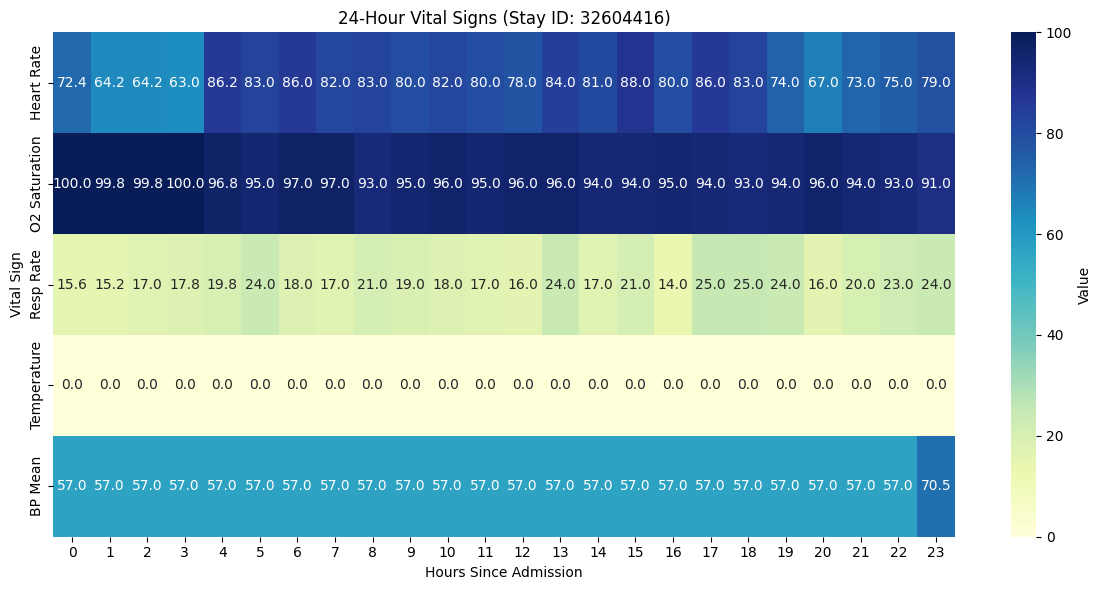


Visualizing Random Patient (Index 21)...

--- Clinical Snapshot (Stay ID: 36059427) ---
Vital           | Mean     | Min      | Max     
--------------------------------------------------
Heart Rate      |     83.9 |     73.0 |    104.0
O2 Saturation   |     98.1 |     95.0 |    100.0
Resp Rate       |     27.8 |     24.0 |     35.5
Temperature     |     99.0 |     97.8 |     99.7
BP Mean         |     88.5 |     88.5 |     88.5


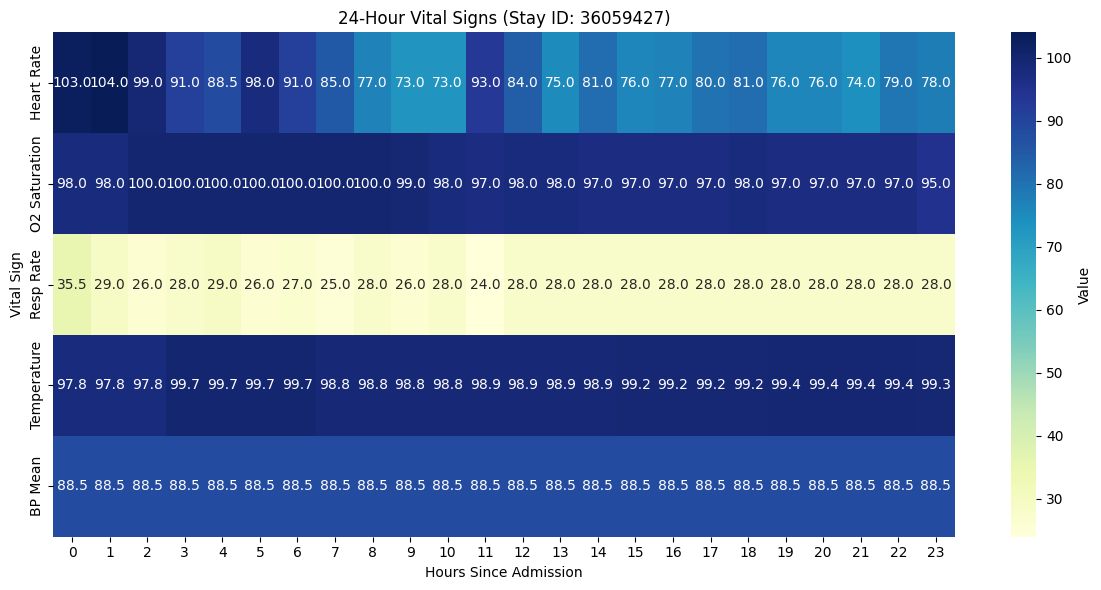

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# TASK 5: VISUALIZE MULTI-VARIATE SAMPLE
def visualize_patient_stay(matrix_X, patient_ids, feature_names, patient_index=0):
    # 1. Check if index is valid
    if patient_index >= len(matrix_X):
        print(f"Error: Index {patient_index} is out of bounds. You have {len(matrix_X)} patients.")
        return

    # 2. Extract Data
    # Shape is (24 hours, 5 features). We Transpose (.T) for easier plotting (Features x Time)
    data = matrix_X[patient_index].T 
    stay_id = patient_ids[patient_index]
    
    # 3. Text Summary
    print(f"\n--- Clinical Snapshot (Stay ID: {stay_id}) ---")
    print(f"{'Vital':<15} | {'Mean':<8} | {'Min':<8} | {'Max':<8}")
    print("-" * 50)
    
    for i, name in enumerate(feature_names):
        row = data[i, :]
        print(f"{name:<15} | {row.mean():8.1f} | {row.min():8.1f} | {row.max():8.1f}")

    # 4. Plot Heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(data, annot=True, fmt=".1f", cmap="YlGnBu", 
                xticklabels=range(24), yticklabels=feature_names,
                cbar_kws={'label': 'Value'})
    
    plt.title(f"24-Hour Vital Signs (Stay ID: {stay_id})")
    plt.xlabel("Hours Since Admission")
    plt.ylabel("Vital Sign")
    plt.tight_layout()
    plt.show()
# We check '0' (First patient) and maybe '10' (11th patient) to verify consistency
print("Visualizing First Patient...")
visualize_patient_stay(X, valid_stay_ids, final_features, patient_index=0)

# Optional: Visualize a random patient to ensu  re the first one wasn't a fluke
import random
random_idx = random.randint(0, len(X)-1)
print(f"\nVisualizing Random Patient (Index {random_idx})...")
visualize_patient_stay(X, valid_stay_ids, final_features, patient_index=random_idx)

In [8]:
import pandas as pd
import numpy as np
from pathlib import Path

# ==========================================
# 1. SETUP & LOADING (Fixing the Error)
# ==========================================
print("Loading Lab Definitions and Data...")

# Define paths first (as strings)
path_d_labitems = 'Data/Raw_data/d_labitems.csv'
path_labevents = 'Data/Raw_data/labevents.csv'
path_icustays = 'Data/Raw_data/icustays.csv'

# READ the files into DataFrames (This was the missing step)
d_labitems = pd.read_csv(path_d_labitems, low_memory=False)
labevents = pd.read_csv(path_labevents, low_memory=False)
icustays = pd.read_csv(path_icustays, low_memory=False)

# NOW you can standardize columns because they are DataFrames
for df in [d_labitems, labevents, icustays]:
    df.columns = df.columns.str.lower()

# Ensure timestamps
labevents['charttime'] = pd.to_datetime(labevents['charttime'])
icustays['intime'] = pd.to_datetime(icustays['intime'])

print(f"Data Loaded. Lab Rows: {len(labevents)}")

# ==========================================
# TASK 1: IDENTIFY IMPORTANT LAB ITEM IDS
# ==========================================
print("\nStep 2: Identifying Lab IDs...")

TARGET_LAB_NAMES = {
    'Glucose': 'glucose',
    'Sodium': 'sodium',
    'Potassium': 'potassium',
    'Creatinine': 'creatinine',
    'Hemoglobin': 'hemoglobin',
    'WBC': 'white blood'
}

target_lab_ids = {}

for label, search_term in TARGET_LAB_NAMES.items():
    matches = d_labitems[d_labitems['label'].str.contains(search_term, case=False, na=False)]
    
    best_id = None
    # Standard MIMIC-IV IDs
    if label == 'Glucose': best_id = 50931
    elif label == 'Sodium': best_id = 50983
    elif label == 'Potassium': best_id = 50971
    elif label == 'Creatinine': best_id = 50912
    elif label == 'Hemoglobin': best_id = 51222
    elif label == 'WBC': best_id = 51301
    elif label == 'Lactate': best_id = 50813
    
    if best_id and best_id in matches['itemid'].values:
        target_lab_ids[label] = best_id
        print(f"{label}: Found ID {best_id}")
    elif not matches.empty:
        best_id = matches['itemid'].iloc[0]
        target_lab_ids[label] = best_id
        print(f"{label}: Standard ID missing. Using ID {best_id}")
    else:
        print(f"{label}: No matching ID found.")

print(f"Selected IDs: {target_lab_ids}")
# TASK 2: EXTRACT 24-HOUR LAB SIGNALS
print("\nStep 3: Extracting 24-Hour Signals...")

# A. Link Labevents to ICU Stays (via HADM_ID)
labs_merged = pd.merge(labevents, icustays[['stay_id', 'hadm_id', 'intime']], on='hadm_id', how='inner')

# B. Filter to just the IDs we selected
final_lab_ids = list(target_lab_ids.values())
labs_merged = labs_merged[labs_merged['itemid'].isin(final_lab_ids)].copy()

# C. Calculate Hour Offset
labs_merged['hour'] = (labs_merged['charttime'] - labs_merged['intime']).dt.total_seconds() // 3600

# D. Filter 0-24 Hours
labs_merged = labs_merged[(labs_merged['hour'] >= 0) & (labs_merged['hour'] < 24)]

# E. Create Matrix
lab_matrices = []
lab_stay_ids = []
sorted_lab_names = [k for k, v in target_lab_ids.items()] 
sorted_lab_ids = [target_lab_ids[k] for k in sorted_lab_names]

unique_stays = labs_merged['stay_id'].unique()
print(f"Processing {len(unique_stays)} patients with lab data...")

for sid in unique_stays:
    p_labs = labs_merged[labs_merged['stay_id'] == sid]
    
    # Pivot (Hour x Item)
    pivot = p_labs.pivot_table(index='hour', columns='itemid', values='valuenum', aggfunc='mean')
    
    # Reindex (Force 24h, Specific Cols)
    pivot = pivot.reindex(index=range(24), columns=sorted_lab_ids)
    
    # Impute (Forward -> Backward -> Zero)
    pivot = pivot.ffill().bfill().fillna(0)
    
    if pivot.shape == (24, len(sorted_lab_ids)):
        lab_matrices.append(pivot.values.astype(np.float32))
        lab_stay_ids.append(sid)

# Stack into Tensor
if lab_matrices:
    X_labs = np.stack(lab_matrices)
    print("\n" + "="*30)
    print(f"LAB TENSOR CREATED: {X_labs.shape}")
    print(f"Features: {sorted_lab_names}")
else:
    print("Failed to create Lab Tensor.")

Loading Lab Definitions and Data...
Data Loaded. Lab Rows: 107727

Step 2: Identifying Lab IDs...
Glucose: Found ID 50931
Sodium: Found ID 50983
Potassium: Found ID 50971
Creatinine: Found ID 50912
Hemoglobin: Found ID 51222
WBC: Found ID 51301
Selected IDs: {'Glucose': 50931, 'Sodium': 50983, 'Potassium': 50971, 'Creatinine': 50912, 'Hemoglobin': 51222, 'WBC': 51301}

Step 3: Extracting 24-Hour Signals...
Processing 139 patients with lab data...

LAB TENSOR CREATED: (139, 24, 6)
Features: ['Glucose', 'Sodium', 'Potassium', 'Creatinine', 'Hemoglobin', 'WBC']


In [9]:
import pandas as pd
import numpy as np
# 3. HOURLY RESAMPLING (MEAN)
sorted_lab_ids = sorted(list(target_lab_ids.values()))
sorted_lab_names = [k for k, v in target_lab_ids.items() if v in sorted_lab_ids]

lab_matrices = []
lab_stay_ids = []

unique_stays = labs_merged['stay_id'].unique()

for sid in unique_stays:
    # 1. Get one patient's data
    p_labs = labs_merged[labs_merged['stay_id'] == sid]
    # STEP 3: HOURLY RESAMPLING (MEAN)
    pivot = p_labs.pivot_table(index='hour', columns='itemid', values='valuenum', aggfunc='mean')
    pivot = pivot.reindex(index=range(24), columns=sorted_lab_ids)
    # STEP 4: IMPUTE MISSING LABS
    pivot = pivot.ffill()  
    pivot = pivot.bfill()  
    pivot = pivot.fillna(0) 
    
    # Store the clean matrix
    if pivot.shape == (24, len(sorted_lab_ids)):
        lab_matrices.append(pivot.values.astype(np.float32))
        lab_stay_ids.append(sid)

# Final Output
if lab_matrices:
    X_labs = np.stack(lab_matrices)
    print(f"Processing Complete.")
    print(f"Final Shape: {X_labs.shape} (Patients, 24 Hours, {len(sorted_lab_ids)} Labs)")
    print(f"Lab Order: {sorted_lab_names}")
else:
    print(" Error: No matrices created.")

Processing Complete.
Final Shape: (139, 24, 6) (Patients, 24 Hours, 6 Labs)
Lab Order: ['Glucose', 'Sodium', 'Potassium', 'Creatinine', 'Hemoglobin', 'WBC']


In [10]:
import pandas as pd
import numpy as np
from pathlib import Path
# 1. SETUP & LOADING
d_items_path = 'Data/Raw_data/d_items.csv'
d_labitems_path = 'Data/Raw_data/d_labitems.csv'
chartevents_path = 'Data/Raw_data/chartevents.csv'
labevents_path = 'Data/Raw_data/labevents.csv'
icustays_path = 'Data/Raw_data/icustays.csv'
admissions_path = 'Data/Raw_data/admissions.csv'
#1. LOAD DATA
d_items = pd.read_csv(d_items_path, low_memory=False)
d_labitems = pd.read_csv(d_labitems_path, low_memory=False)
chartevents = pd.read_csv(chartevents_path, low_memory=False)
labevents = pd.read_csv(labevents_path, low_memory=False)
icustays = pd.read_csv(icustays_path, low_memory=False)
admissions = pd.read_csv(admissions_path, low_memory=False)
#
for df in [d_items, d_labitems, chartevents, labevents, icustays, admissions]:
    df.columns = df.columns.str.lower()

# Convert datetimes
chartevents['charttime'] = pd.to_datetime(chartevents['charttime'])
labevents['charttime'] = pd.to_datetime(labevents['charttime'])
icustays['intime'] = pd.to_datetime(icustays['intime'])

print(f" Data Loaded.")
# 2. EXTRACT VITALS (X)
print("\nStep 2: Processing Vitals...")

# Define Target IDs (Big 5)
VITAL_IDS = {
    'Heart Rate': [220045],
    'MAP': [220181, 220052, 225312],
    'Resp Rate': [220210],
    'O2 Sat': [220277],
    'Temp': [223761, 223762]
}
final_vital_ids = {}
found_vital_list = []

for label, candidates in VITAL_IDS.items():
    # Find which candidate exists
    valid = [cid for cid in candidates if cid in chartevents['itemid'].unique()]
    if valid:
        final_vital_ids[label] = valid[0] # Pick the first one found
        found_vital_list.append(valid[0])
    else:
        print(f"Warning: {label} missing from chartevents.")
df_vitals = chartevents[chartevents['itemid'].isin(found_vital_list)].copy()
vital_matrices = []
valid_stay_ids = []
sorted_vital_names = list(final_vital_ids.keys())
sorted_vital_ids = list(final_vital_ids.values())
for sid in df_vitals['stay_id'].unique():
    s_df = df_vitals[df_vitals['stay_id'] == sid]
    start_time = s_df['charttime'].min()
    s_df = s_df.copy()
    s_df['hour'] = (s_df['charttime'] - start_time).dt.total_seconds() // 3600
    s_df = s_df[(s_df['hour'] >= 0) & (s_df['hour'] < 24)]
    pivot = s_df.pivot_table(index='hour', columns='itemid', values='valuenum', aggfunc='mean')
    pivot = pivot.reindex(index=range(24), columns=sorted_vital_ids)
    pivot = pivot.ffill().bfill().fillna(0)
    
    if pivot.shape == (24, len(sorted_vital_ids)):
        vital_matrices.append(pivot.values.astype(np.float32))
        valid_stay_ids.append(sid)

X = np.stack(vital_matrices)
print(f"Vitals Tensor Created: {X.shape}")
print("\nStep 3: Processing Labs...")

LAB_IDS = {
    'Glucose': 50931, 'Sodium': 50983, 'Potassium': 50971,
    'Creatinine': 50912, 'Hemoglobin': 51222, 'WBC': 51301,'Lactate': 50813
}
labs_merged = pd.merge(labevents, icustays[['stay_id', 'hadm_id', 'intime']], on='hadm_id', how='inner')
labs_merged = labs_merged[labs_merged['itemid'].isin(LAB_IDS.values())].copy()
lab_matrices = []
lab_stay_ids = []
sorted_lab_names = list(LAB_IDS.keys())
sorted_lab_ids = list(LAB_IDS.values())

for sid in labs_merged['stay_id'].unique():
    p_labs = labs_merged[labs_merged['stay_id'] == sid]
    p_labs = p_labs.copy()
    p_labs['hour'] = (p_labs['charttime'] - p_labs['intime']).dt.total_seconds() // 3600
    p_labs = p_labs[(p_labs['hour'] >= 0) & (p_labs['hour'] < 24)]
    pivot = p_labs.pivot_table(index='hour', columns='itemid', values='valuenum', aggfunc='mean')
    pivot = pivot.reindex(index=range(24), columns=sorted_lab_ids)
    pivot = pivot.ffill().bfill().fillna(0)
    
    if pivot.shape == (24, len(sorted_lab_ids)):
        lab_matrices.append(pivot.values.astype(np.float32))
        lab_stay_ids.append(sid)

X_labs = np.stack(lab_matrices)
print(f"Labs Tensor Created: {X_labs.shape}")
print("\nStep 4: Merging Vitals & Labs...")
vitals_set = set(valid_stay_ids)
labs_set = set(lab_stay_ids)
common_ids = sorted(list(vitals_set.intersection(labs_set)))

print(f"Patients with Vitals: {len(valid_stay_ids)}")
print(f"Patients with Labs:   {len(lab_stay_ids)}")
print(f"Intersection (Both):  {len(common_ids)}")

if len(common_ids) == 0:
    print(" Critical Error: No common patients found. Check your data extraction.")
else:
    v_map = {sid: i for i, sid in enumerate(valid_stay_ids)}
    l_map = {sid: i for i, sid in enumerate(lab_stay_ids)}
    
    final_matrices = []
    
    for sid in common_ids:
        v_idx = v_map[sid]
        l_idx = l_map[sid]
        patient_combined = np.concatenate([X[v_idx], X_labs[l_idx]], axis=1)
        final_matrices.append(patient_combined)
        
    X_final = np.stack(final_matrices)
    final_features = sorted_vital_names + sorted_lab_names
    final_stay_ids = common_ids
    
    print("-" * 30)
    print(f"FINAL DATASET READY: {X_final.shape}")
    print(f"Features: {final_features}")

 Data Loaded.

Step 2: Processing Vitals...
Vitals Tensor Created: (140, 24, 5)

Step 3: Processing Labs...
Labs Tensor Created: (140, 24, 7)

Step 4: Merging Vitals & Labs...
Patients with Vitals: 140
Patients with Labs:   140
Intersection (Both):  140
------------------------------
FINAL DATASET READY: (140, 24, 12)
Features: ['Heart Rate', 'MAP', 'Resp Rate', 'O2 Sat', 'Temp', 'Glucose', 'Sodium', 'Potassium', 'Creatinine', 'Hemoglobin', 'WBC', 'Lactate']


Generating Lab Statistics...
Patient Counts per Lab:
itemid
Creatinine    140
Glucose       140
Potassium     140
Hemoglobin    140
Sodium        140
WBC           140
Lactate       103
Name: stay_id, dtype: int64


C:\Users\tssmi\AppData\Local\Temp\ipykernel_8336\3938540577.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lab_counts.index, y=lab_counts.values, palette="viridis")


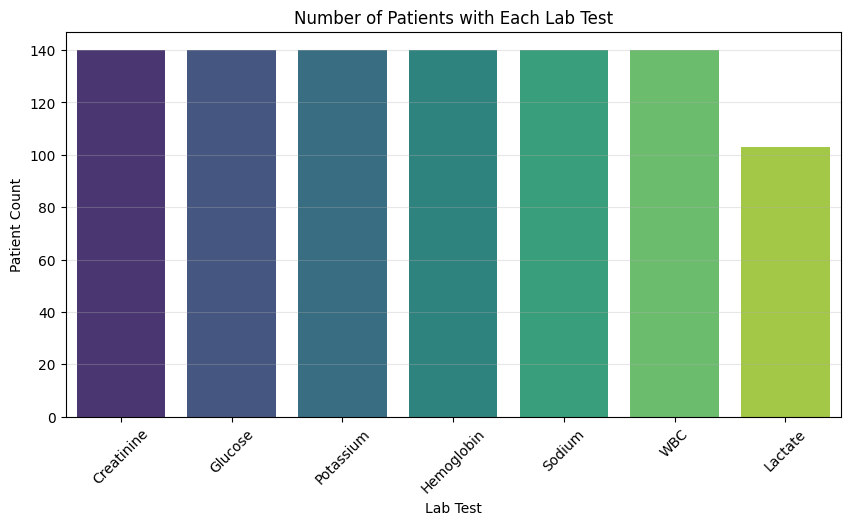

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# TASK 3 & 5: LAB FREQUENCY & BAR PLOT
# ==========================================
print("Generating Lab Statistics...")

# 1. Count patients per Lab Test (using the raw merged lab dataframe)
# Ensure 'labs_merged' exists from the previous step
if 'labs_merged' in locals():
    # Count unique stay_ids for each itemid
    lab_counts = labs_merged.groupby('itemid')['stay_id'].nunique().sort_values(ascending=False)
    
    # Map IDs back to Names for readable plots
    # Invert the dictionary: {50931: 'Glucose', ...}
    id_to_name = {v: k for k, v in LAB_IDS.items()} 
    lab_counts.index = lab_counts.index.map(id_to_name)
    
    print("Patient Counts per Lab:")
    print(lab_counts)

    # 2. Bar Plot
    plt.figure(figsize=(10, 5))
    sns.barplot(x=lab_counts.index, y=lab_counts.values, palette="viridis")
    plt.title("Number of Patients with Each Lab Test")
    plt.ylabel("Patient Count")
    plt.xlabel("Lab Test")
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.show()
else:
    print(" 'labs_merged' dataframe not found. Cannot plot frequencies.")

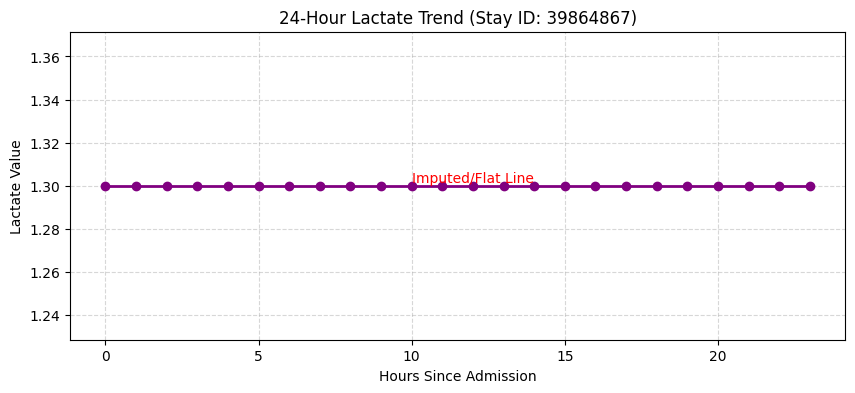

In [12]:
# ==========================================
# TASK 8 & 9: INSPECT & PLOT SAMPLE
# ==========================================

def plot_patient_lab(patient_index, lab_name='Lactate'):
    # 1. Find the column index for the requested lab
    # We need to know which column in the "Labs Tensor" (X_labs) corresponds to 'Glucose'
    if lab_name not in sorted_lab_names:
        print(f"Error: {lab_name} is not in your extracted labs: {sorted_lab_names}")
        return

    col_idx = sorted_lab_names.index(lab_name)
    
    # 2. Extract Data
    # X_labs shape: (Patients, 24 Hours, 6 Labs)
    patient_data = X_labs[patient_index, :, col_idx]
    stay_id = lab_stay_ids[patient_index]
    
    # 3. Plot
    plt.figure(figsize=(10, 4))
    plt.plot(range(24), patient_data, marker='o', linestyle='-', color='purple', linewidth=2)
    
    plt.title(f"24-Hour {lab_name} Trend (Stay ID: {stay_id})")
    plt.xlabel("Hours Since Admission")
    plt.ylabel(f"{lab_name} Value")
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Check if data is imputed (flat line)
    if np.std(patient_data) == 0:
        plt.text(12, patient_data[0], "Imputed/Flat Line", color='red', ha='center', va='bottom')
        
    plt.show()

# Run the plot for the first patient
plot_patient_lab(patient_index=0, lab_name='Lactate')

In [13]:
import os

# ==========================================
# TASK 12: SAVE DATASET
# ==========================================
print("Saving Processed Data...")

SAVE_DIR = Path('Data/Transformed_data/Processed')
os.makedirs(SAVE_DIR, exist_ok=True)

# 1. Save the Tensors (X and y)
np.save(SAVE_DIR / 'X_final.npy', X_final)
# We need to generate y for the *intersection* of patients (common_ids)
# (Re-running the label generation for just the final list of patients)
final_ids_df = pd.DataFrame(final_stay_ids, columns=['stay_id'])
merged_y = final_ids_df.merge(icustays[['stay_id', 'hadm_id']], on='stay_id', how='left')
merged_y = merged_y.merge(admissions[['hadm_id', 'hospital_expire_flag']], on='hadm_id', how='left')
y_final = merged_y['hospital_expire_flag'].fillna(0).values.astype(np.float32)

np.save(SAVE_DIR / 'y_final.npy', y_final)

# 2. Save the Metadata (IDs and Feature Names)
# We save IDs as a CSV so we can look them up later
pd.DataFrame(final_stay_ids, columns=['stay_id']).to_csv(SAVE_DIR / 'stay_ids.csv', index=False)

# Save feature names as a text file
with open(SAVE_DIR / 'feature_names.txt', 'w') as f:
    for feat in final_features:
        f.write(f"{feat}\n")

print("-" * 30)
print(f"SAVE COMPLETE!")
print(f"  - X Saved to: {SAVE_DIR / 'X_final.npy'}")
print(f"  - y Saved to: {SAVE_DIR / 'y_final.npy'}")
print(f"  - IDs Saved to: {SAVE_DIR / 'stay_ids.csv'}")

Saving Processed Data...
------------------------------
SAVE COMPLETE!
  - X Saved to: Data\Transformed_data\Processed\X_final.npy
  - y Saved to: Data\Transformed_data\Processed\y_final.npy
  - IDs Saved to: Data\Transformed_data\Processed\stay_ids.csv


In [14]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ==========================================
# 1. SETUP & LOAD PREVIOUS DATA
# ==========================================
print("Step 1: Loading Previous Processed Data...")
RAW = Path('Data/Raw_data')
PROCESSED = Path('Data/Transformed_data/Processed')

# Load the data we saved yesterday
# (If X_final is already in memory, you can skip loading it, but this is safer)
try:
    X_prev = np.load(PROCESSED / 'X_final.npy')
    stay_ids_df = pd.read_csv(PROCESSED / 'stay_ids.csv')
    stay_ids_prev = stay_ids_df['stay_id'].values
    print(f"Loaded Previous Tensor: {X_prev.shape} (Patients, 24h, Features)")
except FileNotFoundError:
    print("Error: Could not find 'X_final.npy'. Please run the Vitals+Labs code first.")
    raise

# ==========================================
# 2. LOAD RAW INPUT/OUTPUT DATA
# ==========================================
print("\nStep 2: Loading Raw Fluid Data...")
# We assume these files exist in your RAW folder
inputevents = pd.read_csv(RAW / 'inputevents.csv', low_memory=False)
outputevents = pd.read_csv(RAW / 'outputevents.csv', low_memory=False)
icustays = pd.read_csv(RAW / 'icustays.csv', low_memory=False)

# Standardize
for df in [inputevents, outputevents, icustays]:
    df.columns = df.columns.str.lower()

# Time Conversion
inputevents['starttime'] = pd.to_datetime(inputevents['starttime'])
outputevents['charttime'] = pd.to_datetime(outputevents['charttime'])
icustays['intime'] = pd.to_datetime(icustays['intime'])

print(f"Loaded {len(inputevents)} Inputs and {len(outputevents)} Outputs.")

# ==========================================
# 3. EXTRACT 24-HOUR I/O SIGNALS
# ==========================================
print("\nStep 3: Extracting Hourly Fluid Data...")

# Filter for only the patients we already have
relevant_stays = set(stay_ids_prev)
inputs = inputevents[inputevents['stay_id'].isin(relevant_stays)].copy()
outputs = outputevents[outputevents['stay_id'].isin(relevant_stays)].copy()

# Merge with Admission Time to get "Hour"
inputs = inputs.merge(icustays[['stay_id', 'intime']], on='stay_id')
outputs = outputs.merge(icustays[['stay_id', 'intime']], on='stay_id')

# Calculate Hour
inputs['hour'] = (inputs['starttime'] - inputs['intime']).dt.total_seconds() // 3600
outputs['hour'] = (outputs['charttime'] - outputs['intime']).dt.total_seconds() // 3600

# Filter 0-23 Hours
inputs = inputs[(inputs['hour'] >= 0) & (inputs['hour'] < 24)]
outputs = outputs[(outputs['hour'] >= 0) & (outputs['hour'] < 24)]

# ==========================================
# 4. HOURLY AGGREGATION
# ==========================================
print("Step 4: Aggregating Amounts per Hour...")

# Sum up all fluids given in that hour (IVs, Meds)
input_pivot = inputs.pivot_table(index='stay_id', columns='hour', values='amount', aggfunc='sum').fillna(0)

# Sum up all urine output in that hour
output_pivot = outputs.pivot_table(index='stay_id', columns='hour', values='value', aggfunc='sum').fillna(0)

# Reindex to ensure we have all patients and all 24 hours
# If a patient has NO inputs/outputs, this fills them with 0 (Correct)
input_pivot = input_pivot.reindex(index=stay_ids_prev, columns=range(24)).fillna(0)
output_pivot = output_pivot.reindex(index=stay_ids_prev, columns=range(24)).fillna(0)

# ==========================================
# 5. FLUID BALANCE CALCULATION
# ==========================================
print("Step 5: Calculating Fluid Balance")
# Balance = Input - Output
balance_pivot = input_pivot - output_pivot

# Convert to Numpy Arrays (Patients x 24)
X_in = input_pivot.values
X_out = output_pivot.values
X_bal = balance_pivot.values

# Reshape for Merging: (N, 24) -> (N, 24, 1)
X_in = X_in.reshape(-1, 24, 1)
X_out = X_out.reshape(-1, 24, 1)
X_bal = X_bal.reshape(-1, 24, 1)

print(f"IO Matrices Created. Shapes: {X_in.shape}")

Step 1: Loading Previous Processed Data...
Loaded Previous Tensor: (140, 24, 12) (Patients, 24h, Features)

Step 2: Loading Raw Fluid Data...
Loaded 20404 Inputs and 9362 Outputs.

Step 3: Extracting Hourly Fluid Data...
Step 4: Aggregating Amounts per Hour...
Step 5: Calculating Fluid Balance
IO Matrices Created. Shapes: (140, 24, 1)



Step 6: Visualizing Fluid Balance


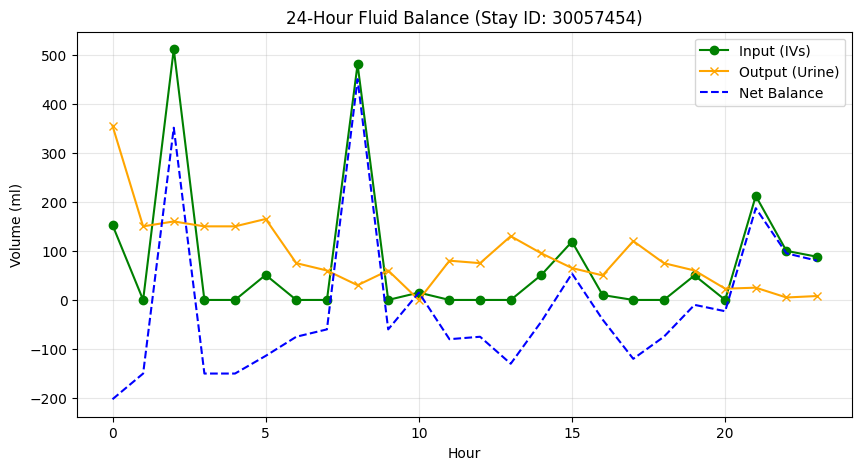


Step 7: Merging Features...
FINAL MERGE COMPLETE: (140, 24, 15)
New Feature List: ['Heart Rate', 'MAP', 'Resp Rate', 'O2 Sat', 'Temp', 'Glucose', 'Sodium', 'Potassium', 'Creatinine', 'Hemoglobin', 'WBC', 'Lactate', 'Total Input', 'Total Output', 'Fluid Balance']

Step 8: Saving Final Dataset...
Saved to: Data\Transformed_data\Processed\X_final_io.npy


In [15]:
# ==========================================
# 6. VISUALIZATION
# ==========================================
print("\nStep 6: Visualizing Fluid Balance")

# Pick a patient with activity
sample_idx = 0
for i in range(len(stay_ids_prev)):
    if X_in[i].sum() > 0: # Find someone with IVs
        sample_idx = i
        break

# Plot
plt.figure(figsize=(10, 5))
hours = range(24)
plt.plot(hours, X_in[sample_idx].flatten(), label='Input (IVs)', color='green', marker='o')
plt.plot(hours, X_out[sample_idx].flatten(), label='Output (Urine)', color='orange', marker='x')
plt.plot(hours, X_bal[sample_idx].flatten(), label='Net Balance', color='blue', linestyle='--')

plt.title(f"24-Hour Fluid Balance (Stay ID: {stay_ids_prev[sample_idx]})")
plt.xlabel("Hour")
plt.ylabel("Volume (ml)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ==========================================
# 7. MERGE EVERYTHING
# ==========================================
print("\nStep 7: Merging Features...")

# Previous: (N, 24, 11) -> Vitals + Labs
# New:      (N, 24, 14) -> Vitals + Labs + Input + Output + Balance
X_combined = np.concatenate([X_prev, X_in, X_out, X_bal], axis=2)

# Update Feature Names
try:
    with open(PROCESSED / 'feature_names.txt', 'r') as f:
        prev_feats = [line.strip() for line in f.readlines()]
except FileNotFoundError:
    prev_feats = ["Unknown"] * X_prev.shape[2]

new_feats = prev_feats + ['Total Input', 'Total Output', 'Fluid Balance']

print(f"FINAL MERGE COMPLETE: {X_combined.shape}")
print(f"New Feature List: {new_feats}")

# ==========================================
# 8. SAVE OUTPUT
# ==========================================
print("\nStep 8: Saving Final Dataset...")

np.save(PROCESSED / 'X_final_io.npy', X_combined)

# Save new feature list
with open(PROCESSED / 'feature_names_io.txt', 'w') as f:
    for feat in new_feats:
        f.write(f"{feat}\n")

print(f"Saved to: {PROCESSED / 'X_final_io.npy'}")

In [16]:
import pandas as pd
import numpy as np
from pathlib import Path
import os

# ==========================================
# 1. SETUP & LOAD PREVIOUS DATA
# ==========================================
print("Step 1: Loading Previous Data...")
RAW = Path('Data/Raw_data')
PROCESSED = Path('Data/Transformed_data/Processed')

# Load the current 'Golden Dataset' (Vitals + Labs + Fluids)
# Shape should be (140, 24, 14)
try:
    X_prev = np.load(PROCESSED / 'X_final_io.npy')
    stay_ids_df = pd.read_csv(PROCESSED / 'stay_ids.csv')
    stay_ids_prev = stay_ids_df['stay_id'].values
    
    # Load feature names to keep track
    with open(PROCESSED / 'feature_names_io.txt', 'r') as f:
        feature_names = [line.strip() for line in f.readlines()]
        
    print(f"Loaded Tensor: {X_prev.shape}")
    print(f"   Features: {feature_names}")
except FileNotFoundError:
    print("Error: Could not find 'X_final_io.npy'. Run the Fluids step first.")
    raise

# Load Raw Medication Data (InputEvents)
# Note: In MIMIC, most continuous meds (Vasopressors) are in inputevents
inputevents = pd.read_csv(RAW / 'inputevents.csv', low_memory=False)
icustays = pd.read_csv(RAW / 'icustays.csv', low_memory=False)

# Standardize
inputevents.columns = inputevents.columns.str.lower()
icustays.columns = icustays.columns.str.lower()

# Time Conversion
inputevents['starttime'] = pd.to_datetime(inputevents['starttime'])
icustays['intime'] = pd.to_datetime(icustays['intime'])

print(f"Raw Data Loaded: {len(inputevents)} Input Events")

Step 1: Loading Previous Data...
Loaded Tensor: (140, 24, 15)
   Features: ['Heart Rate', 'MAP', 'Resp Rate', 'O2 Sat', 'Temp', 'Glucose', 'Sodium', 'Potassium', 'Creatinine', 'Hemoglobin', 'WBC', 'Lactate', 'Total Input', 'Total Output', 'Fluid Balance']
Raw Data Loaded: 20404 Input Events


In [17]:
# ==========================================
# 2. DEFINE MEDICATION CLASSES
# ==========================================
print("\nStep 2: Defining Medication Classes...")

MED_CLASSES = {
    'Vasopressors': ['norepinephrine', 'epinephrine', 'vasopressin', 'phenylephrine', 'dopamine'],
    'Sedatives': ['propofol', 'midazolam', 'fentanyl', 'dexmedetomidine'],
    'Antibiotics': ['vancomycin', 'zosyn', 'piperacillin', 'cefepime', 'meropenem', 'levofloxacin'],
    'Insulin': ['insulin', 'humalog', 'lantus']
}

print(f"Classes Defined: {list(MED_CLASSES.keys())}")


Step 2: Defining Medication Classes...
Classes Defined: ['Vasopressors', 'Sedatives', 'Antibiotics', 'Insulin']


In [18]:
# ==========================================
# 3. PRE-PROCESSING MED DATA (CORRECTED)
# ==========================================
print("\nStep 3: Filtering & Identifying Meds...")

# 1. Filter for relevant patients first
med_df = inputevents[inputevents['stay_id'].isin(stay_ids_prev)].copy()

# 2. Merge with intime to calculate hours
med_df = med_df.merge(icustays[['stay_id', 'intime']], on='stay_id', how='left')
med_df['hour'] = (med_df['starttime'] - med_df['intime']).dt.total_seconds() // 3600

# 3. Filter for the first 24 hours only
med_df = med_df[(med_df['hour'] >= 0) & (med_df['hour'] < 24)]

# --- THE FIX: ADD LABEL COLUMN ---
print("Merging with d_items to get drug names...")
# We merge inputevents (itemid) with d_items (itemid, label)
# Ensure d_items is loaded from Step 1. If not, reload it here.
if 'd_items' not in locals():
    d_items = pd.read_csv(RAW / 'd_items.csv', low_memory=False)
    d_items.columns = d_items.columns.str.lower()

med_df = med_df.merge(d_items[['itemid', 'label']], on='itemid', how='left')

# Check for missing labels
if med_df['label'].isnull().sum() > 0:
    print(f"Warning: {med_df['label'].isnull().sum()} events have no matching label.")
# ---------------------------------

# 4. Create Boolean Columns for each Class
for cls, keywords in MED_CLASSES.items():
    # Check if the 'label' contains ANY of the keywords
    pattern = '|'.join(keywords)
    # Handle NaN values just in case
    med_df[cls] = med_df['label'].str.contains(pattern, case=False, na=False).astype(int)

print(f" Filtered to {len(med_df)} relevant medication events.")
# Check if we actually found anything
print("Event Counts:")
print(med_df[list(MED_CLASSES.keys())].sum())


Step 3: Filtering & Identifying Meds...
Merging with d_items to get drug names...
 Filtered to 6278 relevant medication events.
Event Counts:
Vasopressors    569
Sedatives       676
Antibiotics     169
Insulin         338
dtype: int64


In [19]:
# ==========================================
# 4. CREATE MEDICATION TENSOR
# ==========================================
print("\nStep 4: Building Medication Tensor...")

med_matrices = []
sorted_med_names = list(MED_CLASSES.keys())

for sid in stay_ids_prev:
    # Get all events for this patient
    p_meds = med_df[med_df['stay_id'] == sid]
    
    if p_meds.empty:
        # If no meds, create a matrix of zeros (24 hours x 4 classes)
        patient_matrix = np.zeros((24, len(sorted_med_names)), dtype=np.float32)
    else:
        # Group by Hour and take the MAX (if they had the drug anytime in that hour, it's a 1)
        # We use 'max' because we want binary indicators (0 or 1)
        pivot = p_meds.pivot_table(index='hour', values=sorted_med_names, aggfunc='max')
        
        # Reindex to ensure full 24 hours
        pivot = pivot.reindex(index=range(24), columns=sorted_med_names).fillna(0)
        patient_matrix = pivot.values.astype(np.float32)
        
    med_matrices.append(patient_matrix)

# Stack into Tensor
X_meds = np.stack(med_matrices)

print(f"Medication Tensor Created: {X_meds.shape}")
print(f"   Shape Meaning: ({X_meds.shape[0]} Patients, {X_meds.shape[1]} Hours, {X_meds.shape[2]} Med Classes)")


Step 4: Building Medication Tensor...
Medication Tensor Created: (140, 24, 4)
   Shape Meaning: (140 Patients, 24 Hours, 4 Med Classes)


In [20]:
# ==========================================
# 5. INSPECT ONE PATIENT
# ==========================================
print("\nStep 5: Inspecting Sample Patient...")

# Find a patient who had meds
sample_idx = 0
for i in range(len(X_meds)):
    if X_meds[i].sum() > 0:
        sample_idx = i
        break

stay_id = stay_ids_prev[sample_idx]
print(f"Patient ID: {stay_id}")
print(f"Medication Matrix (First 5 Hours):\n")
print(pd.DataFrame(X_meds[sample_idx][:5], columns=sorted_med_names))


Step 5: Inspecting Sample Patient...
Patient ID: 30057454
Medication Matrix (First 5 Hours):

   Vasopressors  Sedatives  Antibiotics  Insulin
0           0.0        0.0          0.0      0.0
1           0.0        0.0          0.0      0.0
2           0.0        0.0          0.0      0.0
3           0.0        0.0          0.0      0.0
4           0.0        0.0          0.0      0.0


In [21]:
# Quick check to find WHERE the meds are
patient_matrix = X_meds[sample_idx]
active_hours = np.where(patient_matrix.sum(axis=1) > 0)[0]

print(f"Patient {stay_id} received meds at hours: {active_hours}")
print("Data for those hours:")
print(pd.DataFrame(patient_matrix[active_hours], columns=sorted_med_names, index=active_hours))

Patient 30057454 received meds at hours: [10 16 23]
Data for those hours:
    Vasopressors  Sedatives  Antibiotics  Insulin
10           0.0        0.0          0.0      1.0
16           0.0        0.0          0.0      1.0
23           1.0        0.0          0.0      0.0


In [22]:
# ==========================================
# 6. MERGE WITH MAIN DATASET
# ==========================================
print("\nStep 6: Merging into Final Dynamic Dataset...")

# Current X_prev: (140, 24, 14)
# New X_meds:     (140, 24, 4)
# Combined:       (140, 24, 18)

X_final_dynamic = np.concatenate([X_prev, X_meds], axis=2)

# Update Feature Names
final_feature_names = feature_names + sorted_med_names

print(f" FINAL MERGE COMPLETE: {X_final_dynamic.shape}")
print(f"   New Feature Count: {len(final_feature_names)}")
print(f"   Added: {sorted_med_names}")

# ==========================================
# 7. SAVE OUTPUT
# ==========================================
print("\nStep 7: Saving...")

# Save the Tensor
np.save(PROCESSED / 'X_final_dynamic.npy', X_final_dynamic)

# Save the Feature Names
with open(PROCESSED / 'feature_names_dynamic.txt', 'w') as f:
    for feat in final_feature_names:
        f.write(f"{feat}\n")
        
print(f" Saved to: {PROCESSED / 'X_final_dynamic.npy'}")


Step 6: Merging into Final Dynamic Dataset...
 FINAL MERGE COMPLETE: (140, 24, 19)
   New Feature Count: 19
   Added: ['Vasopressors', 'Sedatives', 'Antibiotics', 'Insulin']

Step 7: Saving...
 Saved to: Data\Transformed_data\Processed\X_final_dynamic.npy


Generating Single Patient View...


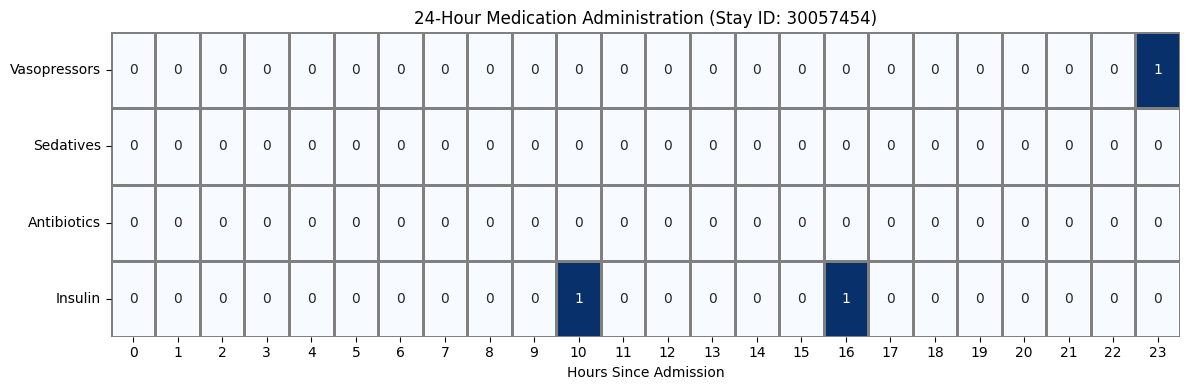


Generating Population View...


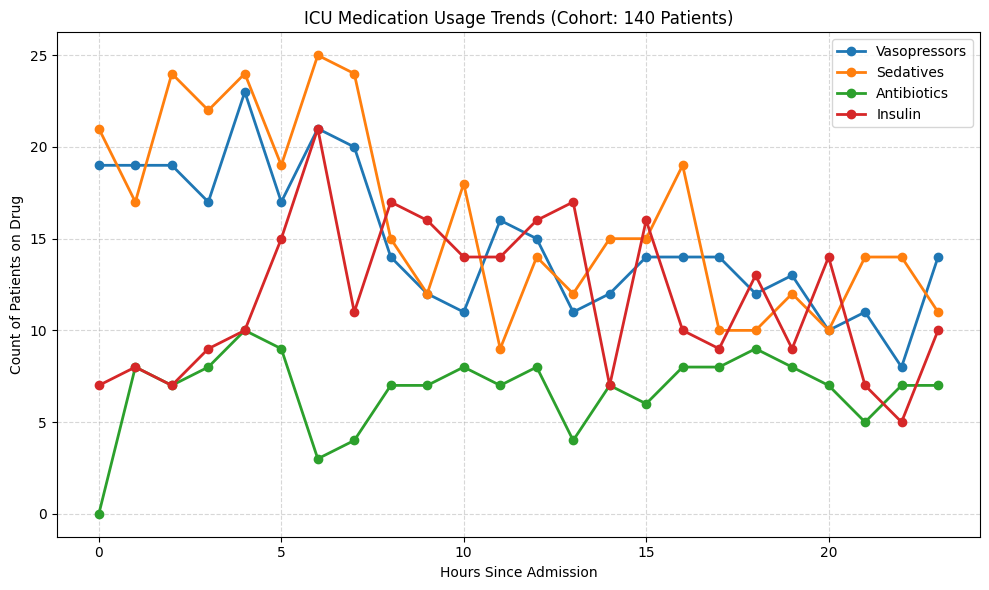

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==========================================
# VISUALIZATION 1: INDIVIDUAL PATIENT HEATMAP
# ==========================================
def plot_medication_heatmap(matrix, patient_ids, patient_index=None):
    # 1. Find an interesting patient (if index not provided)
    # We look for someone who has at least 2 different types of meds
    if patient_index is None:
        for i in range(len(matrix)):
            if matrix[i].sum() > 2: # At least 3 hours of meds
                patient_index = i
                break
    
    if patient_index is None: patient_index = 0 # Fallback

    # 2. Extract Data
    data = matrix[patient_index].T  # Transpose to (4 Classes x 24 Hours)
    stay_id = patient_ids[patient_index]
    med_names = ['Vasopressors', 'Sedatives', 'Antibiotics', 'Insulin']

    # 3. Plot
    plt.figure(figsize=(12, 4))
    
    # Use a binary color map (White = 0, Blue = 1)
    sns.heatmap(data, annot=True, cbar=False, cmap="Blues", 
                linewidths=1, linecolor='gray',
                xticklabels=range(24), yticklabels=med_names)
    
    plt.title(f"24-Hour Medication Administration (Stay ID: {stay_id})")
    plt.xlabel("Hours Since Admission")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


# VISUALIZATION 2: POPULATION TRENDS

def plot_population_trends(matrix):
    # Sum across all 140 patients to see total usage per hour
    # Shape becomes (24, 4)
    hourly_counts = np.sum(matrix, axis=0)
    med_names = ['Vasopressors', 'Sedatives', 'Antibiotics', 'Insulin']
    
    plt.figure(figsize=(10, 6))
    
    # Plot a line for each drug class
    for i, name in enumerate(med_names):
        plt.plot(range(24), hourly_counts[:, i], marker='o', label=name, linewidth=2)
        
    plt.title(f"ICU Medication Usage Trends (Cohort: {len(matrix)} Patients)")
    plt.xlabel("Hours Since Admission")
    plt.ylabel("Count of Patients on Drug")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# --- RUN THE VISUALIZATIONS ---
print("Generating Single Patient View...")
plot_medication_heatmap(X_meds, stay_ids_prev)

print("\nGenerating Population View...")
plot_population_trends(X_meds)

In [24]:
import pandas as pd
import numpy as np
from pathlib import Path

# ==========================================
# 1. SETUP & LOAD DATA
# ==========================================
print("Step 1: Loading Data...")
RAW = Path('Data/Raw_data')
PROCESSED = Path('Data/Transformed_data/Processed')

# Load the "Golden List" of patients (Order matters!)
stay_ids_df = pd.read_csv(PROCESSED / 'stay_ids.csv')
stay_ids_prev = stay_ids_df['stay_id'].values

# Load Admissions Data (Where the outcome lives)
admissions = pd.read_csv(RAW / 'admissions.csv', low_memory=False)
icustays = pd.read_csv(RAW / 'icustays.csv', low_memory=False)

# Standardize
admissions.columns = admissions.columns.str.lower()
icustays.columns = icustays.columns.str.lower()

print(f" Loaded {len(stay_ids_prev)} Target Patients.")

Step 1: Loading Data...
 Loaded 140 Target Patients.


In [25]:
# ==========================================
# 2. MERGE & EXTRACT LABELS
# ==========================================
print("\nStep 2: Extracting Mortality Labels...")

# 1. Link ICU Stay -> Hospital Admission
# We only care about the 140 patients in our list
merged_df = pd.DataFrame({'stay_id': stay_ids_prev}) # Create DataFrame from our ordered list

# Merge with icustays to get hadm_id
merged_df = merged_df.merge(icustays[['stay_id', 'hadm_id']], on='stay_id', how='left')

# Merge with admissions to get hospital_expire_flag
merged_df = merged_df.merge(admissions[['hadm_id', 'hospital_expire_flag']], on='hadm_id', how='left')

# 2. Fill Missing Values
# If outcome is missing, assume they survived (0)
merged_df['hospital_expire_flag'] = merged_df['hospital_expire_flag'].fillna(0).astype(int)

# 3. Create the y vector
y = merged_df['hospital_expire_flag'].values

print(f" Label Vector Created. Shape: {y.shape}")


Step 2: Extracting Mortality Labels...
 Label Vector Created. Shape: (140,)


In [26]:
# ==========================================
# 3. CHECK DISTRIBUTION
# ==========================================
print("\nStep 3: Inspecting Class Balance...")

survived = np.sum(y == 0)
expired = np.sum(y == 1)
total = len(y)

print(f"Total Patients: {total}")
print(f"Alive (0):      {survived} ({survived/total*100:.1f}%)")
print(f"Expired (1):    {expired} ({expired/total*100:.1f}%)")

if expired < 5:
    print("⚠️ WARNING: Very few positive cases. Model training may be difficult.")


Step 3: Inspecting Class Balance...
Total Patients: 140
Alive (0):      120 (85.7%)
Expired (1):    20 (14.3%)


In [27]:
# ==========================================
# 4. VERIFY ALIGNMENT
# ==========================================
print("\nStep 4: Verifying Alignment...")

# Load the X tensor just to compare shapes
X_final_dynamic = np.load(PROCESSED / 'X_final_dynamic.npy')

print(f"X Shape: {X_final_dynamic.shape} (Patients, Time, Features)")
print(f"y Shape: {y.shape} (Labels)")

if X_final_dynamic.shape[0] == y.shape[0]:
    print(" ALIGNMENT CONFIRMED: X and y have the same number of patients.")
else:
    print(f"CRITICAL ERROR: Mismatch! X has {X_final_dynamic.shape[0]}, y has {y.shape[0]}.")


Step 4: Verifying Alignment...
X Shape: (140, 24, 19) (Patients, Time, Features)
y Shape: (140,) (Labels)
 ALIGNMENT CONFIRMED: X and y have the same number of patients.


In [28]:
# ==========================================
# 5. INSPECT SAMPLE
# ==========================================
print("\nStep 5: Inspecting Random Patient...")

idx = 0
sid = stay_ids_prev[idx]
label = y[idx]
outcome = "Expired" if label == 1 else "Survived"

print(f"Index: {idx}")
print(f"Stay ID: {sid}")
print(f"Outcome: {label} ({outcome})")


Step 5: Inspecting Random Patient...
Index: 0
Stay ID: 30057454
Outcome: 0 (Survived)


In [29]:
# ==========================================
# 6. SAVE FINAL ML DATASET
# ==========================================
print("\nStep 6: Saving y labels...")

# Save y
np.save(PROCESSED / 'y_final.npy', y)

print(f" Saved to: {PROCESSED / 'y_final.npy'}")
print("-" * 30)
print(" DATA ENGINEERING COMPLETE.")
print("You now have:")
print(f"1. Inputs (X): {PROCESSED}/X_final_dynamic.npy")
print(f"2. Target (y): {PROCESSED}/y_final.npy")


Step 6: Saving y labels...
 Saved to: Data\Transformed_data\Processed\y_final.npy
------------------------------
 DATA ENGINEERING COMPLETE.
You now have:
1. Inputs (X): Data\Transformed_data\Processed/X_final_dynamic.npy
2. Target (y): Data\Transformed_data\Processed/y_final.npy


Data Loaded Successfully.


C:\Users\tssmi\AppData\Local\Temp\ipykernel_8336\570316271.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y, palette=['#4CAF50', '#F44336']) # Green for Live, Red for Expired


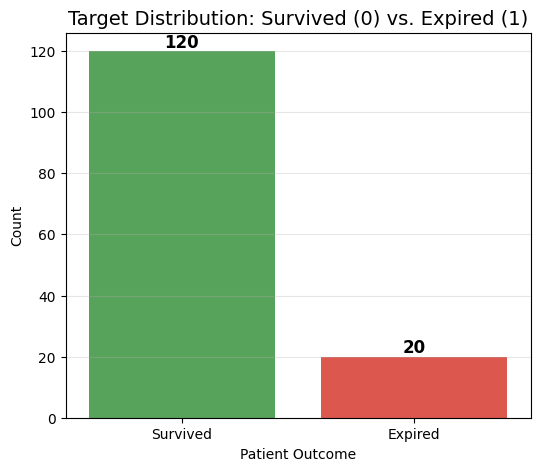

C:\Users\tssmi\AppData\Local\Temp\ipykernel_8336\570316271.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Outcome', y=feature, data=df_viz, palette=['#4CAF50', '#F44336'])
C:\Users\tssmi\AppData\Local\Temp\ipykernel_8336\570316271.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Outcome', y=feature, data=df_viz, palette=['#4CAF50', '#F44336'])
C:\Users\tssmi\AppData\Local\Temp\ipykernel_8336\570316271.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Outcome', y=feature, data=df_viz, palette=['#4CAF50', '#F44336'])
C:\U

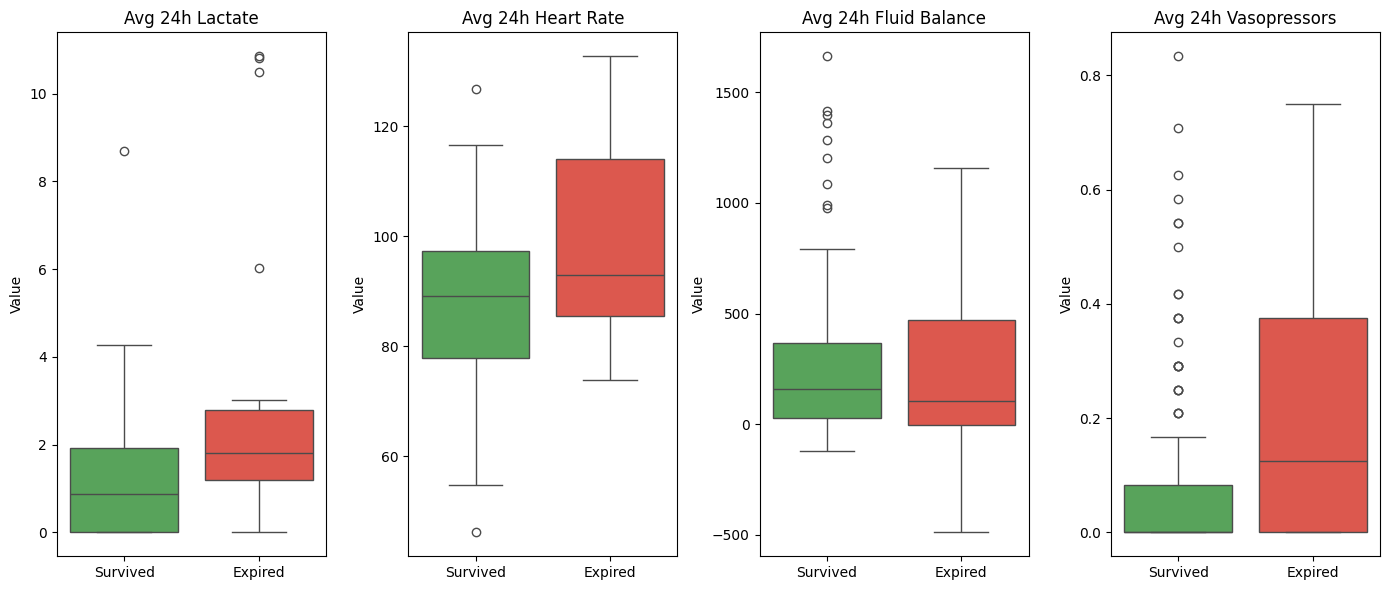

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path

# SETUP
PROCESSED = Path('Data/Transformed_data/Processed')

# Load Data
try:
    X = np.load(PROCESSED / 'X_final_dynamic.npy')
    y = np.load(PROCESSED / 'y_final.npy')
    
    with open(PROCESSED / 'feature_names_dynamic.txt', 'r') as f:
        feature_names = [line.strip() for line in f.readlines()]
        
    print("Data Loaded Successfully.")
except FileNotFoundError:
    print("Error: Files not found. Run previous steps first.")
    raise
# PLOT 1: THE IMBALANCE CHECK (Bar Chart)

plt.figure(figsize=(6, 5))
ax = sns.countplot(x=y, palette=['#4CAF50', '#F44336']) # Green for Live, Red for Expired

# Add counts on top
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title("Target Distribution: Survived (0) vs. Expired (1)", fontsize=14)
plt.xlabel("Patient Outcome")
plt.ylabel("Count")
plt.xticks([0, 1], ['Survived', 'Expired'])
plt.grid(axis='y', alpha=0.3)
plt.show()

# ==========================================
# PLOT 2: CLINICAL REALITY CHECK (Box Plots)
# ==========================================
X_mean = np.mean(X, axis=1) 

# Create DataFrame
df_viz = pd.DataFrame(X_mean, columns=feature_names)
df_viz['Outcome'] = y
df_viz['Outcome'] = df_viz['Outcome'].map({0: 'Survived', 1: 'Expired'})

# 2. Select Key Features to Validate
# Change these strings if your feature names are slightly different!
key_features = ['Lactate', 'Heart Rate', 'Fluid Balance', 'Vasopressors'] 
valid_features = [f for f in key_features if f in feature_names]

plt.figure(figsize=(14, 6))

for i, feature in enumerate(valid_features):
    plt.subplot(1, 4, i+1) # 1 Row, 4 Columns
    
    sns.boxplot(x='Outcome', y=feature, data=df_viz, palette=['#4CAF50', '#F44336'])
    
    plt.title(f"Avg 24h {feature}")
    plt.xlabel("")
    plt.ylabel("Value")

plt.tight_layout()
plt.show()

In [37]:
pip install tensorflow scikit-learn

^C
Note: you may need to restart the kernel to use updated packages.


In [45]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Layer # For Attention
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ==========================================
# 1. LOAD EXISTING PROCESSED DATA
# ==========================================
X_old = np.load('C:\\Users\\tssmi\\OneDrive\\Desktop\\AINutricare\\Notebooks\\Data\\Transformed_data\\Processed\\X_final_dynamic.npy')
y = np.load('C:\\Users\\tssmi\\OneDrive\\Desktop\\AINutricare\\Notebooks\\Data\\Transformed_data\\Processed\\y_final.npy')
stay_ids = pd.read_csv('C:\\Users\\tssmi\\OneDrive\\Desktop\\AINutricare\\Notebooks\\Data\\Transformed_data\\Processed\\stay_ids.csv')
# ==========================================
# 2. EXTRACT NEW FEATURES FROM RAW CSVs
# ==========================================
print("Extracting Age, Gender, Cholesterol...")

# Load Raw Tables')
core = pd.read_csv('C:\\Users\\tssmi\\OneDrive\\Desktop\\AINutricare\\Notebooks\\Data\\Raw_data\\core_numerical_data.csv')
labs = pd.read_csv('C:\\Users\\tssmi\\OneDrive\\Desktop\\AINutricare\\Notebooks\\Data\\Raw_data\\labevents.csv')

# Filter Labs for Cholesterol (Item ID 50907)
chol_data = labs[labs['itemid'] == 50907].copy()
# Aggregate mean cholesterol per subject (in case of multiple tests)
chol_map = chol_data.groupby('subject_id')['valuenum'].mean()

# Prepare new feature array (Shape: 140 patients x 3 features)
# Columns: [Age, Gender, Cholesterol]
new_static_features = np.zeros((len(stay_ids), 3))

print("Merging data for 140 patients...")

for i, row in stay_ids.iterrows():
    s_id = row['stay_id']
    
    # 1. Get Subject ID & Age/Gender from Core Data
    patient_info = core[core['stay_id'] == s_id]
    
    if not patient_info.empty:
        # Age
        age = patient_info['anchor_age'].values[0]
        
        # Gender (Encode: M=1, F=0)
        gender_raw = patient_info['gender'].values[0]
        gender = 1.0 if gender_raw == 'M' else 0.0
        
        # Subject ID (to find Cholesterol)
        subj_id = patient_info['subject_id'].values[0]
    else:
        # Fallback (Should not happen if IDs match)
        age = 65.0
        gender = 1.0
        subj_id = -1

    # 2. Get Cholesterol
    # If missing, impute with "Normal" (180) because data is sparse
    if subj_id in chol_map:
        chol = chol_map[subj_id]
    else:
        chol = 180.0  # Imputation

    # Store
    new_static_features[i, 0] = age
    new_static_features[i, 1] = gender
    new_static_features[i, 2] = chol

# ==========================================
# 3. RESHAPE & CONCATENATE
# ==========================================
# Current X is (140, 24, 18). 
# We need to make static features (140, 24, 3) to stack them.

# Tile the static features 24 times
# (140, 3) -> (140, 1, 3) -> (140, 24, 3)
new_features_tiled = np.tile(new_static_features[:, np.newaxis, :], (1, 24, 1))

# Concatenate along the Feature Axis (Axis 2)
# Result: (140, 24, 21) -> 18 Old + 3 New
X_new = np.concatenate([X_old, new_features_tiled], axis=2)

print(f"\nOriginal Shape: {X_old.shape}")
print(f"New Shape:      {X_new.shape}")
print("Added: Age, Gender, Cholesterol")

# ==========================================
# 4. SAVE NEW STATS (For Normalization later)
# ==========================================
# We need the stats of these new columns for the Test Script
print("\n--- NEW FEATURE STATS ---")
feat_18_mean = np.mean(new_static_features[:,0]) # Age
feat_18_std  = np.std(new_static_features[:,0])

feat_19_mean = np.mean(new_static_features[:,1]) # Gender
feat_19_std  = 1.0 # Boolean, don't scale much

feat_20_mean = np.mean(new_static_features[:,2]) # Chol
feat_20_std  = np.std(new_static_features[:,2])

print(f"Age:  Mean={feat_18_mean:.2f}, Std={feat_18_std:.2f}")
print(f"Chol: Mean={feat_20_mean:.2f}, Std={feat_20_std:.2f}")

# Update STATS dictionary for the Test Script
NEW_STATS_CODE = {
    'Age': (feat_18_mean, feat_18_std),
    'Gender': (0.5, 0.5), # Dummy scaling for binary
    'Cholesterol': (feat_20_mean, feat_20_std)
}

Extracting Age, Gender, Cholesterol...
Merging data for 140 patients...

Original Shape: (140, 24, 19)
New Shape:      (140, 24, 22)
Added: Age, Gender, Cholesterol

--- NEW FEATURE STATS ---
Age:  Mean=62.01, Std=15.37
Chol: Mean=182.11, Std=24.80
